# MODIS LANDSAT PAPER - CODE AND RESULTS

## Modules

In [545]:
# modules - probably too many
import numpy as np
import pandas as pd
import pickle
import matplotlib
import scipy
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text
from sklearn import neighbors
from matplotlib import pyplot as plt
from matplotlib import cm as cm
import matplotlib.colors as colors
from scipy import stats
pd.options.mode.chained_assignment = None  # default='warn'
import math
import seaborn as sns
import multiprocessing
import numpy.matlib as npm
import geeadd
import ee
import mlLocal
from importlib import reload
import statsmodels.api as sm
import loess

In [546]:
from numpy import nan


In [547]:
#code the input feature domain by using a linear hash for each row of the input data frame
#the hash algorithm converts each input row into an integer from 0 to 9 by applying the provided scale and offset and then rounding
#is then produces a hash entry for each row by packing the integers consequitively to form a uint64 code
#this implies a limit of at most 18 columns for the input data frame
#returns a list corresonding to hash table of unique coded input rows
def makeDomain(df,domainIndex,domainScaling,domainOffset):
    df = np.array(df) 
    if df.shape[1] < 19 :
        domainIndex = np.array(domainIndex)
        domainScaling = np.array(domainScaling)
        domainOffset = np.array(domainOffset)
    else:
        raise ValueError("More than 18 dimensions in domain")
    return np.uint64(np.unique(np.sum(np.clip(np.around(df* domainScaling + domainOffset,0),0,9) * np.power(10,np.cumsum(domainIndex)-domainIndex[0]),1),0)).tolist()
          

In [548]:
def trainClassifier(dataDict,regressorsNames,regressorsGEENames, response, domainScaling,domainOffset,samplingFeatures=None,minSubSamples=2000,minSatSamples=-1,maxSamples=10000,percentilePairwiseDist=99,maxleafnodesParent= 1, minSamplesLeafParent=100, maxleafnodesChild= 999, minSamplesLeafChild=10,maxFeatures="auto",nTrees = 100):
    
    
    # make generic names for regressors for use in GEE
    regressors = []
    for item in np.arange(1,len(regressorsNames)+1,1):
        regressors.append('x' + str(item))

    # Calibrate hierarchal randforest preeidctors for each biome
    for biome in dataDict.keys():
        print('biome:',biome)

        if ( biome <10):
            # subset only the regressors and response 
            dfBiome = dataDict[biome]['DF'][sum([regressorsNames,response],[])].astype('int')

            
            # resample the data for calibrating parent tree
            if ( samplingFeatures != None ) :
                dfParent = resampleDF(dfBiome ,regressorsNames,samplingFeatures,minSubSamples=minSubSamples,minSatSamples=minSatSamples,maxSamples=maxSamples,percentilePairwiseDist=percentilePairwiseDist)
                print('subsampled',dfParent.shape)

                dfParent = resampleDF(dfParent,regressorsName,features,minSubSamples,minSubSamples=minSubSamples,minSatSamples=minSatSamples,maxSamples=maxSamples,percentilePairwiseDist=50)
            else :
                dfParent = dfBiome
                
            dfBiome.columns = sum([regressors,response],[])
            dfParent.columns = sum([regressors,response],[])
            print(dfBiome.shape)
            print(dfParent.shape)
             # populate a parent RF dictionary that holds a single tree RF used to partition data into child RFs
            parentRFDict = {}
            parentRFDict.update({'regressors': regressors})
            parentRFDict.update({'regressorsGEE': regressorsGEENames})
            parentRFDict.update({'response': response})
            parentRFDict.update({'domain':makeDomain(dfBiome[regressors],domainIndex,domainScaling,domainOffset)})
            parentRFDict.update({'RF': RandomForestRegressor(n_estimators=1,min_samples_leaf=minSamplesLeafParent,min_samples_split=int(dfParent.shape[0]*0.1),bootstrap=False,random_state=0,verbose=0,max_depth=10,max_leaf_nodes=maxleafnodesParent,max_features=maxFeatures,n_jobs=40) \
                                                                                                         .fit(dfParent[regressors], np.array(dfParent[response]).ravel())})       
            
            # label input data using the prediction from the parent RF as this will be unique
            dfBiome['estimate']=np.around(np.array(parentRFDict['RF'].predict(dfBiome[regressors])),decimals=3)

            # populate dictionary of children RFs, each childRF is itself a dictionary similar to the parentRF but now using more than one tree
            # each child is labelled using the prediction value from the parentRF corresponding to its partition
            childrenRFDict = {}
            print('number children:',np.unique(np.around(np.array(parentRFDict['RF'].predict(dfBiome[regressors])),decimals=3)).size)
            for partition in np.unique(np.around(np.array(parentRFDict['RF'].predict(dfBiome[regressors])),decimals=3)):
                dfpartitionBiome = dfBiome.loc[dfBiome['estimate'] == partition]
                childRFDict = {}
                childRFDict.update({'size': dfpartitionBiome[response].shape[0]})
                childRFDict.update({'regressors': regressors})
                childRFDict.update({'regressorsGEE': regressorsGEENames})
                childRFDict.update({'response': response})
                childRFDict.update({'domain':makeDomain(dfpartitionBiome[regressors],domainIndex,domainScaling,domainOffset)})
                childRFDict.update({'RF': RandomForestRegressor(n_estimators=nTrees,min_samples_leaf=minSamplesLeafChild,bootstrap=True,random_state=0,verbose=0,max_depth=9,max_leaf_nodes=maxleafnodesChild,max_features=maxFeatures,n_jobs=40) \
                                         .fit(dfpartitionBiome[regressors], np.array(dfpartitionBiome[response]).ravel())})             
                childrenRFDict.update({partition: childRFDict})

            # assign the childrenRFDict to the parent
            parentRFDict.update({'childrenRFDict':childrenRFDict })      

            #assign the parentRF dict to the calibration data dictionary for trhis biome
            dataDict[biome].update({method+response[0]+'parentRFDict':parentRFDict})   
    return dataDict

In [549]:
# apply algorithm to data 
def predictClassifier(dataDict,methodDict, method, regressorsNames, response):
    # make generic names for regressors for use in GEE
    regressors = []
    for item in np.arange(1,len(regressorsNames)+1,1):
        regressors.append('x' + str(item))

    # Calibrate hierarchal randforest preeidctors for each biome
    for biome in dataDict.keys():

        print('biome:',biome)

        if ( biome in [1,2,3,4,5,6,7,8]):
            # subset only the regressors 
            dfBiome = dataDict[biome]['DF'][sum([regressorsNames],[])].astype('int')
            dfBiome.columns = regressors

            #apply the parent classifier
            parentRF = methodDict[biome][method+response[0]+'parentRFDict']['RF']
            dfBiome['childNames'] =  np.around(parentRF.predict(dfBiome),decimals=3)
            dataDict[biome]['DF'][method + response[0]+'childNames'] =dfBiome['childNames']

            for partition in np.unique(dfBiome['childNames'] ):
                dfBiome.loc[dfBiome['childNames']==partition,method + response[0]] = methodDict[biome][method+response[0]+'parentRFDict']['childrenRFDict'][partition]['RF'].predict(dfBiome.loc[dfBiome['childNames']==partition][regressors])  
            dataDict[biome]['DF'][method + response[0]] = dfBiome[method + response[0]]
           
    return dataDict

In [550]:
# construct hierarchal random forests for FTL method
def hierarchicalRF(dataDictParent,dataDictChild,regressorsNames,regressorsGEENames, response, domainScaling,domainOffset, maxDepthParent=20, maxDepthChild=20, minSamplesSplit=11,maxleafnodesParent= 100, minSamplesLeafParent=10, maxleafnodesChild= 999, minSamplesLeafChild=10,maxFeaturesChild="auto",maxFeaturesParent="auto",nTrees = 100):
    
    
    # make generic names for regressors for use in GEE
    regressors = []
    for item in np.arange(1,len(regressorsNames)+1,1):
        regressors.append('x' + str(item))

    # Calibrate hierarchal randforest preeidctors for each biome
    for biome in [1,2,3,4,5,6,7,8] : 
    # for biome in  dataDictParent.keys():
        print('biome:',biome)

        # subset only the regressors and response 
        dfBiome = dataDictChild[biome]['DF'][sum([regressorsNames,response],[])].astype('int')   
        dfParent = dataDictParent[biome]['DF'][sum([regressorsNames,response],[])].astype('int')


        dfBiome.columns = sum([regressors,response],[])
        dfParent.columns = sum([regressors,response],[])
        print('Total size ',dfBiome.shape)
        print('Parent size ',dfParent.shape)
         # populate a parent RF dictionary that holds a single tree RF used to partition data into child RFs
        parentRFDict = {}
        parentRFDict.update({'regressors': regressors})
        parentRFDict.update({'regressorsGEE': regressorsGEENames})
        parentRFDict.update({'response': response})
        parentRFDict.update({'domain':makeDomain(dfBiome[regressors],domainIndex,domainScaling,domainOffset)})
        parentRFDict.update({'RF': RandomForestRegressor(n_estimators=1,min_samples_leaf=minSamplesLeafParent,min_samples_split=minSamplesSplit,bootstrap=False,random_state=0,verbose=0,max_depth=maxDepthParent,max_leaf_nodes=maxleafnodesParent,max_features=maxFeaturesParent,n_jobs=40) \
                                                                                                         .fit(dfParent[regressors], np.array(dfParent[response]).ravel())})         
        # label input data using the prediction from the parent RF as this will be unique
        dfBiome['estimate']=np.around(np.array(parentRFDict['RF'].predict(dfBiome[regressors])),decimals=3)

        # populate dictionary of children RFs, each childRF is itself a dictionary similar to the parentRF but now using more than one tree
        # each child is labelled using the prediction value from the parentRF corresponding to its partition
        childrenRFDict = {}
        print('number children:',np.unique(np.around(np.array(parentRFDict['RF'].predict(dfBiome[regressors])),decimals=3)).size)
        for partition in np.unique(np.around(np.array(parentRFDict['RF'].predict(dfBiome[regressors])),decimals=3)):
            dfpartitionBiome = dfBiome.loc[dfBiome['estimate'] == partition]
            childRFDict = {}
            childRFDict.update({'size': dfpartitionBiome[response].shape[0]})
            childRFDict.update({'regressors': regressors})
            childRFDict.update({'regressorsGEE': regressorsGEENames})
            childRFDict.update({'response': response})
            childRFDict.update({'domain':makeDomain(dfpartitionBiome[regressors],domainIndex,domainScaling,domainOffset)})
            childRFDict.update({'RF': RandomForestRegressor(n_estimators=nTrees,min_samples_leaf=minSamplesLeafChild,bootstrap=True,random_state=0,verbose=0,max_depth=maxDepthChild,max_leaf_nodes=maxleafnodesChild,max_features=maxFeaturesChild,n_jobs=40) \
                                     .fit(dfpartitionBiome[regressors], np.array(dfpartitionBiome[response]).ravel())})             
            childrenRFDict.update({partition: childRFDict})

        # assign the childrenRFDict to the parent
        parentRFDict.update({'childrenRFDict':childrenRFDict })      

        #assign the parentRF dict to the calibration data dictionary for trhis biome
        dataDictParent[biome].update({method+response[0]+'parentRFDict':parentRFDict})   
    return dataDictParent

In [551]:
# histogram plot of values and density for LAI and fAPAR for a biome and save to file

def histplotKDE(biome,outputFileName=None) :
    sns.set_context("paper")
    df1 = calbiomeDictLAI[biome]['DF'][['LAI','kde']].sample(np.min([1000,calbiomeDictLAI[biome]['DF'].shape[0]])).divide([10.,1.])
    df2 = valbiomeDictLAI[biome]['DF'][['LAI','kde']].sample(np.min([1000,valbiomeDictLAI[biome]['DF'].shape[0]])).divide([10.,1.])
    df3 = calbiomeDictFAPAR[biome]['DF'][['FAPAR','kde']].sample(np.min([1000,calbiomeDictFAPAR[biome]['DF'].shape[0]])).divide([10.,1.])
    df4 = valbiomeDictFAPAR[biome]['DF'][['FAPAR','kde']].sample(np.min([1000,valbiomeDictFAPAR[biome]['DF'].shape[0]])).divide([10.,1.])

    fig, axs = plt.subplots(ncols=2,nrows=2 , figsize=(7, 4))
    fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)
    ax = axs[0,0]
    hb = sns.histplot(df1,x='LAI',ax=ax, fill=False, element="step",stat='probability')
    hb = sns.histplot(df2,x='LAI',ax=ax, fill=False, element="step",stat='probability')
    ax = axs[0,1]
    hb = sns.histplot(df1,x='kde',ax=ax, fill=False,binwidth=0.1, element="step",stat='probability')
    hb = sns.histplot(df2,x='kde',ax=ax, fill=False,binwidth=0.1, element="step",stat='probability')
    ax = axs[1,0]
    hb = sns.histplot(df3,x='FAPAR',ax=ax, fill=False, element="step",stat='probability')
    hb = sns.histplot(df4,x='FAPAR',ax=ax, fill=False, element="step",stat='probability')
    ax = axs[1,1]
    hb = sns.histplot(df3,x='kde',ax=ax, fill=False,binwidth=0.1, element="step",stat='probability')
    hb = sns.histplot(df4,x='kde',ax=ax, fill=False,binwidth=0.1, element="step",stat='probability')
    plt.show()
    if (outputFileName != None):
        fig.savefig(outputFileName, bbox_inches='tight') 
    return

In [552]:
# does pair plots of densities for each method for a biome
def pairplotKDE(biome,outputFileName=None,nsam=10000,Size=10):
    df1 = calbiomeDictLAI[biome]['DF'][['red','NIR','cosSZA','cosVZA','cosSA','LAI','FAPAR','kdenorm']].sample(np.min([nsam,calbiomeDictLAI[biome]['DF'].shape[0]])).divide([10000.,10000.,10000.,10000.,10000.,10,100,1.])
    df2 = calbiomeDictLAIFTLUnSat[biome]['DF'][['red','NIR','cosSZA','cosVZA','cosSA','LAI','FAPAR','kdenorm']].sample(np.min([nsam,calbiomeDictLAIFTLUnSat[biome]['DF'].shape[0]])).divide([10000.,10000.,10000.,10000.,10000.,10,100,1.])
    df3 = calbiomeDictLAIFTLSat[biome]['DF'][['red','NIR','cosSZA','cosVZA','cosSA','LAI','FAPAR','kdenorm']].sample(np.min([nsam,calbiomeDictLAIFTLSat[biome]['DF'].shape[0]])).divide([10000.,10000.,10000.,10000.,10000.,10,100,1.])
    df4 = calbiomeDictLAIKANG[biome]['DF'][['red','NIR','cosSZA','cosVZA','cosSA','LAI','FAPAR','kdenorm']].sample(np.min([nsam,calbiomeDictLAIKANG[biome]['DF'].shape[0]])).divide([10000.,10000.,10000.,10000.,10000.,10,100,1.])
    # hue_norm= (df['kdenorm'].quantile(0.1),df['kdenorm'].quantile(0.9))
    fig, axs = plt.subplots(ncols=4,nrows=3 , figsize=(12, 12),sharey='row',sharex= 'row')
    fig.tight_layout(w_pad=1.25,h_pad=1)
    
    # fig.subplots_adjust(hspace=0.2, left=0.07, right=0.93)
    ax =  axs[0,0]
    df =df1
    hb = sns.scatterplot(x=df['LAI'],y=df['FAPAR'],hue=df['kdenorm'],s=Size,hue_norm=(df['kdenorm'].quantile(0.1),df['kdenorm'].quantile(0.9)),ax=ax)
    ax.text(0.05, 0.975, 'a. NAIVE', transform=ax.transAxes, fontsize=10,verticalalignment='top',color='k')
    hb.legend(loc='lower right', title='Probability Density')
    ax.set_box_aspect(1)
    ax = axs[0,1]
    df = df2
    df['kdenorm'] = df['kdenorm'].divide(df1['kdenorm'].quantile(0.1))
    hb = sns.scatterplot(x=df['LAI'],y=df['FAPAR'],hue=df['kdenorm'],s=Size,hue_norm=(df['kdenorm'].quantile(0.1),df['kdenorm'].quantile(0.9)),ax=ax)
    ax.text(0.05, 0.975, 'b. FTL-Unsat', transform=ax.transAxes, fontsize=10,verticalalignment='top',color='k')
    hb.legend(loc='lower right', title='Probability Density')
    ax.set_box_aspect(1)
    ax = axs[0,2]
    df = df3
    hb = sns.scatterplot(x=df['LAI'],y=df['FAPAR'],hue=df['kdenorm'],s=Size,hue_norm=(df['kdenorm'].quantile(0.1),df['kdenorm'].quantile(0.9)),ax=ax)
    ax.text(0.05, 0.975, 'c. FTL-Sat', transform=ax.transAxes, fontsize=10,verticalalignment='top',color='k')
    hb.legend(loc='lower right', title='Probability Density')
    ax.set_box_aspect(1)
    ax = axs[0,3]
    df = df4
    hb = sns.scatterplot(x=df['LAI'],y=df['FAPAR'],hue=df['kdenorm'],s=Size,hue_norm=(df['kdenorm'].quantile(0.1),df['kdenorm'].quantile(0.9)),ax=ax)
    ax.text(0.05, 0.975, 'd. K2021', transform=ax.transAxes, fontsize=10,verticalalignment='top',color='k')
    hb.legend(loc='lower right', title='Probability Density')
    ax.set_box_aspect(1)
    ax = axs[1,0]
    df = df1
    hb = sns.scatterplot(x=df['red'],y=df['NIR'],hue=df['kdenorm'],s=Size,hue_norm=(df['kdenorm'].quantile(0.1),df['kdenorm'].quantile(0.9)),ax=ax)
    ax.text(0.05, 0.975, 'e. NAIVE', transform=ax.transAxes, fontsize=10,verticalalignment='top',color='k')
    hb.legend(loc='lower right', title='Probability Density')
    ax.set_box_aspect(1)
    ax = axs[1,1]
    df = df2
    hb = sns.scatterplot(x=df['red'],y=df['NIR'],hue=df['kdenorm'],s=Size,hue_norm=(df['kdenorm'].quantile(0.1),df['kdenorm'].quantile(0.9)),ax=ax)
    axs[1,1].text(0.05, 0.975, 'f. FTL-Unsat', transform=axs[1,1].transAxes, fontsize=10,verticalalignment='top',color='k')
    hb.legend(loc='lower right', title='Probability Density')
    axs[1,1].set_box_aspect(1)
    ax = axs[1,2]
    df = df3
    hb = sns.scatterplot(x=df['red'],y=df['NIR'],hue=df['kdenorm'],s=Size,hue_norm=(df['kdenorm'].quantile(0.1),df['kdenorm'].quantile(0.9)),ax=ax)
    ax.text(0.05, 0.975, 'g. FTL-Sat', transform=ax.transAxes, fontsize=10,verticalalignment='top',color='k')
    hb.legend(loc='lower right', title='Probability Density')
    ax.set_box_aspect(1)
    ax = axs[1,3]
    df = df4
    hb = sns.scatterplot(x=df['red'],y=df['NIR'],hue=df['kdenorm'],s=Size,hue_norm=(df['kdenorm'].quantile(0.1),df['kdenorm'].quantile(0.9)),ax=ax)
    ax.text(0.05, 0.975, 'h. K2021', transform=ax.transAxes, fontsize=10,verticalalignment='top',color='k')
    hb.legend(loc='lower right', title='Probability Density')
    ax.set_box_aspect(1)
    ax = axs[2,0]
    df = df1
    hb = sns.scatterplot(x=df['cosSZA'],y=df['cosSA'],hue=df['kdenorm'],s=Size,hue_norm=(df['kdenorm'].quantile(0.1),df['kdenorm'].quantile(0.9)),ax=ax)
    ax.text(0.05, 0.975, 'i. NAIVE', transform=ax.transAxes, fontsize=10,verticalalignment='top',color='k')
    hb.legend(loc='lower right', title='Probability Density')
    ax.set_box_aspect(1)
    ax = axs[2,1]
    df = df2
    hb = sns.scatterplot(x=df['cosSZA'],y=df['cosSA'],hue=df['kdenorm'],s=Size,hue_norm=(df['kdenorm'].quantile(0.1),df['kdenorm'].quantile(0.9)),ax=ax)
    axs[2,1].text(0.05, 0.975, 'j. FTL-Unsat', transform=axs[2,1].transAxes, fontsize=10,verticalalignment='top',color='k')
    hb.legend(loc='lower right', title='Probability Density')
    axs[2,1].set_box_aspect(1)
    ax = axs[2,2]
    df = df3
    hb = sns.scatterplot(x=df['cosSZA'],y=df['cosSA'],hue=df['kdenorm'],s=Size,hue_norm=(df['kdenorm'].quantile(0.1),df['kdenorm'].quantile(0.9)),ax=ax)
    ax.text(0.05, 0.975, 'k. FTL-Sat', transform=ax.transAxes, fontsize=10,verticalalignment='top',color='k')
    hb.legend(loc='lower right', title='Probability Density')
    ax.set_box_aspect(1)
    ax = axs[2,3]
    df = df4
    hb = sns.scatterplot(x=df['cosSZA'],y=df['cosSA'],hue=df['kdenorm'],s=Size,hue_norm=(df['kdenorm'].quantile(0.1),df['kdenorm'].quantile(0.9)),ax=ax)
    ax.text(0.05, 0.975, 'l. K2021', transform=ax.transAxes, fontsize=10,verticalalignment='top',color='k')
    hb.legend(loc='lower right', title='Probability Density')
    ax.set_box_aspect(1)


 
    if ( outputFileName != None ) :
        fig.savefig(outputFileName, bbox_inches='tight') 
    return

In [553]:
# get minimum pairwise distances between rows in data frame
def getMinPairwiseDist(df,maxSamples, metricDist):
    
    df = df.drop_duplicates()
    nsam = min(maxSamples,df.shape[0])
    di = pairwise_distances(df.sample(nsam),n_jobs=-1,metric=metricDist)

    return np.amin(di+np.diag(np.ones(di.shape[0])+100),axis=1)



# does a very fast kernel density estimator of local sample density
def parrallel_score_samples(kde, samples, thread_count=int(0.875 * multiprocessing.cpu_count())):
    with multiprocessing.Pool(thread_count) as p:
        return np.concatenate(p.map(kde.score_samples, np.array_split(samples, thread_count)))
    
#provides kde estimate for each sample using bandwidth proportionat  to  spacing defined by percentilePairwiseDist
def estimateKDE(df,featureColumns,maxSamples, percentilePairwiseDist=99,metricDist='euclidean',randSeed=1):
    scaledFeatures = pd.DataFrame(MinMaxScaler().fit_transform(df[featureColumns]))
    maxPairwiseDistance =np.percentile(getMinPairwiseDist(scaledFeatures,maxSamples,metricDist),percentilePairwiseDist)
    print('max dist',maxPairwiseDistance)
    rawFeaturesKDE2 = neighbors.KernelDensity(bandwidth=3*maxPairwiseDistance,kernel='gaussian',atol = 1e-8,rtol=1e-6).fit(scaledFeatures)
    if ( scaledFeatures.shape[0] < 100 ):
        return np.exp(rawFeaturesKDE2.score_samples(scaledFeatures))
    else:
        return np.exp(parrallel_score_samples(rawFeaturesKDE2, scaledFeatures))

# provides kde estimate for each sample using bandwidth proportionat  to  spacing defined by percentilePairwiseDist
def estimateKDEbandwidth(df,featureColumns,maxSamples, bandwidth,metricDist='euclidean',randSeed=1):
    scaledFeatures = pd.DataFrame(MinMaxScaler().fit_transform(df[featureColumns]))
    rawFeaturesKDE2 = neighbors.KernelDensity(bandwidth=bandwidth,kernel='gaussian',atol = 1e-8,rtol=1e-6).fit(scaledFeatures)
    if ( scaledFeatures.shape[0] < 100 ):
        return np.exp(rawFeaturesKDE2.score_samples(scaledFeatures))
    else:
        return np.exp(parrallel_score_samples(rawFeaturesKDE2, scaledFeatures))



#downsample to uniform distribution given a kde estimate
def subsampleUniformKDE(df,kdeColumn,percentileKDE):
    uniformKDE = np.percentile(df[kdeColumn],percentileKDE)
    return df.loc[df[kdeColumn] < (uniformKDE/np.random.uniform(low=0.0, high=1.0, size=df.shape[0]))]

#subsamples df based on uniform Sobol sampling of featurecolumns with spacing defined by percentilePairwiseDist
def subsampleUniform(df,featureColumns,maxSamples,minSamples=0,minSamplesFrac=0,percentilePairwiseDist=99,overSample=1,jitterSize=None,method='Halton',metricDist='euclidean',randSeed=1):
    dfSamples = pd.DataFrame()
    minSamples = np.minimum(minSamples,df.shape[0]*minSamplesFrac)
    # print(minSamples)
    while dfSamples.shape[0] < minSamples :
        dfNewSamples =  uniformSampler(df,featureColumns,maxSamples,metricDist,randSeed,np.percentile(getMinPairwiseDist(pd.DataFrame(MinMaxScaler().fit_transform(df[featureColumns].drop_duplicates()),columns=featureColumns),min(10000,maxSamples),metricDist),percentilePairwiseDist)/overSample,jitterSize,method,exact=True)
        dfSamples = pd.concat([dfSamples,dfNewSamples]).drop_duplicates()
        df.drop(dfNewSamples.index)
        randSeed = randSeed + 1
        # print(dfSamples.shape[0])
    return dfSamples.sample(np.minimum(maxSamples,dfSamples.shape[0]))

In [554]:
# resample all dataframes corresponding to biome data provided in a dictionary 
def resampleDict(dictBiome,regressors,features,satFlag=-1,minSubSamples=100,maxSamples=10000,percentileKDE=1) :
    biomeDict = {}
    for biome in dictBiome.keys():

        #extract the data for this biome for the selected sat Flag
        dfBiome = dictBiome[biome]['DF']
        if ( satFlag > 0 ):
            dfBiome = dfBiome.loc[dfBiome['LUT_satFlag']==satFlag]
        biomeDict.update({biome: {'DF': dictBiome[biome]['DF']}})
        biomeShape = dfBiome.shape[0]
        
        #uniform sampling
        if (dfBiome.shape[0]>0):
            print('Biome',biome,' with ',dfBiome.shape[0],'samples.')
            dfBiome['kde'] = estimateKDE(dfBiome,features,maxSamples, percentilePairwiseDist=99,metricDist='manhattan',randSeed=1)
            dfBiometemp = subsampleUniformKDE(dfBiome,'kde',percentileKDE)

            if (dfBiometemp.shape[0]>=minSubSamples):
                dfBiome = dfBiometemp
                #resestimate density after subsampling, use pairwise distance of 99 percential to ensure window for kde is big enough
                dfBiome['kde'] = estimateKDE(dfBiome,regressors,maxSamples, percentilePairwiseDist=99,metricDist='manhattan',randSeed=1)
                biomeDict.update({biome: {'DF':  dfBiome}})
                print('Biome ',biome,' using only ', dfBiome.shape[0], 'of ',biomeShape,' samples.')
            else :
                dfBiome = dfBiome.sort_values('kde').head(np.minimum(dfBiome.shape[0],minSubSamples))
                print('Biome ',biome,' using  ', dfBiome.shape[0] ,' samples')
        else:
            print('Biome ',biome,' has no samples')

    return biomeDict

In [555]:
# resample dataframes corresponding to biome 
# resampling is uniform but then balancing of saturated and unsaturated samples is performed if minSamples>0
def resampleDF(dfBiome,regressors,features,minSubSamples=100,minSatSamples=-1,maxSamples=10000,percentilePairwiseDist=99) :
        
        #uniform sampling
        dfBiome['kde'] = estimateKDE(dfBiome,features,maxSamples, percentilePairwiseDist,metricDist='manhattan',randSeed=1)
        dfBiomeSub = subsampleUniformKDE(dfBiome,'kde',1)
        
        if (dfBiomeSub.shape[0]>=minSubSamples):
            #resestimate density after subsampling, use pairwise distance of 99 percential to ensure window for kde is big enough
            dfBiomeSub['kde'] = estimateKDE(dfBiomeSub,regressors,maxSamples, percentilePairwiseDist=99,metricDist='manhattan',randSeed=1)

            #separate into unsat and sat 
            dfBiomeSubSat = pd.DataFrame()
            dfBiomeSubUnSat = pd.DataFrame()
            dfBiomeSubSat = dfBiome.loc[dfBiome['LUT_satFlag']==1]
            dfBiomeSubUnSat = dfBiome.loc[dfBiome['LUT_satFlag']==0]

            # balance sat and unsat samples if there are at least 10000
            numMinSamples = np.minimum(dfBiomeSubSat.shape[0],dfBiomeSubUnSat.shape[0])
            if (minSatSamples>=0) & (numMinSamples>minSatSamples) & ((2*minSubSamples)>minSubSamples):
                return pd.concat([ dfBiomeSubSat.sample(numMinSamples),dfBiomeSubUnSat.sample(numMinSamples) ])               
            else :
                return dfBiomeSub
        else :
            return dfBiome

In [556]:
# parse a sckitlearn decision tree into a R text tree suitable for use in GEE
# for compactness ancillary items like node sample size and residuals are forced to = 1
# this is a blind guess by Richard but seems to work
def make_tree(rf,regressors,decimals):
    
    # first get the output in sckitlearn text format in a dataframe
    r = export_text(rf,feature_names=regressors,show_weights=True,decimals=decimals)
    r = r.splitlines()
    rdf = pd.DataFrame(r,columns = ['rule'])

    #identify rules and not leaf values
    isrule = ~rdf['rule'].str.contains('value')
    rulesdf = rdf.loc[isrule]

    #determine level in tree and the associated starting based node number
    rdf['level'] = rdf['rule'].str.count(r'(\|)').values.tolist()
    rdf.loc[isrule,'base'] = ((rdf.level).mul(0).add(2)).pow(rdf.level)

    # get the actual tested condition
    rdf.loc[isrule,'condition'] =  rdf.loc[isrule,'rule'].str.extract(r'(x.+)').values.tolist()
    
    # identify leaf nodes and fill in the response value
    rdf.loc[~isrule,'leaf'] = '*'
    rdf['leaf'] = rdf['leaf'].fillna(method='bfill',limit=1)
    rdf.loc[~isrule,'response'] = rdf.loc[~isrule,'rule'].str.extract(r'([+-]?([0-9]*[.])?[0-9]+)')[0].values.tolist()
    rdf['response'] = rdf['response'].fillna(method='bfill')

    #discard non rules
    rdf.loc[rdf['leaf'].isna(),'leaf'] = ' '
    rdf = rdf.dropna()

    #dtermine if this is a left or right branch
    rdf['branch'] = rdf['rule'].str.contains(r'(?:\>)').astype('int')
    rdf['node'] = rdf.base + rdf.branch
    rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
    rdfindex = rdf.index

    #asign a node number, this is non trivial and critical for use later
    #read https://www.r-bloggers.com/2022/10/understanding-leaf-node-numbers-when-using-rpart-and-rpart-rules/
    for row in range(2,rdf.shape[0]):
        # find the nearest row above
        df = rdf[0:row]
        if ( (rdf[row:row+1].level.values)[0] > 1 ):
            parentdf = df.loc[df.level == (rdf[row:row+1].level.values-1)[0]].iloc[-1]
            rdf.at[rdfindex[row],'parentbase'] = parentdf.base  
            rdf.at[rdfindex[row],'parentnode'] = parentdf.node  
            rdf.at[rdfindex[row],'node'] = rdf.iloc[row].node + 2 * (  parentdf.node - parentdf.base ) 
            
    # glue together each rule in a big string, add the root node and return as a list
    rdf['phrase'] = rdf.apply(lambda x:  ' ' *(2 * x.level) + str(int(x.node)) + ') ' + x.condition + ' 0 0 ' + str(x.response) + ' ' +x.leaf + '\n', axis=1)
    return ( '1) root 1 1 1 (1)\n'+''.join(rdf['phrase'].values.tolist()))

In [557]:
def plotMaps(sampleDict,mapTitle) :
    fig, axes = plt.subplots(2, 4, figsize=(16,6), sharey=True)
    cmap=cm.get_cmap('viridis')
    im=cm.ScalarMappable()
    axes[0][0].hexbin(sampleDict[1]['DF']['Lon'], sampleDict[1]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
    axes[0][1].hexbin(sampleDict[2]['DF']['Lon'], sampleDict[2]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
    axes[0][2].hexbin(sampleDict[3]['DF']['Lon'], sampleDict[3]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
    axes[0][3].hexbin(sampleDict[4]['DF']['Lon'], sampleDict[4]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))

    axes[1][0].hexbin(sampleDict[5]['DF']['Lon'], sampleDict[5]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
    axes[1][1].hexbin(sampleDict[6]['DF']['Lon'], sampleDict[6]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
    axes[1][2].hexbin(sampleDict[7]['DF']['Lon'], sampleDict[7]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
    hb = axes[1][3].hexbin(sampleDict[8]['DF']['Lon'], sampleDict[8]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))

    fig.suptitle(mapTitle)

    # Title biomes
    axes[0][0].set_title('Biome 1', size=10)
    axes[0][1].set_title('Biome 2', size=10)
    axes[0][2].set_title('Biome 3', size=10)
    axes[0][3].set_title('Biome 4', size=10)

    axes[1][0].set_title('Biome 5', size=10)
    axes[1][1].set_title('Biome 6', size=10)
    axes[1][2].set_title('Biome 7', size=10)
    axes[1][3].set_title('Biome 8', size=10)

    fig.tight_layout()

    #Add colorbar
    cb = fig.colorbar(hb, ax=axes)
    cb.set_label('#samples')

    plt.show()
    return

In [561]:
# trims match ups based on view zenith angle and then reflectance
def trimMatchUps(df,zenithThresh):

    
    #trim based on thresholds
    df = df[(df.NIRMODIS >= 200 ) & (df.redMODIS>=200 ) & (df.green > 0 ) & (df.red >100) & (df.NIR > 0 ) & (df.SWIR1 > 0 )& (df.green < 5000) & (df.red < 5000) &  (df.SWIR1 < 5000)  & (df.M_sensor_zenith<zenithThresh)]

    #trim based on bivariate histograms
    return trimDFNumSample(trimDFNumSample(df,'redMODIS','red',[5,95],100000),'NIRMODIS','NIR',[5,95],100000)


In [560]:
# trims a dataframe of outliers of the conditional distribution of y given x using fixed sample sizes
def trimDFNumSample(df,x,y,percentiles,numsamples):
    # sort DF by the x value to speed up subsetting
    dropList = []
    df = df.sort_values(by=x)
    N = df.shape[0]
    print(N)
    for i in range(0,N,np.floor(numsamples).astype(int)):
        # find location of value nearest to current bin
        Sample = df[i:np.minimum(i+numsamples,N)]
        dropList.append(Sample.loc[(Sample[y]<=np.percentile(Sample[y],percentiles[0])) | (Sample[y]>=np.percentile(Sample[y],percentiles[1]))].index.tolist()) 
    print(len(sum(dropList,[])))
    return df.drop(sum(dropList,[]))

In [559]:
# trims a dataframe of outliers of the conditional distribution of y given x using fixed bin widths
def trimDF(df,x,y,percentiles,bins,binwidth):
    df = df.sort_values(by=x).reset_index()
    for i in range (len(bins)-1):
        data = df.loc[abs(df[x]-bins[i])<binwidth[i]]
        if not data.empty:
            df = df.drop(data.loc[(data[y]<np.percentile(data[y], percentiles[0]))].index.values)
            df = df.drop(data.loc[(data[y]>np.percentile(data[y], percentiles[1]))].index.values)
    return df

In [558]:
# makes additional regressors for an input calibration database data frame
def makeFeatures(df):

    df['cosSZA'] = 10000 *  np.cos(np.radians(df.loc[:,'SolarZenith']))
    df['cosVZA'] = 10000 * np.cos(np.radians(df.loc[:,'SensorZenith']))

    df['cosSA'] = 10000 * (np.cos(np.radians(df.loc[:,'SolarZenith'])) * np.cos(np.radians(df.loc[:,'SensorZenith'])) + \
                        np.sin(np.radians(df.loc[:,'SolarZenith'])) * np.sin(np.radians(df.loc[:,'SensorZenith'])) * \
                        np.cos(np.radians(df.loc[:,'SolarAzimuth']) - np.radians(df.loc[:,'SensorAzimuth'])))
    df['NDVI'] = np.clip(((df.loc[:,"NIR"])-(df.loc[:,"red"]))/np.maximum(((df.loc[:,"NIR"])+(df.loc[:,"red"])),.0001),0,+1)
    df['NDWI'] = np.clip(((df.loc[:,"SWIR1"])-(df.loc[:,"red"]))/np.maximum(((df.loc[:,"SWIR1"])+(df.loc[:,"red"])),.0001),0,+1)
    
    return df

## Figures for Paper

In [475]:
# Global sample using Richard sampling code
dfALL = pd.read_pickle('c:/users/rfernand/modisLandsat/code/MODISLANDSATall.pkl')

# Sample based on trimming for NAIVE (also used as a basis for FTL)
dfALLtrim = pd.read_pickle('c:/users/rfernand/modisLandsat/code/MODISLANDSATalltrim.pkl')

# Sample based on trimming for K2021
dfALLtrimKANG = pd.read_pickle('c:/users/rfernand/modisLandsat/code/MODISLANDSATalltrimKANG.pkl')




In [478]:
print(dfALL.keys())

Index(['year', 'month', 'day', 'path', 'row', 'Lat', 'Lon', 'input36',
       'input45', 'inputMOD09', 'redMODIS', 'NIRMODIS', 'green', 'red', 'NIR',
       'SWIR1', 'SensorZenith', 'SensorAzimuth', 'SolarZenith', 'SolarAzimuth',
       'M_sensor_zenith', 'M_sensor_azimuth', 'M_sun_zenith', 'M_sun_azimuth',
       'LC_type3', 'output', 'LAI', 'stdLAI', 'FAPAR', 'stdFAPAR',
       'LUT_satFlag', 'LUT_snowFlag', 'cosSZA', 'cosVZA', 'cosSA', 'NDVI'],
      dtype='object')


In [17]:


# Validation data for LAI and FAPAR
valbiomeDictLAI = pd.read_pickle('c:/users/rfernand/modisLandsat/code/valbiomeDictLAIdf.pkl')
valbiomeDictFAPAR = pd.read_pickle('c:/users/rfernand/modisLandsat/code/valbiomeDictFAPARdf.pkl')

# Calibration data for LAI and FAPAR
calbiomeDictLAI = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictLAIdf.pkl')
calbiomeDictFAPAR = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictFAPARdf.pkl')


# Kang's calibration data for LAI and FAPAR
calbiomeDictLAIKANG = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictLAIKANGdf.pkl')
calbiomeDictFAPARKANG = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictFAPARKANGdf.pkl')

# FTL  calibration data for LAI and FAPAR
calbiomeDictLAIFTL= pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictLAIFTLdf.pkl')
calbiomeDictFAPARFTL = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictFAPARFTLdf.pkl')

### Figure 1.  Spatial density of (a) all calibration samples, (b) calibration samples after trimming for K2021 and, (c)  calibration samples after trimming for NAIVE.

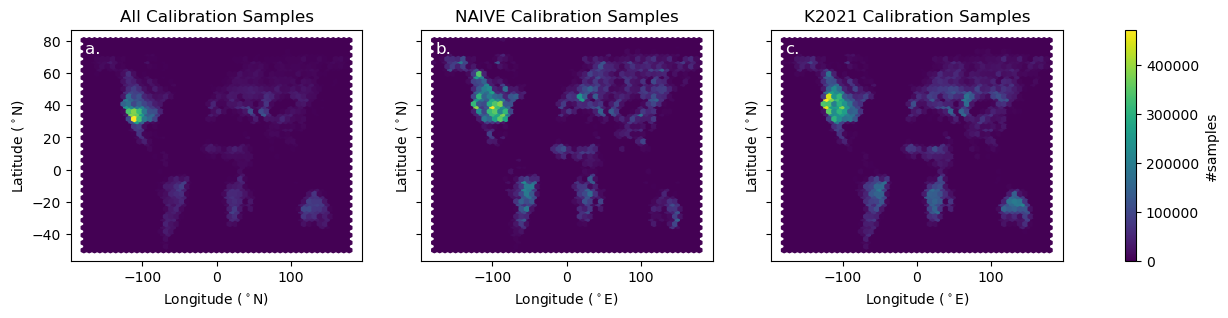

In [19]:
# RF - can you make this a bit more square and fix colorbar position
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(16,3), sharex=True, sharey=True)
cmap=cm.get_cmap('viridis')
hb = ax[0].hexbin(dfALL['Lon'],dfALL['Lat'], gridsize=(50),cmap=cmap)
hb = ax[1].hexbin(dfALLtrim['Lon'],dfALLtrim['Lat'], gridsize=(50),cmap=cmap)
hb = ax[2].hexbin(dfALLtrimKANG['Lon'], dfALLtrimKANG['Lat'], gridsize=(50),cmap=cmap)
ax[0].set_title("All Calibration Samples")
ax[0].set_ylabel("Latitude ($^\circ$N)")
ax[0].set_xlabel("Longitude ($^\circ$N)")
ax[0].text(0.05, 0.95, 'a.', transform=ax[0].transAxes, fontsize=12,verticalalignment='top',color='w')

ax[1].set_title("NAIVE Calibration Samples")
ax[1].set_ylabel("Latitude ($^\circ$N)")
ax[1].set_xlabel("Longitude ($^\circ$E)")
ax[1].text(0.05, 0.95, 'b.', transform=ax[1].transAxes, fontsize=12,verticalalignment='top',color='w')

ax[2].set_title("K2021 Calibration Samples")
ax[2].set_ylabel("Latitude ($^\circ$N)")
ax[2].set_xlabel("Longitude ($^\circ$E)")
ax[2].text(0.05, 0.95, 'c.', transform=ax[2].transAxes, fontsize=12,verticalalignment='top',color='w')

cb = fig.colorbar(hb, ax=ax)
cb.set_label('#samles')
cb.set_label('#samples')
plt.savefig('Figure1.png', bbox_inches='tight')
plt.show()

Figure 1.  Spatial density of (a) all calibration samples, (b) calibration samples after trimming for K2021 and, (c)  calibration samples after trimming for NAIVE.

### Figure 2.  Total size of the calibration databases for each method for each biome.  Also idnciated are the number of saturated samples in each database.  (Bar chart , y axis #samples, x-axis biome, each biome has 3 bars corresponding to each of NAIVE, K2021 and FTL and also indicates #saturated samples as a sub-bar.Figure 2.  Total size of the calibration databases for each method for each biome.  Also idnciated are the number of saturated samples in each database.  (Bar chart , y axis #samples, x-axis biome, each biome has 3 bars corresponding to each of NAIVE, K2021 and FTL and also indicates #saturated samples as a sub-bar.

In [301]:
biomeName = {
    1: 'Grasslands',
    2: 'Shrublands',
    3: 'Broadleaf Croplands',
    4: 'Savannas',
    5: 'Evergreen Broadleaf Forests',
    6: 'Deciduous Broadleaf Forests',
    7: 'Evergreen Needleleaf Forests',
    8: 'Deciduous Needleleaf Forests',
    9: 'Non-Vegetated Lands',
    10: 'Urban and Built-up Lands'
}
biomeName2 = {
    1: 'GRA',
    2: 'SHR',
    3: 'CRO',
    4: 'SAV',
    5: 'EBF',
    6: 'DBF',
    7: 'ENF',
    8: 'DNF',
    9: 'NVL',
    10: 'GBL'
}

In [144]:

calbiomeDFLAINAIVE = pd.DataFrame()
calbiomeDFLAIKANG = pd.DataFrame()
calbiomeDFLAIFTL = pd.DataFrame()
calbiomeDFLAIVAL = pd.DataFrame()

calbiomeDFFAPARNAIVE = pd.DataFrame()
calbiomeDFFAPARKANG = pd.DataFrame()
calbiomeDFFAPARFTL = pd.DataFrame()
calbiomeDFFAPARVAL = pd.DataFrame()

for LC_Type3 in calbiomeDictLAI:
    if LC_Type3 <= 8:
        df = calbiomeDictLAI[LC_Type3]['DF']
        df['biomeName'] = biomeName2[LC_Type3]
        calbiomeDFLAINAIVE = pd.concat([calbiomeDFLAINAIVE,df])
        
        df = calbiomeDictLAIKANG[LC_Type3]['DF']
        df['biomeName'] = biomeName2[LC_Type3]
        calbiomeDFLAIKANG = pd.concat([calbiomeDFLAIKANG,df])
        
        df = calbiomeDictLAIFTL[LC_Type3]['DF']
        df['biomeName'] = biomeName2[LC_Type3]
        calbiomeDFLAIFTL = pd.concat([calbiomeDFLAIFTL,df])
        
        df = valbiomeDictLAI[LC_Type3]['DF']
        df['biomeName'] = biomeName2[LC_Type3]
        calbiomeDFLAIVAL = pd.concat([calbiomeDFLAIVAL,df])
        
        df = calbiomeDictFAPAR[LC_Type3]['DF']
        df['biomeName'] = biomeName2[LC_Type3]
        calbiomeDFFAPARNAIVE = pd.concat([calbiomeDFFAPARNAIVE,df])
        
        df = calbiomeDictFAPARKANG[LC_Type3]['DF']
        df['biomeName'] = biomeName2[LC_Type3]
        calbiomeDFFAPARKANG = pd.concat([calbiomeDFFAPARKANG,df])
        
        df = calbiomeDictFAPARFTL[LC_Type3]['DF']
        df['biomeName'] = biomeName2[LC_Type3]
        calbiomeDFFAPARFTL = pd.concat([calbiomeDFFAPARFTL,df])
        
        df = valbiomeDictFAPAR[LC_Type3]['DF']
        df['biomeName'] = biomeName2[LC_Type3]
        calbiomeDFFAPARVAL = pd.concat([calbiomeDFFAPARVAL,df])
        
NAIVEDFLAI = pd.DataFrame(data={
    'true': calbiomeDFLAINAIVE['LAI'],
    'biomeName': calbiomeDFLAINAIVE['biomeName'],
    'LC_Type3': calbiomeDFLAINAIVE['LC_type3'],
    'LUT_satFlag': calbiomeDFLAINAIVE['LUT_satFlag'],
    'method': 'NAIVE'
})

KANGDFLAI = pd.DataFrame(data={
    'true': calbiomeDFLAIKANG['LAI'],
    'biomeName': calbiomeDFLAIKANG['biomeName'],
    'LC_Type3': calbiomeDFLAIKANG['LC_type3'],
    'LUT_satFlag': calbiomeDFLAIKANG['LUT_satFlag'],
    'method': 'K2021'
})

FTLDFLAI = pd.DataFrame(data={
    'true': calbiomeDFLAIFTL['LAI'],
    'biomeName': calbiomeDFLAIFTL['biomeName'],
    'LC_Type3': calbiomeDFLAIFTL['LC_type3'],
    'LUT_satFlag': calbiomeDFLAIFTL['LUT_satFlag'],
    'method': 'FTL'
})


VALDFLAI = pd.DataFrame(data={
    'true': calbiomeDFLAIVAL['LAI'],
    'biomeName': calbiomeDFLAIVAL['biomeName'],
    'LC_Type3': calbiomeDFLAIVAL['LC_type3'],
    'LUT_satFlag': calbiomeDFLAIVAL['LUT_satFlag'],
    'method': 'VAL'
})

calbiomeDFLAI= pd.concat([NAIVEDFLAI,KANGDFLAI,FTLDFLAI,VALDFLAI])
calbiomeDFLAI['response'] = 'LAI'


NAIVEDFFAPAR = pd.DataFrame(data={
    'true': calbiomeDFFAPARNAIVE['FAPAR'],
    'biomeName': calbiomeDFFAPARNAIVE['biomeName'],
    'LC_Type3': calbiomeDFFAPARNAIVE['LC_type3'],
    'LUT_satFlag': calbiomeDFFAPARNAIVE['LUT_satFlag'],
    'method': 'NAIVE'
})


KANGDFFAPAR = pd.DataFrame(data={
    'true': calbiomeDFFAPARKANG['FAPAR'],
    'biomeName': calbiomeDFFAPARKANG['biomeName'],
    'LC_Type3': calbiomeDFFAPARKANG['LC_type3'],
    'LUT_satFlag': calbiomeDFFAPARKANG['LUT_satFlag'],
    'method': 'K2021'
})


FTLDFLAIFAPAR = pd.DataFrame(data={
    'true': calbiomeDFFAPARFTL['FAPAR'],
    'biomeName': calbiomeDFFAPARFTL['biomeName'],
    'LC_Type3': calbiomeDFFAPARFTL['LC_type3'],
    'LUT_satFlag': calbiomeDFFAPARFTL['LUT_satFlag'],
    'method': 'FTL'
})


VALDFLAIFAPAR = pd.DataFrame(data={
    'true': calbiomeDFFAPARVAL['FAPAR'],
    'biomeName': calbiomeDFFAPARVAL['biomeName'],
    'LC_Type3': calbiomeDFFAPARVAL['LC_type3'],
    'LUT_satFlag': calbiomeDFFAPARVAL['LUT_satFlag'],
    'method': 'VAL'
})

calbiomeDFFAPAR = pd.concat([NAIVEDFFAPAR,KANGDFFAPAR,FTLDFLAIFAPAR,VALDFLAIFAPAR])

calbiomeDFFAPAR['response'] = 'FAPAR'

calbiomeDF = pd.concat([calbiomeDFLAI, calbiomeDFFAPAR])

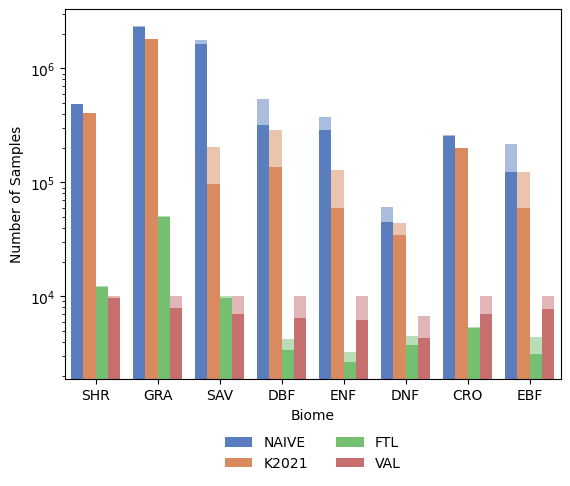

In [152]:
sat = calbiomeDFLAI.loc[calbiomeDFLAI['LUT_satFlag'] == 0]
ax = plt.subplot()

sns.countplot(data=sat, x='biomeName', hue='method', ax=ax, palette='muted')
sns.countplot(data=calbiomeDFLAI, x='biomeName', hue='method', ax=ax, alpha=0.5, palette='muted')

ax.set_ylabel('Number of Samples')
ax.set_xlabel('Biome')
plt.yscale("log")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:4], labels, loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2, title=None, frameon=False)
plt.savefig('Figure2.png', bbox_inches='tight')


### Figure 3.  Density contour plots of MODIS vs OLI red for NIR brf based on 10,000 rando sub-samples of (a,d) all samples, (c,e) K2021 trimmed samples and (e,f) NAIVE trimmed samples.  Dashed black line is 1:1 line.  Blue line is ordinary least squares regression fit.  Contours correspond to equal probability intervals.

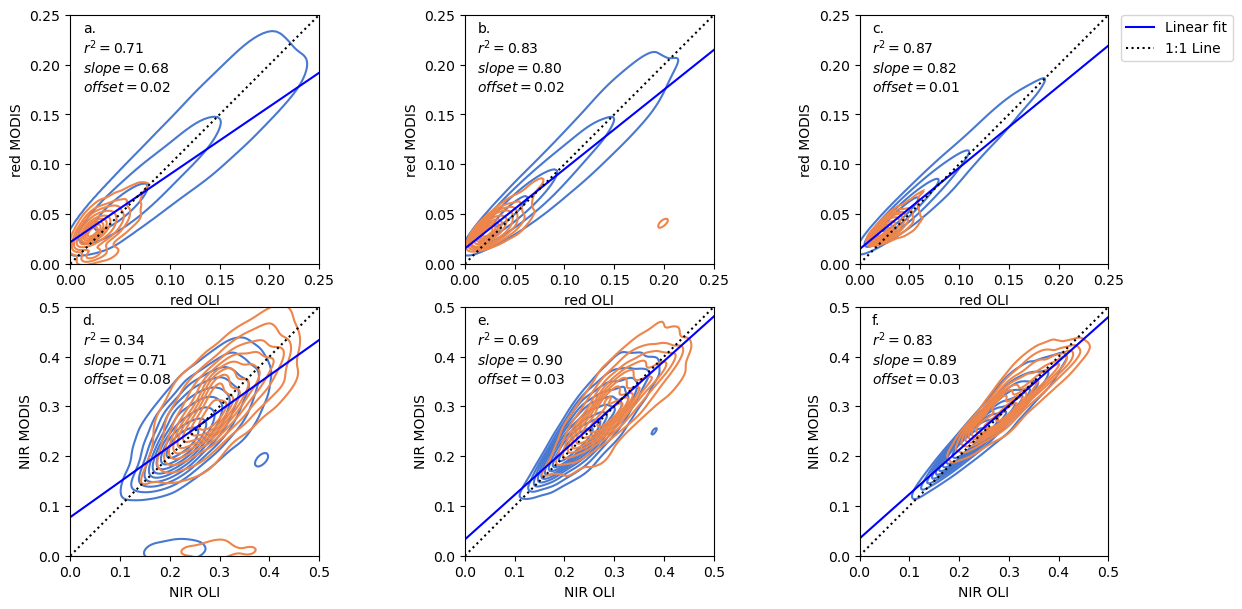

In [60]:
# kde plots of OLI vs MODIS bands for all and trimmed databases
# RF - add legend with 1:1 line, linear fit, SatFlag=0, SatFlag=1
# RF - why does sat flag = 1 hue have fewer contours?
dfALL = dfALL.loc[~((dfALL['red']>1500)&(dfALL['redMODIS']<500))]
dfALLtrim = dfALLtrim.loc[~((dfALLtrim['red']>1500)&(dfALLtrim['redMODIS']<500))]

fig, ax = plt.subplots(nrows=2,ncols=3, figsize=(12,6))
fig.tight_layout(w_pad=1,h_pad=1)

deciles = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
df = pd.concat([dfALL.loc[dfALL['LUT_satFlag']==0].sample(10000) , dfALL.loc[dfALL['LUT_satFlag']==1].sample(10000) ])/ 10000
g = sns.kdeplot(ax=ax[0,0],data=df, x="red", y="redMODIS", hue='LUT_satFlag',palette="muted",levels=deciles,legend=False)
ax[0,0].set(xlabel='red OLI', ylabel='red MODIS')
r = LinearRegression().fit(np.array(df['red']).reshape(-1, 1) ,df['redMODIS'])
rscore=r.score(np.array(df['red']).reshape(-1, 1) ,df['redMODIS'])
slope = r.coef_[0]
offset = r.intercept_
textstr = '\n'.join((
    'a.',
    r'$r^2=%.2f$' % (rscore, ),
    r'$slope=%.2f$' % (slope, ),
    r'$offset=%.2f$' % (offset, )))
ax[0,0].set_xlim(0,0.25)
ax[0,0].set_ylim(0,0.25)
ax[0,0].set_box_aspect(1)
ax[0,0].plot([0,0.25],[offset,0.25*slope+offset],'b')
ax[0,0].plot([0,0.25],[0,0.25],':k')
ax[0,0].text(0.05, 0.975, textstr, transform=ax[0,0].transAxes, fontsize=10,verticalalignment='top',color='k')

g = sns.kdeplot(ax=ax[1,0],data=df, x="NIR", y="NIRMODIS", hue='LUT_satFlag',palette="muted",levels=deciles,legend=False)
ax[1,0].set(xlabel='NIR OLI', ylabel='NIR MODIS')
r = LinearRegression().fit(np.array(df['NIR']).reshape(-1, 1) ,df['NIRMODIS'])
rscore=r.score(np.array(df['NIR']).reshape(-1, 1) ,df['NIRMODIS'])
slope = r.coef_[0]
offset = r.intercept_
textstr = '\n'.join((
    'd.',
    r'$r^2=%.2f$' % (rscore, ),
    r'$slope=%.2f$' % (slope, ),
    r'$offset=%.2f$' % (offset, )))
ax[1,0].set_xlim(0,0.5)
ax[1,0].set_ylim(0,0.5)
ax[1,0].set_box_aspect(1)
ax[1,0].plot([0,0.5],[offset,0.5*slope+offset],'b')
ax[1,0].plot([0,0.5],[0,0.5],':k')
ax[1,0].text(0.05, 0.975, textstr, transform=ax[1,0].transAxes, fontsize=10,verticalalignment='top',color='k')


df = pd.concat([dfALLtrimKANG.loc[dfALLtrimKANG['LUT_satFlag']==0].sample(10000) , dfALLtrimKANG.loc[dfALLtrimKANG['LUT_satFlag']==1].sample(10000) ])/ 10000
g = sns.kdeplot(ax=ax[0,1],data=df, x="red", y="redMODIS", hue='LUT_satFlag',palette="muted",levels=deciles,legend=False)
ax[0,1].set(xlabel='red OLI', ylabel='red MODIS')
r = LinearRegression().fit(np.array(df['red']).reshape(-1, 1) ,df['redMODIS'])
rscore=r.score(np.array(df['red']).reshape(-1, 1) ,df['redMODIS'])
slope = r.coef_[0]
offset = r.intercept_
textstr = '\n'.join((
    'b.',
    r'$r^2=%.2f$' % (rscore, ),
    r'$slope=%.2f$' % (slope, ),
    r'$offset=%.2f$' % (offset, )))
ax[0,1].set_xlim(0,0.25)
ax[0,1].set_ylim(0,0.25)
ax[0,1].set_box_aspect(1)
ax[0,1].plot([0,0.25],[offset,0.25*slope+offset],'b')
ax[0,1].plot([0,0.25],[0,0.25],':k')
ax[0,1].text(0.05, 0.975, textstr, transform=ax[0,1].transAxes, fontsize=10,verticalalignment='top',color='k')

g = sns.kdeplot(ax=ax[1,1],data=df, x="NIR", y="NIRMODIS", hue='LUT_satFlag',palette="muted",levels=deciles,legend=False)
ax[1,1].set(xlabel='NIR OLI', ylabel='NIR MODIS')
r = LinearRegression().fit(np.array(df['NIR']).reshape(-1, 1) ,df['NIRMODIS'])
rscore=r.score(np.array(df['NIR']).reshape(-1, 1) ,df['NIRMODIS'])
slope = r.coef_[0]
offset = r.intercept_
textstr = '\n'.join((
    'e.',
    r'$r^2=%.2f$' % (rscore, ),
    r'$slope=%.2f$' % (slope, ),
    r'$offset=%.2f$' % (offset, )))
ax[1,1].set_xlim(0,0.5)
ax[1,1].set_ylim(0,0.5)
ax[1,1].set_box_aspect(1)
ax[1,1].plot([0,0.5],[offset,0.5*slope+offset],'b')
ax[1,1].plot([0,0.5],[0,0.5],':k')
ax[1,1].text(0.05, 0.975, textstr, transform=ax[1,1].transAxes, fontsize=10,verticalalignment='top',color='k')


df = pd.concat([dfALLtrim.loc[dfALLtrim['LUT_satFlag']==0].sample(10000) , dfALLtrim.loc[dfALLtrim['LUT_satFlag']==1].sample(10000) ])/ 10000
g = sns.kdeplot(ax=ax[0,2],data=df, x="red", y="redMODIS", hue='LUT_satFlag',palette="muted",levels=deciles,legend=False)
ax[0,2].set(xlabel='red OLI', ylabel='red MODIS')
r = LinearRegression().fit(np.array(df['red']).reshape(-1, 1) ,df['redMODIS'])
rscore=r.score(np.array(df['red']).reshape(-1, 1) ,df['redMODIS'])
slope = r.coef_[0]
offset = r.intercept_
textstr = '\n'.join((
    'c.',
    r'$r^2=%.2f$' % (rscore, ),
    r'$slope=%.2f$' % (slope, ),
    r'$offset=%.2f$' % (offset, )))
ax[0,2].set_xlim(0,0.25)
ax[0,2].set_ylim(0,0.25)
ax[0,2].set_box_aspect(1)
ax[0,2].plot([0,0.25],[offset,0.25*slope+offset],'b')
ax[0,2].plot([0,0.25],[0,0.25],':k')
ax[0,2].text(0.05, 0.975, textstr, transform=ax[0,2].transAxes, fontsize=10,verticalalignment='top',color='k')
g.legend(labels=['Linear fit','1:1 Line','Sat.','Unsat.'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title = None)

g = sns.kdeplot(ax=ax[1,2],data=df, x="NIR", y="NIRMODIS", hue='LUT_satFlag',palette="muted",levels=deciles,legend=False)
ax[1,2].set(xlabel='NIR OLI', ylabel='NIR MODIS')
r = LinearRegression().fit(np.array(df['NIR']).reshape(-1, 1) ,df['NIRMODIS'])
rscore=r.score(np.array(df['NIR']).reshape(-1, 1) ,df['NIRMODIS'])
slope = r.coef_[0]
offset = r.intercept_
textstr = '\n'.join((
    'f.',
    r'$r^2=%.2f$' % (rscore, ),
    r'$slope=%.2f$' % (slope, ),
    r'$offset=%.2f$' % (offset, )))
ax[1,2].set_xlim(0,0.5)
ax[1,2].set_ylim(0,0.5)
ax[1,2].set_box_aspect(1)
ax[1,2].plot([0,0.5],[offset,0.5*slope+offset],'b')
ax[1,2].plot([0,0.5],[0,0.5],':k')
ax[1,2].text(0.05, 0.975, textstr, transform=ax[1,2].transAxes, fontsize=10,verticalalignment='top',color='k')

plt.savefig('Figure3.png', bbox_inches='tight')


plt.show()

Figure 3.  Density contour plots of MODIS vs OLI red for NIR brf based on 10,000 rando sub-samples of (a,d) all samples, (c,e) K2021 trimmed samples and (e,f) NAIVE trimmed samples.  Dashed black line is 1:1 line.  Blue line is ordinary least squares regression fit.  Contours correspond to equal probability intervals.

### Figure 4.  Scatter plots of (a,b,c,) response variables and (d,e,f) selected regressor variables for each method (columns).  Local density in regressor feature space relative to median local density indciated by hue.

In [290]:
# produce normalized kde for each method
for biome in [7]:
    print(biome)
    calbiomeDictLAI[biome]['DF']['kdenorm']=calbiomeDictLAI[biome]['DF']['kde']
    calbiomeDictLAIKANG[biome]['DF']['kdenorm']=calbiomeDictLAIKANG[biome]['DF']['kde']
    # calbiomeDictLAIFTL[biome]['DF']['kdenorm']=calbiomeDictLAIFTL[biome]['DF']['kdebig']
    calbiomeDictLAIFTLUnSat[biome]['DF']['kdenorm']=calbiomeDictLAIFTLUnSat[biome]['DF']['kde']
    calbiomeDictLAIFTLSat[biome]['DF']['kdenorm']=calbiomeDictLAIFTLSat[biome]['DF']['kde']
    # calbiomeDictLAIFTL2UnSat[biome]['DF']['kdenorm']=calbiomeDictLAIFTL2UnSat[biome]['DF']['kdebig']
    # calbiomeDictLAIFTL2Sat[biome]['DF']['kdenorm']=calbiomeDictLAIFTL2Sat[biome]['DF']['kdebig']

    # calbiomeDictLAI[biome]['DF']['kdenorm']=calbiomeDictLAI[biome]['DF']['kdebig']/(calbiomeDictLAI[biome]['DF']['kdebig'].mean()) 
    # calbiomeDictLAIKANG[biome]['DF']['kdenorm']=calbiomeDictLAIKANG[biome]['DF']['kdebig']/(calbiomeDictLAIKANG[biome]['DF']['kdebig'].mean())  
    # calbiomeDictLAIFTL[biome]['DF']['kdenorm']=calbiomeDictLAIFTL[biome]['DF']['kde']/(calbiomeDictLAIFTL[biome]['DF']['kdebig'].mean()) 
    # calbiomeDictLAIFTLUnSat[biome]['DF']['kdenorm']=calbiomeDictLAIFTLUnSat[biome]['DF']['kdebig']/(calbiomeDictLAIFTLUnSat[biome]['DF']['kdebig'].mean()) 
    # calbiomeDictLAIFTLSat[biome]['DF']['kdenorm']=calbiomeDictLAIFTLSat[biome]['DF']['kdebig']/(calbiomeDictLAIFTLSat[biome]['DF']['kdebig'].mean()) 
    # calbiomeDictLAIFTL2UnSat[biome]['DF']['kdenorm']=calbiomeDictLAIFTL2UnSat[biome]['DF']['kde']/(calbiomeDictLAIFTL2UnSat[biome]['DF']['kdebig'].mean()) 
    # calbiomeDictLAIFTL2Sat[biome]['DF']['kdenorm']=calbiomeDictLAIFTL2Sat[biome]['DF']['kde']/(calbiomeDictLAIFTL2Sat[biome]['DF']['kdebig'].mean()) 

    
#     calbiomeDictLAIFTLUnSat[biome]['DF']['kdenorm']=calbiomeDictLAIFTLUnSat[biome]['DF']['kde'].div(calbiomeDictLAIFTLUnSat[biome]['DF'].groupby(['FTLLAIchildNames'])['kde'].transform('mean')) -1
#     calbiomeDictLAIFTLSat[biome]['DF']['kdenorm']=calbiomeDictLAIFTLSat[biome]['DF']['kde'].div(calbiomeDictLAIFTLSat[biome]['DF'].groupby(['FTLLAIchildNames'])['kde'].transform('mean'))-1
#     calbiomeDictLAIFTL[biome]['DF']['kdenorm']=calbiomeDictLAIFTL[biome]['DF']['kde'].div(calbiomeDictLAIFTL[biome]['DF'].groupby(['FTLLAIchildNames'])['kde'].transform('mean'))-1
  

7


In [287]:
# estimate kde with constant bandwidth for all methods
for biome in [7]:
    regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
    calbiomeDictLAIFTLUnSat[biome]['DF']['kdebig'] = estimateKDEbandwidth(calbiomeDictLAIFTLUnSat[biome]['DF'],regressors,10000, .5,metricDist='manhattan',randSeed=1)
    calbiomeDictLAIFTLSat[biome]['DF']['kdebig'] = estimateKDEbandwidth(calbiomeDictLAIFTLSat[biome]['DF'],regressors,10000, .5,metricDist='manhattan',randSeed=1)
    calbiomeDictLAI[biome]['DF']['kdebig'] = estimateKDEbandwidth(calbiomeDictLAI[biome]['DF'],regressors,10000, 0.5,metricDist='manhattan',randSeed=1)
    regressors =  ['red','NIR','SWIR1','NDVI','NDWI','Lat','Lon','cosSZA','cosSA']
    calbiomeDictLAIKANG[biome]['DF']['kdebig'] = estimateKDEbandwidth(calbiomeDictLAIKANG[biome]['DF'],regressors,10000, 0.9,metricDist='manhattan',randSeed=1)


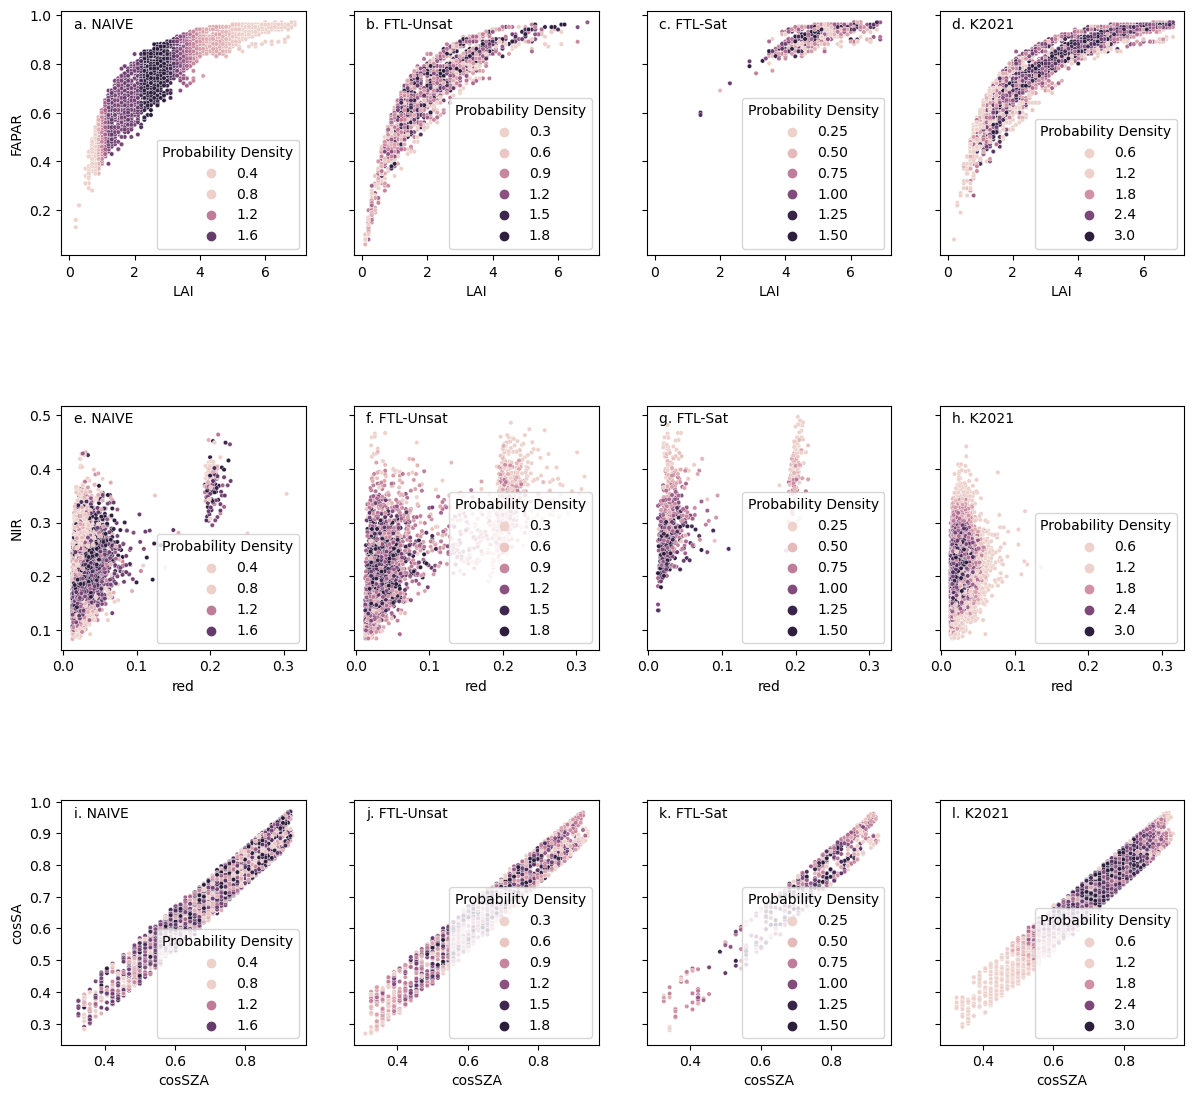

In [294]:
for biome in [7]:
    pairplotKDE(biome,'KDEbiome'+str(biome),nsam=10000,Size=10)

### Figure 6.  Histograms of (a,b,c) LAI and (d,e,f) FAPAR per biome from calibration database samples for each method (columns).


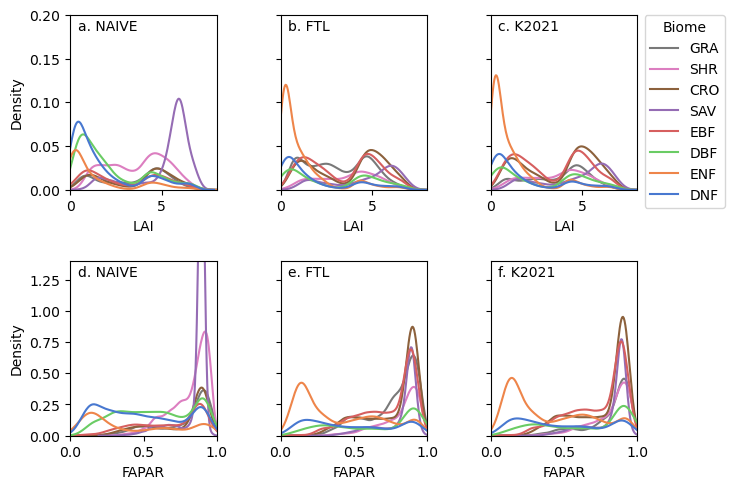

In [303]:
#histograms of LAI and fAPAR for each calibratiom database
fig,axs = plt.subplots(nrows=2,ncols=3,sharey='row')
fig.tight_layout(w_pad=3,h_pad=3)

#extract data for each calibration database for all biomes
df1 = pd.DataFrame()
df2 = pd.DataFrame()
df3 = pd.DataFrame()

for biome in [1,2,3,4,5,6,7,8]:
    df3 = pd.concat([df1,calbiomeDictLAIUnSat[biome]['DF'].sample(1000),calbiomeDictLAISat[biome]['DF'].sample(1000)])
    df1 = pd.concat([df2,calbiomeDictLAIFTLUnSat[biome]['DF'].sample(1000),calbiomeDictLAIFTLSat[biome]['DF'].sample(1000)])
    df2 = pd.concat([df3,calbiomeDictLAIKANG[biome]['DF'].sample(2000)])

#change scales of mapped variables
df1 = df1[['LAI','FAPAR','LC_type3']].divide([10,100,1])
df2 = df2[['LAI','FAPAR','LC_type3']].divide([10,100,1])
df3 = df3[['LAI','FAPAR','LC_type3']].divide([10,100,1])



sns.kdeplot(df1,ax=axs[0,0],x='LAI',hue="LC_type3",palette="muted",legend=False)
axs[0,0].text(0.05, 0.975, 'a. NAIVE', transform=axs[0,0].transAxes, fontsize=10,verticalalignment='top',color='k')
axs[0,0].set_xlim(0,8)
axs[0,0].set_ylim(0,0.2)

sns.kdeplot(df2,ax=axs[0,1],x='LAI',hue="LC_type3",palette="muted",legend=False)
axs[0,1].text(0.05, 0.975, 'b. FTL', transform=axs[0,1].transAxes, fontsize=10,verticalalignment='top',color='k')
axs[0,1].set_xlim(0,8)
axs[0,1].set_ylim(0,0.2)

p3 = sns.kdeplot(df3,ax=axs[0,2],x='LAI',hue="LC_type3",palette="muted",legend=False)
axs[0,2].text(0.05, 0.975, 'c. K2021', transform=axs[0,2].transAxes, fontsize=10,verticalalignment='top',color='k')
axs[0,2].set_xlim(0,8)
axs[0,2].set_ylim(0,0.2)
p3.legend(labels=biomeName2.values(),bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title = 'Biome')

sns.kdeplot(df1,ax=axs[1,0],x='FAPAR',hue="LC_type3",palette="muted",legend=False)
axs[1,0].text(0.05, 0.975, 'd. NAIVE', transform=axs[1,0].transAxes, fontsize=10,verticalalignment='top',color='k')
axs[1,0].set_xlim(0,1)
axs[1,0].set_ylim(0,1.4)

sns.kdeplot(df2,ax=axs[1,1],x='FAPAR',hue="LC_type3",palette="muted",legend=False)
axs[1,1].text(0.05, 0.975, 'e. FTL', transform=axs[1,1].transAxes, fontsize=10,verticalalignment='top',color='k')
axs[1,1].set_xlim(0,1)
axs[1,1].set_ylim(0,1.4)

sns.kdeplot(df3,ax=axs[1,2],x='FAPAR',hue="LC_type3",palette="muted",legend=False)
axs[1,2].text(0.05, 0.975, 'f. K2021', transform=axs[1,2].transAxes, fontsize=10,verticalalignment='top',color='k')
axs[1,2].set_xlim(0,1)
axs[1,2].set_ylim(0,1.4)


plt.savefig('Figure5.png', bbox_inches='tight')

Figure 5. Histograms of (a,b,c) LAI and (d,e,f) FAPAR per biome from calibration database samples for each method (columns).

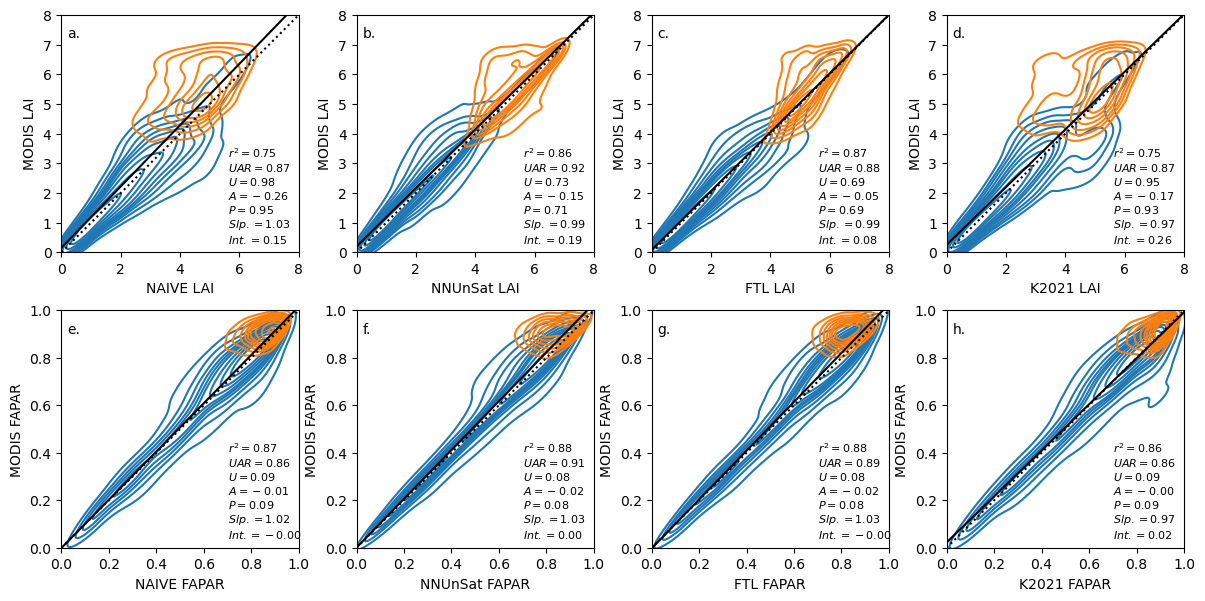

In [607]:
fig, ax = plt.subplots(nrows=2,ncols=4, figsize=(12,6))
fig.tight_layout(w_pad=0.75,h_pad=1.5)

deciles = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

response= 'LAI'
df = pd.DataFrame()
for biome in [1,2,3,4,5,6,7,8]:
    df = pd.concat([df,valbiomeDictLAI[biome]['DF'].sample(1000)])
df[response] = df[response]/10


# method='NAIVEUnSat'
# df[method+response] = df[method+response] / 10
# method2 = 'NAIVESat'
# df[method2+response] = df[method2+response] / 10
# df.loc[df['predSatFlag']==1 ,method+response] = df.loc[df['predSatFlag']==1,method2+response]
method='NAIVE'
df[method+response] = df[method+response] / 10
f0 = sns.kdeplot(df,ax=ax[0,0],x=method+response,y=response,hue="LUT_satFlag",legend=False,levels=deciles)
ax[0,0].set(xlabel=method+' '+response, ylabel='MODIS LAI')
r = LinearRegression().fit(np.array(df[method+response]).reshape(-1, 1) ,df[response])
slope = r.coef_[0]
offset = r.intercept_
rscore=r.score(np.array(df[method+response]).reshape(-1, 1) ,df[response])
residual = np.array(df[method+response]-df[response])
A = np.mean(residual)
U= np.sqrt(np.mean(np.power(residual,2)))
P = np.sqrt(np.mean(np.power(np.array(slope * np.array(df[method+response])+offset-df[response]),2)))
UAR = np.mean(residual<np.maximum(0.15*np.array(df[response]),0.5))
textstr1 = 'a.'   
textstr2 = '\n'.join((
    r'$r^2=%.2f$' % (rscore, ),
    r'$UAR=%.2f$' % (UAR, ),    
    r'$U=%.2f$' % (U, ),
    r'$A=%.2f$' % (A, ),
    r'$P=%.2f$' % (P, ),
    r'$Slp.=%.2f$' % (slope, ),
    r'$Int.=%.2f$' % (offset, )))
ax[0,0].set_xlim(0,8)
ax[0,0].set_ylim(0,8)
ax[0,0].set_box_aspect(1)
ax[0,0].plot([0,8],[offset,8*slope+offset],'k')
ax[0,0].plot([0,8],[0,8],':k')
ax[0,0].text(0.025, 0.95, textstr1, transform=ax[0,0].transAxes, fontsize=10,verticalalignment='top',color='k')
ax[0,0].text(0.7, 0.45, textstr2, transform=ax[0,0].transAxes, fontsize=8,verticalalignment='top',color='k')

method='NNUnSat'
df[method+response] = df[method+response] / 10
method2 = 'NNSat'
df[method2+response] = df[method2+response] / 10
df.loc[df['LUT_satFlag']==1 ,method+response] = df.loc[df['LUT_satFlag']==1,method2+response]
f0 = sns.kdeplot(df,ax=ax[0,1],x=method+response,y=response,hue="LUT_satFlag",legend=False,levels=deciles)
ax[0,1].set(xlabel=method+' '+response, ylabel='MODIS LAI')
r = LinearRegression().fit(np.array(df[method+response]).reshape(-1, 1) ,df[response])
slope = r.coef_[0]
offset = r.intercept_
rscore=r.score(np.array(df[method+response]).reshape(-1, 1) ,df[response])
residual = np.array(df[method+response]-df[response])
A = np.mean(residual)
U= np.sqrt(np.mean(np.power(residual,2)))
P = np.sqrt(np.mean(np.power(np.array(slope * np.array(df[method+response])+offset-df[response]),2)))
UAR = np.mean(residual<np.maximum(0.15*np.array(df[response]),0.5))
textstr1 = 'b.'   
textstr2 = '\n'.join((
    r'$r^2=%.2f$' % (rscore, ),
    r'$UAR=%.2f$' % (UAR, ),    
    r'$U=%.2f$' % (U, ),
    r'$A=%.2f$' % (A, ),
    r'$P=%.2f$' % (P, ),
    r'$Slp.=%.2f$' % (slope, ),
    r'$Int.=%.2f$' % (offset, )))
ax[0,1].set_xlim(0,8)
ax[0,1].set_ylim(0,8)
ax[0,1].set_box_aspect(1)
ax[0,1].plot([0,8],[offset,8*slope+offset],'k')
ax[0,1].plot([0,8],[0,8],':k')
ax[0,1].text(0.025, 0.95, textstr1, transform=ax[0,1].transAxes, fontsize=10,verticalalignment='top',color='k')
ax[0,1].text(0.7, 0.45, textstr2, transform=ax[0,1].transAxes, fontsize=8,verticalalignment='top',color='k')


method='FTL'
df[method+response] = df[method+response] / 10
method2 = 'FTLSat'
df[method2+response] = df[method2+response] / 10
df.loc[df['LUT_satFlag']==1 ,method+response] = df.loc[df['LUT_satFlag']==1,method2+response]
# method='FTL'
# df[method+response] = df[method+response] / 10
f0 = sns.kdeplot(df,ax=ax[0,2],x=method+response,y=response,hue="LUT_satFlag",legend=False,levels=deciles)
ax[0,2].set(xlabel='FTL'+' '+response, ylabel='MODIS LAI')
r = LinearRegression().fit(np.array(df[method+response]).reshape(-1, 1) ,df[response])
slope = r.coef_[0]
offset = r.intercept_
rscore=r.score(np.array(df[method+response]).reshape(-1, 1) ,df[response])
residual = np.array(df[method+response]-df[response])
A = np.mean(residual)
U= np.sqrt(np.mean(np.power(residual,2)))
P = np.sqrt(np.mean(np.power(np.array(slope * np.array(df[method+response])+offset-df[response]),2)))
UAR = np.mean(residual<np.maximum(0.15*np.array(df[response]),0.5))
textstr1 = 'c.'   
textstr2 = '\n'.join((
    r'$r^2=%.2f$' % (rscore, ),
    r'$UAR=%.2f$' % (UAR, ),    
    r'$U=%.2f$' % (U, ),
    r'$A=%.2f$' % (A, ),
    r'$P=%.2f$' % (P, ),
    r'$Slp.=%.2f$' % (slope, ),
    r'$Int.=%.2f$' % (offset, )))
ax[0,2].set_xlim(0,8)
ax[0,2].set_ylim(0,8)
ax[0,2].set_box_aspect(1)
ax[0,2].plot([0,8],[offset,8*slope+offset],'k')
ax[0,2].plot([0,8],[0,8],':k')
ax[0,2].text(0.025, 0.95, textstr1, transform=ax[0,2].transAxes, fontsize=10,verticalalignment='top',color='k')
ax[0,2].text(0.7, 0.45, textstr2, transform=ax[0,2].transAxes, fontsize=8,verticalalignment='top',color='k')

method='KANG'
df[method+response] = df[method+response] / 10
f0 = sns.kdeplot(df,ax=ax[0,3],x=method+response,y=response,hue="LUT_satFlag",legend=False,levels=deciles)
ax[0,3].set(xlabel='K2021'+' '+response, ylabel='MODIS LAI')
r = LinearRegression().fit(np.array(df[method+response]).reshape(-1, 1) ,df[response])
slope = r.coef_[0]
offset = r.intercept_
rscore=r.score(np.array(df[method+response]).reshape(-1, 1) ,df[response])
residual = np.array(df[method+response]-df[response])
A = np.mean(residual)
U= np.sqrt(np.mean(np.power(residual,2)))
P = np.sqrt(np.mean(np.power(np.array(slope * np.array(df[method+response])+offset-df[response]),2)))
UAR = np.mean(residual<np.maximum(0.15*np.array(df[response]),0.5))
textstr1 = 'd.'   
textstr2 = '\n'.join((
    r'$r^2=%.2f$' % (rscore, ),
    r'$UAR=%.2f$' % (UAR, ),    
    r'$U=%.2f$' % (U, ),
    r'$A=%.2f$' % (A, ),
    r'$P=%.2f$' % (P, ),
    r'$Slp.=%.2f$' % (slope, ),
    r'$Int.=%.2f$' % (offset, )))
ax[0,3].set_xlim(0,8)
ax[0,3].set_ylim(0,8)
ax[0,3].set_box_aspect(1)
ax[0,3].plot([0,8],[offset,8*slope+offset],'k')
ax[0,3].plot([0,8],[0,8],':k')
ax[0,3].text(0.025, 0.95, textstr1, transform=ax[0,3].transAxes, fontsize=10,verticalalignment='top',color='k')
ax[0,3].text(0.7, 0.45, textstr2, transform=ax[0,3].transAxes, fontsize=8,verticalalignment='top',color='k')


response = 'FAPAR'
df = pd.DataFrame()
for biome in [1,2,4,6,7]:
    df = pd.concat([df,valbiomeDictFAPAR[biome]['DF'].sample(1000)])
df[response] = df[response]/100

# method='NAIVEUnSat'
# df[method+response] = df[method+response] / 100
# method2 = 'NAIVESat'
# df[method2+response] = df[method2+response] / 100
# df.loc[df['predSatFlag']==1 ,method+response] = df.loc[df['predSatFlag']==1,method2+response]
method='NAIVE'
df[method+response] = df[method+response] / 100
f0 = sns.kdeplot(df,ax=ax[1,0],x=method+response,y=response,hue="LUT_satFlag",legend=False,levels=deciles)
ax[1,0].set(xlabel=method+' '+response, ylabel='MODIS FAPAR')
r = LinearRegression().fit(np.array(df[method+response]).reshape(-1, 1) ,df[response])
slope = r.coef_[0]
offset = r.intercept_
rscore=r.score(np.array(df[method+response]).reshape(-1, 1) ,df[response])
residual = np.array(df[method+response]-df[response])
A = np.mean(residual)
U= np.sqrt(np.mean(np.power(residual,2)))
P = np.sqrt(np.mean(np.power(np.array(slope * np.array(df[method+response])+offset-df[response]),2)))
UAR = np.mean(residual<np.maximum(0.1*np.array(df[response]),0.05))
textstr1 = 'e.'   
textstr2 = '\n'.join((
    r'$r^2=%.2f$' % (rscore, ),
    r'$UAR=%.2f$' % (UAR, ),    
    r'$U=%.2f$' % (U, ),
    r'$A=%.2f$' % (A, ),
    r'$P=%.2f$' % (P, ),
    r'$Slp.=%.2f$' % (slope, ),
    r'$Int.=%.2f$' % (offset, )))
ax[1,0].set_xlim(0,1)
ax[1,0].set_ylim(0,1)
ax[1,0].set_box_aspect(1)
ax[1,0].plot([0,1],[offset,1*slope+offset],'k')
ax[1,0].plot([0,1],[0,1],':k')
ax[1,0].text(0.025, 0.95, textstr1, transform=ax[1,0].transAxes, fontsize=10,verticalalignment='top',color='k')
ax[1,0].text(0.7, 0.45, textstr2, transform=ax[1,0].transAxes, fontsize=8,verticalalignment='top',color='k')

method='NNUnSat'
df[method+response] = df[method+response] / 100
method2 = 'NNSat'
df[method2+response] = df[method2+response] / 100
f0 = sns.kdeplot(df,ax=ax[1,1],x=method+response,y=response,hue="LUT_satFlag",legend=False,levels=deciles)
ax[1,1].set(xlabel=method+' '+response, ylabel='MODIS FAPAR')
r = LinearRegression().fit(np.array(df[method+response]).reshape(-1, 1) ,df[response])
slope = r.coef_[0]
offset = r.intercept_
rscore=r.score(np.array(df[method+response]).reshape(-1, 1) ,df[response])
residual = np.array(df[method+response]-df[response])
A = np.mean(residual)
U= np.sqrt(np.mean(np.power(residual,2)))
P = np.sqrt(np.mean(np.power(np.array(slope * np.array(df[method+response])+offset-df[response]),2)))
UAR = np.mean(residual<np.maximum(0.1*np.array(df[response]),0.05))
textstr1 = 'f.'   
textstr2 = '\n'.join((
    r'$r^2=%.2f$' % (rscore, ),
    r'$UAR=%.2f$' % (UAR, ),    
    r'$U=%.2f$' % (U, ),
    r'$A=%.2f$' % (A, ),
    r'$P=%.2f$' % (P, ),
    r'$Slp.=%.2f$' % (slope, ),
    r'$Int.=%.2f$' % (offset, )))
ax[1,1].set_xlim(0,1)
ax[1,1].set_ylim(0,1)
ax[1,1].set_box_aspect(1)
ax[1,1].plot([0,1],[offset,1*slope+offset],'k')
ax[1,1].plot([0,1],[0,1],':k')
ax[1,1].text(0.025, 0.95, textstr1, transform=ax[1,1].transAxes, fontsize=10,verticalalignment='top',color='k')
ax[1,1].text(0.7, 0.45, textstr2, transform=ax[1,1].transAxes, fontsize=8,verticalalignment='top',color='k')


method='FTL'
df[method+response] = df[method+response] / 100
method2 = 'FTLSat'
df[method2+response] = df[method2+response] / 100
df.loc[df['LUT_satFlag']==1 ,method+response] = df.loc[df['LUT_satFlag']==1,method2+response]
f0 = sns.kdeplot(df,ax=ax[1,2],x=method+response,y=response,hue="LUT_satFlag",legend=False,levels=deciles)
ax[1,2].set(xlabel=method+' '+response, ylabel='MODIS FAPAR')
r = LinearRegression().fit(np.array(df[method+response]).reshape(-1, 1) ,df[response])
slope = r.coef_[0]
offset = r.intercept_
rscore=r.score(np.array(df[method+response]).reshape(-1, 1) ,df[response])
residual = np.array(df[method+response]-df[response])
A = np.mean(residual)
U= np.sqrt(np.mean(np.power(residual,2)))
P = np.sqrt(np.mean(np.power(np.array(slope * np.array(df[method+response])+offset-df[response]),2)))
UAR = np.mean(residual<np.maximum(0.1*np.array(df[response]),0.05))
textstr1 = 'g.'   
textstr2 = '\n'.join((
    r'$r^2=%.2f$' % (rscore, ),
    r'$UAR=%.2f$' % (UAR, ),    
    r'$U=%.2f$' % (U, ),
    r'$A=%.2f$' % (A, ),
    r'$P=%.2f$' % (P, ),
    r'$Slp.=%.2f$' % (slope, ),
    r'$Int.=%.2f$' % (offset, )))
ax[1,2].set_xlim(0,1)
ax[1,2].set_ylim(0,1)
ax[1,2].set_box_aspect(1)
ax[1,2].plot([0,1],[offset,1*slope+offset],'k')
ax[1,2].plot([0,1],[0,1],':k')
ax[1,2].text(0.025, 0.95, textstr1, transform=ax[1,2].transAxes, fontsize=10,verticalalignment='top',color='k')
ax[1,2].text(0.7, 0.45, textstr2, transform=ax[1,2].transAxes, fontsize=8,verticalalignment='top',color='k')

method='KANG'
df[method+response] = df[method+response] / 100
f0 = sns.kdeplot(df,ax=ax[1,3],x=method+response,y=response,hue="LUT_satFlag",legend=False,levels=deciles)
ax[1,3].set(xlabel='K2021'+' '+response, ylabel='MODIS FAPAR')
r = LinearRegression().fit(np.array(df[method+response]).reshape(-1, 1) ,df[response])
slope = r.coef_[0]
offset = r.intercept_
rscore=r.score(np.array(df[method+response]).reshape(-1, 1) ,df[response])
residual = np.array(df[method+response]-df[response])
A = np.mean(residual)
U= np.sqrt(np.mean(np.power(residual,2)))
P = np.sqrt(np.mean(np.power(np.array(slope * np.array(df[method+response])+offset-df[response]),2)))
UAR = np.mean(residual<np.maximum(0.1*np.array(df[response]),0.05))
textstr1 = 'h.'   
textstr2 = '\n'.join((
    r'$r^2=%.2f$' % (rscore, ),
    r'$UAR=%.2f$' % (UAR, ),    
    r'$U=%.2f$' % (U, ),
    r'$A=%.2f$' % (A, ),
    r'$P=%.2f$' % (P, ),
    r'$Slp.=%.2f$' % (slope, ),
    r'$Int.=%.2f$' % (offset, )))
ax[1,3].set_xlim(0,1)
ax[1,3].set_ylim(0,1)
ax[1,3].set_box_aspect(1)
ax[1,3].plot([0,1],[offset,1*slope+offset],'k')
ax[1,3].plot([0,1],[0,1],':k')
ax[1,3].text(0.025, 0.95, textstr1, transform=ax[1,3].transAxes, fontsize=10,verticalalignment='top',color='k')
ax[1,3].text(0.7, 0.45, textstr2, transform=ax[1,3].transAxes, fontsize=8,verticalalignment='top',color='k')


plt.savefig('Figure6.png', bbox_inches='tight')

Figure 6.  Bi-variate distributions of estimates versus reference LAI (upper row) and FAPAR (lower row), for (a., c.) NAIVE, (b., d.) FTL, and (c.,e.) K2021 methoods.  Unsaturated and staurated reference values indicated by blue and gold contours respectivelys.  Contour intervals corresponds to quantiles from 0.1 to 1.0 in increments of 0.1.  Contour intervals corresponds to quantiles from 0.1 to 1.0 in increments of 0.1.  Solid black line corresponds to ordinary least squares regression fit with slope (Slp.) and intercept (int.) indicated.

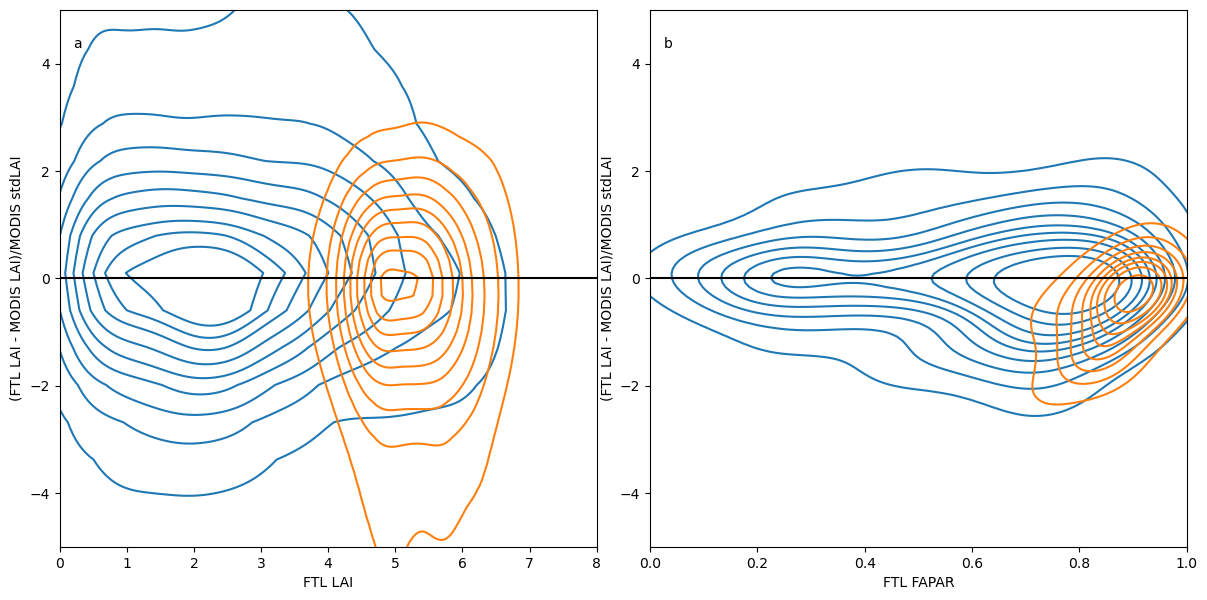

In [227]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(12,6))
fig.tight_layout(w_pad=0.75,h_pad=1.5)

deciles = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

response= 'LAI'
df = pd.DataFrame()
for biome in [1,2,3,4,5,6,7,8]:
    df = pd.concat([df,valbiomeDictLAI[biome]['DF'].sample(1000)])
df[response] = df[response]/10
df['std'+response] =  df['std'+response]/10



method='FTL'
df[method+response] = df[method+response] / 10
method2 = 'FTLSat'
df[method2+response] = df[method2+response] / 10
df.loc[df['LUT_satFlag']==1 ,method+response] = df.loc[df['LUT_satFlag']==1,method2+response]
df[method+response+'residual']= df[method+response]-df[response]
df[method+response+'residualdivstd'] = df[method+response+'residual'] / (df['std'+response].clip(lower=.05))

f0 = sns.kdeplot(df,ax=ax[0],x=method+response,y=method+response+'residualdivstd',hue="LUT_satFlag",legend=False,levels=deciles)
ax[0].set(xlabel=method+' '+response, ylabel='('+method +' LAI - MODIS LAI)/MODIS stdLAI')
ax[0].set_xlim(0,8)
ax[0].set_ylim(-5,5)
ax[0].set_box_aspect(1)
ax[0].plot([0,8],[0,0],'k')
ax[0].text(0.025, 0.95, 'a', transform=ax[0].transAxes, fontsize=10,verticalalignment='top',color='k')



response = 'FAPAR'
df = pd.DataFrame()
for biome in [1,2,4,6,7]:
    df = pd.concat([df,valbiomeDictFAPAR[biome]['DF'].sample(100)])
df[response] = df[response]/100
df['std'+response] =  df['std'+response]/100



method='FTL'
df[method+response] = df[method+response] / 100
method2 = 'FTLSat'
df[method2+response] = df[method2+response] / 100
df.loc[df['predSatFlag']==1 ,method+response] = df.loc[df['predSatFlag']==1,method2+response]
df[method+response+'residual']= df[method+response]-df[response]
df[method+response+'residualdivstd'] = df[method+response+'residual'] / (df['std'+response].clip(lower=.05))




method='FTL'
f0 = sns.kdeplot(df,ax=ax[1],x=method+response,y=method+response+'residualdivstd',hue="LUT_satFlag",legend=False,levels=deciles)
ax[1].set(xlabel=method+' '+response, ylabel='('+method +' LAI - MODIS LAI)/MODIS stdLAI')
ax[1].set_xlim(0,1)
ax[1].set_ylim(-5,5)
ax[1].set_box_aspect(1)
ax[1].plot([0,1],[0,0],'k')
ax[1].text(0.025, 0.95, 'b', transform=ax[1].transAxes, fontsize=10,verticalalignment='top',color='k')



plt.savefig('Figure7.png', bbox_inches='tight')

Figure 7.  Bi-variate distributions of estimate variable versus the ratio of residual to the standard deviation of te reference value for LAI (upper row) and FAPAR (lower row), for (a., c.) NAIVE, (b., d.) FTL, and (c.,e.) K2021 methoods. Unsaturated and staurated reference values indicated by blue and gold contours respectivelys.  Contour intervals corresponds to quantiles from 0.1 to 1.0 in increments of 0.1.  

Figure 8.  A,P,U curves for each method and variable.

In [576]:
# plots accuracy precision and uncertainty curves based on residuals by fitting a polynomial of specified degree
def plotSummaryStats(x,y,err,axis,degree):

    from sklearn.preprocessing import PolynomialFeatures
    from scipy import stats

    xinds = x.argsort()
    x = x[xinds[::-1]]
    y = y[xinds[::-1]]

    poly = PolynomialFeatures(degree = degree)
    xp = poly.fit_transform(x.reshape(-1,1))
    accSummary = sm.WLS(y, xp, err ** (-2)).fit().get_prediction(xp) .summary_frame(alpha=0.05)
    pre = abs(y-np.array(accSummary['mean']))
    preSummary = sm.WLS(pre, xp, err ** (-2)).fit().get_prediction(xp) .summary_frame(alpha=0.05)
    unc = abs(y)
    # print(sm.WLS(y, xp, err ** (-2)).fit().summary())
    # print(sm.WLS(pre, xp, err ** (-2)).fit().summary())

    uncSummary = sm.WLS(unc, xp, err ** (-2)).fit().get_prediction(xp) .summary_frame(alpha=0.05)
    axis.plot(x, accSummary['mean'], color='darkgreen', label='Accuracy')
    axis.plot(x, accSummary['mean_ci_upper'], color='darkgreen',linewidth=0.5,linestyle='--')
    axis.plot(x, accSummary['mean_ci_lower'],color='darkgreen',linewidth=0.5,linestyle='--')
    axis.plot(x, preSummary['mean'], color='darkorange', label='Precision')
    axis.plot(x, preSummary['mean_ci_upper'], color='darkorange',linewidth=0.5,linestyle='--')
    axis.plot(x, preSummary['mean_ci_lower'],color='darkorange',linewidth=0.5,linestyle='--')
    axis.plot(x, uncSummary['mean'], color='royalblue', label='Uncertainty')
    axis.plot(x, uncSummary['mean_ci_upper'], color='royalblue',linewidth=0.5,linestyle='--')
    axis.plot(x, uncSummary['mean_ci_lower'],color='royalblue',linewidth=0.5,linestyle='--')
    

   
    return

KeyboardInterrupt: 

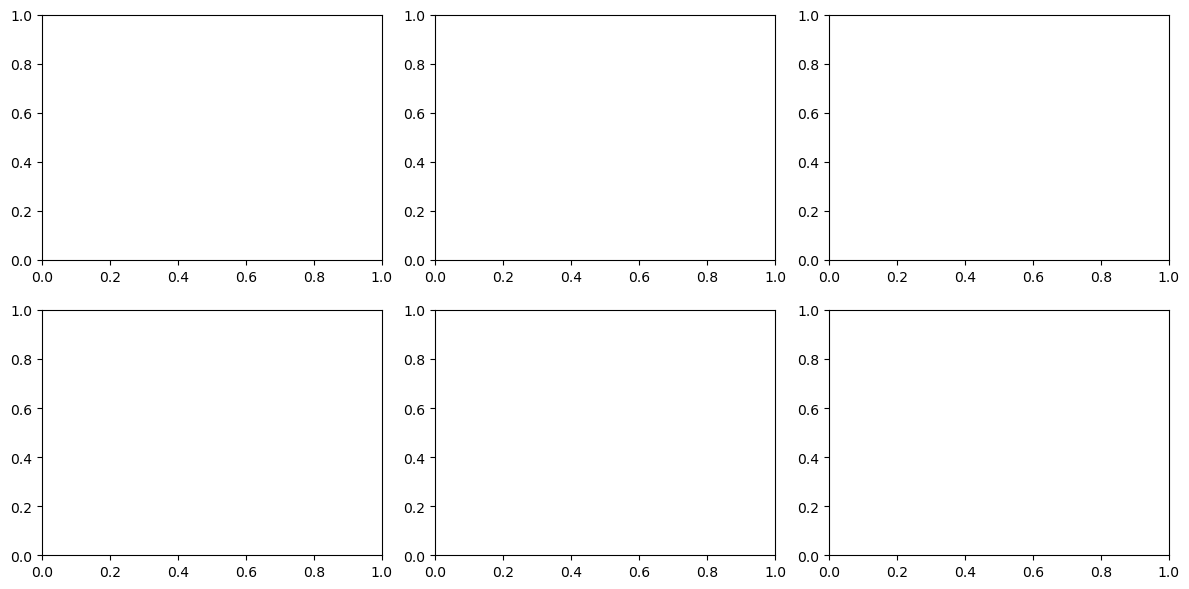

In [51]:
fig, ax = plt.subplots(nrows=2,ncols=3, figsize=(12,6))
fig.tight_layout(w_pad=0.75,h_pad=1.5)


response= 'LAI'
df = pd.DataFrame()
for biome in [1,2,3,4,5,6,7,8]:
    df = pd.concat([df,valbiomeDictLAI[biome]['DF'].sample(1000)])
df[response] = df[response]/10
df['std'+response] =  df['std'+response]/10

method='NAIVE'
df[method+response] = df[method+response]/10
df[method+response+'residual']= df[method+response]-df[response]
df[method+response+'residualabs'] = df[method+response+'residual'].abs()

method='KANG'
df[method+response] = df[method+response]/10
df[method+response+'residual']= df[method+response]-df[response]
df[method+response+'residualabs'] = df[method+response+'residual'].abs()

method='FTL'
df[method+response] = df[method+response]/10
df[method+response+'residual']= df[method+response]-df[response]
df[method+response+'residualabs'] = df[method+response+'residual'].abs()


method='NAIVE'
err = np.maximum(np.array(df['std'+response]),0.5)
x = np.array(df[method+response])
y = np.array(df[method+response+'residual'])
plotSummaryStats(x,y,err,ax[0,0],3)
# f0 = sns.jointplot(df,x=response,y=method+response+'residual',kind='kde',hue='LUT_satFlag',levels=deciles)
# f1 = sns.kdeplot(df,ax=ax[0,0],x=response,y=method+response+'residualabs',hue="LUT_satFlag",legend=False,levels=deciles)
# ax[0,0].set(xlabel=response, ylabel='('+method +' LAI - MODIS LAI)/MODIS stdLAI')
# ax[0,0].set_xlim(0,8)
# ax[0,0].set_ylim(-5,5)
# ax[0,0].set_box_aspect(1)
# ax[0,0].plot([0,1],[0,0],'k')
# ax[0,0].text(0.025, 0.95, 'a', transform=ax[0,0].transAxes, fontsize=10,verticalalignment='top',color='k')

# method='FTL'
# f0 = sns.kdeplot(df,ax=ax[0,1],x=response,y=method+response+'residual',hue="LUT_satFlag",legend=False,levels=deciles,linestyle="--")
# f1 = sns.kdeplot(df,ax=ax[0,1],x=response,y=method+response+'residualabs',hue="LUT_satFlag",legend=False,levels=deciles)
# ax[0,1].set(xlabel=response, ylabel='('+method +' LAI - MODIS LAI)/MODIS stdLAI')
# ax[0,1].set_xlim(0,8)
# ax[0,1].set_ylim(-5,5)
# ax[0,1].set_box_aspect(1)
# ax[0,1].plot([0,1],[0,0],'k')
# ax[0,1].text(0.025, 0.95, 'b', transform=ax[0,1].transAxes, fontsize=10,verticalalignment='top',color='k')

# method='KANG'
# f0 = sns.kdeplot(df,ax=ax[0,2],x=response,y=method+response+'residual',hue="LUT_satFlag",legend=False,levels=deciles,linestyle="--")
# f1 = sns.kdeplot(df,ax=ax[0,2],x=response,y=method+response+'residualabs',hue="LUT_satFlag",legend=False,levels=deciles)
# ax[0,2].set(xlabel=response, ylabel='('+'K2021' +' LAI - MODIS LAI)/MODIS stdLAI')
# ax[0,2].set_xlim(0,8)
# ax[0,2].set_ylim(-5,5)
# ax[0,2].set_box_aspect(1)
# ax[0,2].plot([0,1],[0,0],'k')
# ax[0,2].text(0.025, 0.95, 'c', transform=ax[0,2].transAxes, fontsize=10,verticalalignment='top',color='k')


# response = 'FAPAR'
# df = pd.DataFrame()
# for biome in [1,2,3,4,5,6,7,8]:
#     df = pd.concat([df,valbiomeDictFAPAR[biome]['DF'].sample(100)])
# df[response] = df[response]/100
# df['std'+response] =  df['std'+response]/100

# method='NAIVE'
# df[method+response] = df[method+response]/100
# df[method+response+'residual']= df[method+response]-df[response]
# df[method+response+'residualabs'] = df[method+response+'residual'].abs()

# method='KANG'
# df[method+response] = df[method+response]/100
# df[method+response+'residual']= df[method+response]-df[response]
# df[method+response+'residualabs'] = df[method+response+'residual'].abs()

# method='FTL'
# df[method+response] = df[method+response]/100
# df[method+response+'residual']= df[method+response]-df[response]
# df[method+response+'residualabs'] = df[method+response+'residual'].abs()

# method='NAIVE'
# f0 = sns.kdeplot(df,ax=ax[1,0],x=response,y=method+response+'residual',hue="LUT_satFlag",legend=False,levels=deciles,linestyle="--")
# f1 = sns.kdeplot(df,ax=ax[1,0],x=response,y=method+response+'residualabs',hue="LUT_satFlag",legend=False,levels=deciles)
# ax[1,0].set(xlabel=response, ylabel='('+'K2021' +' LAI - MODIS LAI)/MODIS stdLAI')
# ax[1,0].set_xlim(0,1)
# ax[1,0].set_ylim(-.1,.1)
# ax[1,0].set_box_aspect(1)
# ax[1,0].plot([0,1],[0,0],'k')
# ax[1,0].text(0.025, 0.95, 'd', transform=ax[1,0].transAxes, fontsize=10,verticalalignment='top',color='k')

# method='FTL'
# f0 = sns.kdeplot(df,ax=ax[1,1],x=response,y=method+response+'residual',hue="LUT_satFlag",legend=False,levels=deciles,linestyle="--")
# f1 = sns.kdeplot(df,ax=ax[1,1],x=response,y=method+response+'residualabs',hue="LUT_satFlag",legend=False,levels=deciles)
# ax[1,1].set(xlabel=response, ylabel='('+method +' LAI - MODIS LAI)/MODIS stdLAI')
# ax[1,1].set_xlim(0,1)
# ax[1,1].set_ylim(-.1,.1)
# ax[1,1].set_box_aspect(1)
# ax[1,1].plot([0,1],[0,0],'k')
# ax[1,1].text(0.025, 0.95, 'e', transform=ax[1,1].transAxes, fontsize=10,verticalalignment='top',color='k')

# method='KANG'
# f0 = sns.kdeplot(df,ax=ax[1,2],x=response,y=method+response+'residual',hue="LUT_satFlag",legend=False,levels=deciles, linestyle="--")
# f1 = sns.kdeplot(df,ax=ax[1,2],x=response,y=method+response+'residualabs',hue="LUT_satFlag",legend=False,levels=deciles)
# ax[1,2].set(xlabel=response, ylabel='('+method +' LAI - MODIS LAI)/MODIS stdLAI')
# ax[1,2].set_xlim(0,1)
# ax[1,2].set_ylim(-.1,.1)
# ax[1,2].set_box_aspect(1)
# ax[1,2].plot([0,1],[0,0],'k')
# ax[1,2].text(0.025, 0.95, 'f', transform=ax[1,2].transAxes, fontsize=10,verticalalignment='top',color='k')

# plt.savefig('Figure8.png', bbox_inches='tight')

### Direct Validation

In [577]:
# apply a RF to
def applyRF(x,bands,bandNames,orderedregressors,predictor):
    df = pd.DataFrame.from_records(x) 
    df = (df.loc[df['bandName'].isin(bands)]['data'].values)
    df = pd.DataFrame(list(map(list, zip(*df))),columns=bandNames)
    df = df.rename(columns={'longitude': 'Lon', 'latitude': 'Lat'})
    df[['red','NIR','SWIR1']] =  df[['red','NIR','SWIR1']].mul(2.75e-05).sub(0.02).mul(10000)
    df[['cosVZA','cosSZA','cosSA']] = df[['cosVZA','cosSZA','cosSA']].add(-10000)
    df['NDVI'] = np.clip(((df.loc[:,"NIR"])-(df.loc[:,"red"]))/np.maximum(((df.loc[:,"NIR"])+(df.loc[:,"red"])),.0001),0,+1)
    df['NDWI'] = np.clip(((df.loc[:,"SWIR1"])-(df.loc[:,"red"]))/np.maximum(((df.loc[:,"SWIR1"])+(df.loc[:,"red"])),.0001),0,+1)
    if len(df) > 0 :
        return predictor.predict(df[orderedregressors]).tolist()
    else:
        return  ([])
    
    return 

In [578]:
# apply a RF to
def applyRFDF(x,bands,bandNames,orderedregressors,predictor):
    df = pd.DataFrame.from_records(x) 
    df = (df.loc[df['bandName'].isin(bands)]['data'].values)
    df = pd.DataFrame(list(map(list, zip(*df))),columns=bandNames)
    df = df.rename(columns={'longitude': 'Lon', 'latitude': 'Lat'})
    df[['red','NIR','SWIR1']] =  df[['red','NIR','SWIR1']].mul(2.75e-05).sub(0.02).mul(10000)
    df[['cosVZA','cosSZA','cosSA']] = df[['cosVZA','cosSZA','cosSA']].add(-10000)
    df['NDVI'] = np.clip(((df.loc[:,"NIR"])-(df.loc[:,"red"]))/np.maximum(((df.loc[:,"NIR"])+(df.loc[:,"red"])),.0001),0,+1)
    df['NDWI'] = np.clip(((df.loc[:,"SWIR1"])-(df.loc[:,"red"]))/np.maximum(((df.loc[:,"SWIR1"])+(df.loc[:,"red"])),.0001),0,+1)
    if len(df) > 0 :
        df['estimate'] = predictor.predict(df[orderedregressors]).tolist()
    else:
        df['estimate']
    
    return df

In [579]:
# renames columns of in-situ validation samples to standard names
def renameColumns(siteDF) :
    if 'GBOV' in siteDF.name:   
        siteDF['network'] = 'GBOV'
        siteDF['fNeedleleaf'] = 0 
        siteDF.loc[siteDF['IGBP_class'] == 'Mixed Forest']['fNeedleleaf']=0.5
        siteDF.loc[siteDF['IGBP_class'] == 'Evergreen Needleleaf']['fNeedleleaf']=1
        siteDF['fBroadleaf']=  1 - siteDF['fNeedleleaf']

        
        newNames = {'Site': 'Site', \
                        'FCOVER_down': 'fCOVER_down', \
                        'FCOVER_up': 'fCOVER_up', \
                        'FCOVER_down_err': 'fCOVER_down_err', \
                        'FCOVER_up_err': 'fCOVER_up_err', \
                        'FIPAR_down': 'fAPAR_down', \
                        'FIPAR_up': 'fAPAR_up', \
                        'FIPAR_down_err': 'fAPAR_down_err', \
                        'FIPAR_up_err': 'fAPAR_up_err', \
                        'LAI_Warren_up': 'PAI_up', \
                        'LAI_Warren_down': 'PAI_down', \
                        'LAIe_Warren_up': 'PAIe_up', \
                        'LAIe_Warren_down': 'PAIe_down', \
                        'LAIe_Miller_up': 'PAIe_Miller_up', \
                        'LAIe_Miller_down': 'PAIe_Miller_down', \
                        'LAI_Warren_up_err': 'PAI_up_err', \
                        'LAI_Warren_down_err': 'PAI_down_err', \
                        'LAIe_Warren_up_err': 'PAIe_up_err', \
                        'LAIe_Warren_down_err': 'PAIe_down_err', \
                        'LAIe_Miller_up_err': 'PAIe_Miller_up_err', \
                        'LAIe_Miller_down_err': 'PAIe_Miller_down_err'} 
    elif 'CCRS' in siteDF.name:
        list(siteDF)
        siteDF['network'] = 'CCRS'
        siteDF['IGBP_class'] = 'Mixed Forest'
        siteDF.loc[siteDF['BF']>0.75,'IGBP_class'] = 'Deciduous Broadleaf'
        siteDF.loc[siteDF['BF']<0.25,'IGBP_class'] = 'Evergreen Needleleaf'
        newNames = {'Location': 'Site', \
                    'BF' : 'fBroadleaf' , \
                    'NF': 'fNeedleleaf' , \
                    'fcover_Down': 'fCOVER_down', \
                    'fcover_Up': 'fCOVER_up', \
                    'fcoverstd_Down': 'fCOVER_down_err', \
                    'fcoverstd_Up': 'fCOVER_up_err', \
                    'Daily_Integrated_Black_Sk_yfAPAR_Down': 'fAPAR_down', \
                    'Daily_Integrated_Black_Sk_yfAPAR_Up': 'fAPAR_up' , \
                    'Daily_Integrated_Black_Sky_fAPAR_Down': 'fAPAR_down', \
                    'Daily_Integrated_Black_Sky_fAPAR_Up': 'fAPAR_up' , \
                    'PAICEV61_Up': 'PAI_up', \
                    'PAICEV61_Down': 'PAI_down', \
                    'PAIeCEV61_Up': 'PAIe_up', \
                    'PAIeCEV61_Down':'PAIe_down', \
                    'PAIEMiller_Up': 'PAIe_Miller_up', \
                    'PAIEMiller_Down':'PAIe_Miller_down', \
                    'Woody_Fraction_average':'WAItoPAIratio', \
                    'Woody_Fraction_std': 'WAItoPAIratio_std'} 
        

    return  siteDF.rename(columns = newNames)

In [580]:
# produce estimates of each variable
# read in field data
with open("c:/users/rfernand/modisLandsat/BRF15dDictionary30mfil30msam45mbufV2.pkl", "rb") as fp:   #Pickling
    valDictin =  pickle.load(fp)

In [586]:
# valDict = valDictin
#apping between IGBP class and modis biome number, note 11=mixed forest
biomeDict = { 'Croplands': 3, 'Grasslands': 1, 'Open Shrublands': 2 , \
              'Mixed Forest': 11,'Evergreen Broadleaf': 5, 'Evergreen Needleleaf':7 ,\
             'Closed Shrublands':2 ,'Deciduous Broadleaf':6, ' Deciduous Broadleaf':6, 'Cropland Mosaics': 3 }

# iterate over dictionary of sites
for siteName in valDict.keys():
    #only LAI
    if ('RM6' not in siteName):
        print(siteName)
        # iterate over all ESU samples for this site
        # each sample is a list of matched dates with surface reflectance
        for index,sample in enumerate(valDict[siteName]): 
            print("\r"+str(index),end="")
            if 'CCRS' in siteName:
                valDict[siteName][index]['biome'] = 11 # mixed forest
            else:
                # GBOV
                valDict[siteName][index]['biome'] = biomeDict[sample['IGBP_class']]
                #if mixed forest we default NF=BF=0.5
                if valDict[siteName][index]['biome'] == 11:
                    valDict[siteName][index]['NF'] = 0.5
                    valDict[siteName][index]['BF'] = 0.5
            
            #apply single predictor except for mixed forest where we use weighted predicton
            biome = valDict[siteName][index]['biome']
            if ( biome <11 ) :

                #NAIVE
                regressors = ['red','NIR','SWIR1','cosVZA','cosSZA','cosSA']
                regressorsNames =  ['SR_B4','SR_B5','SR_B6','cosVZA','cosSZA','cosSA']
                orderedregressors = ['red','NIR','cosSZA','cosVZA','cosSA']
                predictor = calbiomeDictLAINAIVE[biome]['NAIVELAIregression']
                estimate = applyRF(sample['sampleSurface_Reflectance'],regressorsNames,regressors,orderedregressors,predictor)
                valDict[siteName][index]['sampleSurface_Reflectance'].append( {'bandName': 'sampleLAINAIVE', 'data':estimate})
                # predictor = calbiomeDictFAPARNAIVE[biome]['NAIVEFAPARregression']
                # estimate = applyRF(sample['sampleSurface_Reflectance'],regressorsNames,regressors,orderedregressors,predictor)
                # valDict[siteName][index]['sampleSurface_Reflectance'].append( {'bandName': 'sampleFAPARNAIVE', 'data':estimate})

                #KANG
                regressors =  ['red','NIR','SWIR1','cosVZA','cosSZA','cosSA','longitude','latitude']
                regressorsNames =  ['SR_B4','SR_B5','SR_B6','cosVZA','cosSZA','cosSA','longitude','latitude']
                orderedregressors =  ['red','NIR','SWIR1','NDVI','NDWI','Lat','Lon','cosSZA','cosSA']
                predictor = calbiomeDictLAIKANG[biome]['KANGLAIregression']
                estimate = applyRF(sample['sampleSurface_Reflectance'],regressorsNames,regressors,orderedregressors,predictor)
                valDict[siteName][index]['sampleSurface_Reflectance'].append( {'bandName': 'sampleLAIKANG', 'data':estimate})
                # predictor = calbiomeDictFAPARKANG[biome]['KANGFAPARregression']
                # estimate = applyRF(sample['sampleSurface_Reflectance'],regressorsNames,regressors,orderedregressors,predictor)
                # valDict[siteName][index]['sampleSurface_Reflectance'].append( {'bandName': 'sampleFAPARKANG', 'data':estimate})

                                #KANGNOGEO
                regressors =  ['red','NIR','SWIR1','cosVZA','cosSZA','cosSA','longitude','latitude']
                regressorsNames =  ['SR_B4','SR_B5','SR_B6','cosVZA','cosSZA','cosSA','longitude','latitude']
                orderedregressors =  ['red','NIR','SWIR1','NDVI','NDWI','cosSZA','cosSA']
                predictor = calbiomeDictLAIKANG[biome]['KANGNOGEOLAIregression']
                estimate = applyRF(sample['sampleSurface_Reflectance'],regressorsNames,regressors,orderedregressors,predictor)
                valDict[siteName][index]['sampleSurface_Reflectance'].append( {'bandName': 'sampleLAIKANGNOGEO', 'data':estimate})
                # predictor = calbiomeDictFAPARKANG[biome]['KANGFAPARregression']
                # estimate = applyRF(sample['sampleSurface_Reflectance'],regressorsNames,regressors,orderedregressors,predictor)
                # valDict[siteName][index]['sampleSurface_Reflectance'].append( {'bandName': 'sampleFAPARKANG', 'data':estimate})

                
            else:

                biome=7
                #NAIVE
                regressors = ['red','NIR','SWIR1','cosVZA','cosSZA','cosSA']
                regressorsNames =  ['SR_B4','SR_B5','SR_B6','cosVZA','cosSZA','cosSA']
                orderedregressors = ['red','NIR','cosSZA','cosVZA','cosSA']
                predictor = calbiomeDictLAINAIVE[biome]['NAIVELAIregression']
                estimate = applyRF(sample['sampleSurface_Reflectance'],regressorsNames,regressors,orderedregressors,predictor)
                valDict[siteName][index]['sampleSurface_Reflectance'].append( {'bandName': 'sampleLAINAIVE', 'data':estimate})
                # predictor = calbiomeDictFAPARNAIVE[biome]['NAIVEFAPARregression']
                # estimate = applyRF(sample['sampleSurface_Reflectance'],regressorsNames,regressors,orderedregressors,predictor)
                # valDict[siteName][index]['sampleSurface_Reflectance'].append( {'bandName': 'sampleFAPARNAIVE', 'data':estimate})

                #KANG
                regressors =  ['red','NIR','SWIR1','cosVZA','cosSZA','cosSA','longitude','latitude']
                regressorsNames =  ['SR_B4','SR_B5','SR_B6','cosVZA','cosSZA','cosSA','longitude','latitude']
                orderedregressors =  ['red','NIR','SWIR1','NDVI','NDWI','Lat','Lon','cosSZA','cosSA']
                predictor = calbiomeDictLAIKANG[biome]['KANGLAIregression']
                estimate = applyRF(sample['sampleSurface_Reflectance'],regressorsNames,regressors,orderedregressors,predictor)
                valDict[siteName][index]['sampleSurface_Reflectance'].append( {'bandName': 'sampleLAIKANG', 'data':estimate})
                # predictor = calbiomeDictFAPARKANG[biome]['KANGFAPARregression']
                # estimate = applyRF(sample['sampleSurface_Reflectance'],regressorsNames,regressors,orderedregressors,predictor)
                # valDict[siteName][index]['sampleSurface_Reflectance'].append( {'bandName': 'sampleFAPARKANG', 'data':estimate})

                              #KANGNOGEO
                regressors =  ['red','NIR','SWIR1','cosVZA','cosSZA','cosSA','longitude','latitude']
                regressorsNames =  ['SR_B4','SR_B5','SR_B6','cosVZA','cosSZA','cosSA','longitude','latitude']
                orderedregressors =  ['red','NIR','SWIR1','NDVI','NDWI','cosSZA','cosSA']
                predictor = calbiomeDictLAIKANG[biome]['KANGNOGEOLAIregression']
                estimate = applyRF(sample['sampleSurface_Reflectance'],regressorsNames,regressors,orderedregressors,predictor)
                valDict[siteName][index]['sampleSurface_Reflectance'].append( {'bandName': 'sampleLAIKANGNOGEO', 'data':estimate})
                # predictor = calbiomeDictFAPARKANG[biome]['KANGFAPARregression']
                # estimate = applyRF(sample['sampleSurface_Reflectance'],regressorsNames,regressors,orderedregressors,predictor)
                # valDict[siteName][index]['sampleSurface_Reflectance'].append( {'bandName': 'sampleFAPARKANG', 'data':estimate})


projects/ee-modis250/assets/validationGBOV/COPERNICUS_GBOV_RM7_20220616174529
1795projects/ee-modis250/assets/validationCCRS/CCRSInSituLAI2019_HayRiverv3
26projects/ee-modis250/assets/validationCCRS/CCRSInSituLAI2019_Labradorv3
8projects/ee-modis250/assets/validationCCRS/CCRSInSituLAI2019_MerBleuv3
1projects/ee-modis250/assets/validationCCRS/CCRSInSituLAI2019_MtPolleyv3
4projects/ee-modis250/assets/validationCCRS/CCRSInSituLAI2019_PeaceRiverv3
7projects/ee-modis250/assets/validationCCRS/CCRSInSituLAI2019_TurkeyPointv3
2projects/ee-modis250/assets/validationCCRS/CCRSInSituLAI2019_VancouverIslandv3
5projects/ee-modis250/assets/validationCCRS/CCRSInSituLAI2019_Yellowknifev3
9projects/ee-modis250/assets/validationCCRS/CCRSInSituLAI2020_RingOfFirev3
56projects/ee-modis250/assets/validationCCRS/CCRSInSituLAI2021_NovaScotiav3
27

In [115]:
# save sampled match ups to pickel binary files
with open("c:/users/rfernand/modisLandsat/BRF15dDictionary30mfil30msam45mbufV2estimate.pkl", "wb") as fp:   #Pickling
    pickle.dump(valDict,fp)

In [116]:
# parameters for validation figures and  statistics 
sampleLAIFileName = "c:/users/rfernand/modisLandsat/BRF15dDictionary30mfil30msam45mbufV2estimate.pkl"
# samplefCOVERFileName = "/home/richard_fernandes/validation/fCOVER7dDictionary0mfil20msam30mbuf.pkl"
# samplefAPARFileName = "/home/richard_fernandes/validation/fAPAR7dDictionary0mfil20msam30mbuf.pkl"

# siteFileName = "/home/richard_fernandes/validation/siteSummaries.csv"
variableName = "LAI"
sites_North_America = ['Barrow','BartlettExperimentalForest','BlandyExperimentalFarm','Bondville','Boulder','CentralPlainsExperimentalRange','DeadLake','DesertRock','DesMoines','DisneyWildernessPreserve','DukeForest', \
                        'FortPeck','GoodwinCreek','GuanicaForest','HarvardForest','ImnavaitCreek','JonesEcologicalResearchCenter','Jornada','KonazPrairieBiologicalStation','LajasExperimentalStation','Manhattan','Moab', \
                       'NiwotRidgeForest','NiwotRidgeMountainResearchStation','NorthSterling','OakRidge','OnaquiAult','OrdwaySwisherBiologicalStation','RockSprings','SantaBarbara','SantaRita','SiouxFallsSurfRad',\
                       'SiousFallsUscrn','SmithsonianConservationBiologyInstitute','SmithsonianEnvironmentalResearchCenter','SouthernGreatPlains','StiegerwaldtLandServices','TableMountan',\
                       'TalladegaNationalForest','TonziRanch','Underc','WalnutGulchKendall','Williams','Woodworth','YosemiteVillage', \
                        'Geraldton2020', 'HayRiver2019' ,'Labrador2019' ,'Merbleue2019','MtPolley2019','PeaceRiver2019' ,'TurkeyPoint2019' ,'VancouverIsland2019','YellowKnife2019', 'NovaScotia2021']
treed_IGBP_class = ['Evergreen Broadleaf', 'Evergreen Needleleaf', 'Mixed Forest','Deciduous Broadleaf','Closed Shrublands','Open Shrublands']


In [151]:
siteList = valDict["projects/ee-modis250/assets/validationGBOV/COPERNICUS_GBOV_RM7_20220616174529"]
bands=['sampleLAINAIVE','sampleLAIKANG']
df = pd.DataFrame.from_records(siteList[0]['sampleSurface_Reflectance']).drop_duplicates(subset='bandName')
df = (df.loc[df['bandName'].isin(bands)]['data'].values)
df = pd.DataFrame(list(map(list, zip(*df))),columns=bands)

print(df)


            bandName                                               data
0              SR_B1  [7766, 7725, 7738, 7781, 7737, 7782, 7785, 786...
1              SR_B2  [7883, 7852, 7874, 7899, 7866, 7946, 7957, 791...
2              SR_B3  [8880, 8895, 8911, 8931, 8933, 9016, 9019, 893...
3              SR_B4  [8226, 8182, 8247, 8347, 8335, 8524, 8558, 818...
4              SR_B5  [18066, 18327, 18014, 17407, 17416, 17317, 168...
5              SR_B6  [12796, 12421, 12259, 12265, 12377, 12915, 131...
6              SR_B7  [9516, 9340, 9361, 9440, 9443, 9809, 10001, 93...
7      SR_QA_AEROSOL  [160, 160, 160, 160, 130, 160, 160, 160, 160, ...
8             ST_B10  [47275, 47280, 47287, 47350, 47351, 47367, 473...
9           ST_ATRAN  [4861, 4861, 4861, 4861, 4861, 4861, 4861, 519...
10          ST_CDIST  [42, 42, 42, 45, 45, 45, 48, 18, 18, 18, 21, 2...
11           ST_DRAD  [1910, 1910, 1910, 1910, 1910, 1910, 1910, 175...
12           ST_EMIS  [9853, 9852, 9850, 9846, 9843, 9839, 9841,

In [319]:
print(valbiomeDictLAI[7]['DF']['cosVZA'])

14876544    9945.218954
42403753    9902.680687
6510702     9925.461516
12897292    9925.461516
53979619    9993.908270
               ...     
24447402    9961.946981
25590486    9986.295348
39510968    9945.218954
18690701    9986.295348
53846553    9993.908270
Name: cosVZA, Length: 10000, dtype: float64


In [239]:
# defined overstory woody to total plant are ratio based on land cover 
def estimateWAItoPAIratio(samplesDF) :
    #estimate overstory woody to total area ratio for GBOV sites
    # use initial fixed ratio for all sites based on shrubs
    samplesDF.loc[(samplesDF['network'] == 'GBOV') ,'WAItoPAIratio'] = 0.10
    samplesDF.loc[(samplesDF['network'] == 'GBOV') ,'WAItoPAIratio_std'] = 0.11

    # use fixed ratio for needeleaf sites
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Evergreen Needleleaf'),'WAItoPAIratio'] = 0.16
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Evergreen Needleleaf'),'WAItoPAIratio_std'] = 0.10   
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Deciduous Needleleaf'),'WAItoPAIratio'] = 0.16
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Deciduous Needleleaf'),'WAItoPAIratio_std'] = 0.10  

    # use fixed ratio for  broadleaf sites
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Evergreen Broadleaf'),'WAItoPAIratio'] = 0.24
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Evergreen Broadleaf'),'WAItoPAIratio_std'] = 0.11
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Deciduous Broadleaf'),'WAItoPAIratio'] = 0.24
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Deciduous Broadleaf'),'WAItoPAIratio_std'] = 0.11


    # use fixed ratio for mixed forest
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Mixed Forest'),'WAItoPAIratio'] = 0.18
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Mixed Forest'),'WAItoPAIratio_std'] = 0.11

    # fix some transcription errors in WAI to PAI ratio for CCRS
    samplesDF['WAItoPAIratio'] = samplesDF['WAItoPAIratio'].clip(lower=0.1,upper=0.24)
    samplesDF['WAItoPAIratio_std'] = samplesDF['WAItoPAIratio_std'].clip(lower=0.1,upper=0.11)
    return (samplesDF)

In [243]:
# parses a file of matchups to create dataframe woth required entries for validation statistics and figures
def parseSampleFile(sampleFileName,dataName,variableName):

# clumping uncertainty
    clumping_err = 0.025
    WAItoPAIdown= 0.1
    
    with open(sampleFileName, "rb") as fp:   #Pickling
        sampleDictionary = pickle.load(fp)
    # remove GBOV records without variable being validated
    if ( variableName == 'LAI') :
        del sampleDictionary['projects/ee-modis250/assets/validationGBOV/COPERNICUS_GBOV_RM6_20220616174529']
    elif ( variableName == 'fAPAR') :
        del sampleDictionary['projects/ee-modis250/assets/validationGBOV/COPERNICUS_GBOV_RM7_20220616174529']
    sitesList = sampleDictionary.keys()


    samplesDF = pd.DataFrame();
    for key in sitesList:

        #convert list to pandas data frame, rename columns, filter for North America
        siteDF = pd.concat([pd.DataFrame(sampleDictionary[key]),pd.DataFrame([key] * len(sampleDictionary[key]),columns=['geeFeatureCollection'])],axis=1)
        siteDF.name = key
        siteDF = renameColumns(siteDF)
        siteDF = siteDF[siteDF['IGBP_class'].isin(treed_IGBP_class)]
        siteDF = siteDF[siteDF['Site'].isin(sites_North_America)].reset_index()
        #number of samples and number valid samples
        numValid = []
        numSamples = []      
        for index,site in siteDF.iterrows():
            siteQC = site['sample'+dataName][28]['data']
            numSamples.append(len(siteQC))
            numValid.append(len(siteQC) - np.count_nonzero(siteQC))
        numSamplesDF= pd.DataFrame(numSamples,columns=['numSamples'])
        numValidDF = pd.DataFrame(numValid,columns=['numValid'])
        siteDF = pd.concat([siteDF,numSamplesDF, numValidDF],axis=1)
        samplesDF = pd.concat([samplesDF,siteDF],axis=0,ignore_index=True)
    
    samplesDF = samplesDF.reset_index(drop=True)
    if variableName == 'LAI' :
        
        
        samplesDF[['PAI_up','PAI_down','PAIe_up','PAIe_down','PAI_up_err','PAI_down_err','PAIe_up_err','PAIe_down_err']] = samplesDF[['PAI_up','PAI_down','PAIe_up','PAIe_down','PAI_up_err','PAI_down_err','PAIe_up_err','PAIe_down_err']].apply(pd.to_numeric)
        samplesDF = samplesDF.replace(-999, 0)

        # gap fill estimates of insitu error for CCRS
        samplesDF.loc[samplesDF['network'] == 'CCRS','PAIe_up_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','PAIe_up'].mul(0.04830027).add(0.002163865830433743)
        samplesDF.loc[samplesDF['network'] == 'CCRS','PAIe_down_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','PAIe_down'].mul(0.04830027).add(0.002163865830433743)        
        samplesDF.loc[samplesDF['network'] == 'CCRS','PAI_up_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','PAI_up'].mul(0.04480655).add(0.010224858872736227)
        samplesDF.loc[samplesDF['network'] == 'CCRS','PAI_down_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','PAI_down'].mul(0.04480655).add(0.010224858872736227)

        
        samplesDF['percentValid'] = samplesDF['numValid'].div(samplesDF['numSamples'])
        
        # add error due to uncertainty in clumping
        samplesDF['PAI_up_err_clumping'] = samplesDF['PAI_up'].mul(samplesDF['PAI_up'].div((samplesDF['PAIe_up']).add(0.0001)).mul(clumping_err))
        samplesDF['PAI_up_err'] = samplesDF['PAI_up_err'].pow(2).add(samplesDF['PAI_up_err_clumping'].pow(2)).pow(0.5)
        samplesDF['PAI_down_err_clumping'] = samplesDF['PAI_down'].mul(samplesDF['PAI_down'].div((samplesDF['PAIe_down']).add(0.0001)).mul(clumping_err))
        samplesDF['PAI_down_err'] = samplesDF['PAI_down_err'].pow(2).add(samplesDF['PAI_down_err_clumping'].pow(2)).pow(0.5)

        #compute total canopy values including woody area
        samplesDF['PAI_total'] = samplesDF['PAI_up'].add(samplesDF['PAI_down']) 
        samplesDF['PAI_total_err'] = samplesDF['PAI_up_err'].pow(2).add(samplesDF['PAI_down_err'].pow(2)).pow(0.5)
        samplesDF['PAIe_total'] = samplesDF['PAIe_up'].add(samplesDF['PAIe_down']) 
        samplesDF['PAIe_total_err'] = samplesDF['PAIe_up_err'].pow(2).add(samplesDF['PAIe_down_err'].pow(2)).pow(0.5)
        samplesDF['clumping_total'] = samplesDF['PAIe_total'].div(samplesDF['PAI_total'] ) 
        samplesDF['clumping_total_err']  = (2 * clumping_err  * clumping_err) ** (0.5)          
         #compute total canopy values depending to removing woddy area
        samplesDF = estimateWAItoPAIratio(samplesDF)
        samplesDF['LAI_up'] = samplesDF['PAI_up'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['LAI_up_err'] = samplesDF['PAI_up_err'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['LAI_down'] = samplesDF['PAI_down'] * ( 1 - WAItoPAIdown)
        samplesDF['LAI_down_err'] = samplesDF['PAI_down_err'] * ( 1 - WAItoPAIdown)
        samplesDF['LAI_total'] = samplesDF['LAI_up'] + samplesDF['LAI_down']
        samplesDF['LAI_total_err'] = samplesDF['LAI_down_err'].pow(2).add(samplesDF['LAI_up_err'].pow(2)).pow(0.5)                                                                           
        samplesDF['LAIe_up'] = samplesDF['PAIe_up'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['LAIe_up_err'] = samplesDF['PAIe_up_err'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['LAIe_down'] = samplesDF['PAIe_down'] * ( 1 - WAItoPAIdown)
        samplesDF['LAIe_down_err'] = samplesDF['PAIe_down_err'] * ( 1 - WAItoPAIdown)
        samplesDF['LAIe_total'] = samplesDF['LAIe_up'] + samplesDF['LAIe_down']
        samplesDF['LAIe_total_err'] = samplesDF['LAIe_down_err'].pow(2).add(samplesDF['LAIe_up_err'].pow(2)).add(samplesDF['LAI_up'].mul(samplesDF['LAI_up'].mul(samplesDF['WAItoPAIratio_std'])).pow(2)).pow(0.5)                                                             
    elif variableName == 'fCOVER' :
        samplesDF.loc[[729],'fCOVER_down']=0
        samplesDF.loc[[730],'fCOVER_down_err']=0
        samplesDF = estimateWAItoPAIratio(samplesDF)
        samplesDF[['fCOVER_up','fCOVER_down','fCOVER_up_err','fCOVER_down_err']] = samplesDF[['fCOVER_up','fCOVER_down','fCOVER_up_err','fCOVER_down_err']].apply(pd.to_numeric)
        samplesDF = samplesDF.replace(-999, 0)
        samplesDF['percentValid'] = samplesDF['numValid'] / samplesDF['numSamples']
        samplesDF['fCOVER_up'] = samplesDF['fCOVER_up'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['fCOVER_down'] = samplesDF['fCOVER_down'] * ( 1 - WAItoPAIdown)
        samplesDF['fCOVER_total'] = samplesDF['fCOVER_up'].add((samplesDF['fCOVER_up'].mul(-1).add(1)).mul(samplesDF['fCOVER_down'] ))
        samplesDF['fCOVER_total_err'] = samplesDF['fCOVER_down_err'].pow(2).add(samplesDF['fCOVER_up_err'].pow(2)).add(samplesDF['fCOVER_up'].mul(samplesDF['fCOVER_up'].mul(samplesDF['WAItoPAIratio_std'])).pow(2)).pow(0.5)  
    elif  variableName == 'fAPAR' :
        samplesDF = estimateWAItoPAIratio(samplesDF)
        samplesDF[['fAPAR_up','fAPAR_down','fAPAR_up_err','fAPAR_down_err']] = samplesDF[['fAPAR_up','fAPAR_down','fAPAR_up_err','fAPAR_down_err']].apply(pd.to_numeric)
        samplesDF = samplesDF.replace(-999, 0)
        samplesDF['fAPAR_up'] = samplesDF['fAPAR_up'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['fAPAR_down'] = samplesDF['fAPAR_down'] * ( 1 - WAItoPAIdown)
        samplesDF['percentValid'] = samplesDF['numValid'] / samplesDF['numSamples']
        samplesDF['fAPAR_total'] = samplesDF['fAPAR_up'].add((samplesDF['fAPAR_up'].mul(-1).add(1)).mul(samplesDF['fAPAR_down'] ))
        # gap fill estimates of insitu error for CCRS
        samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_up_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_up'].add(-0.5).abs().mul(-0.08437372).add(0.04791396358018562).mul(samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_up']).div(samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_total'])
        samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_down_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_down'].add(-0.5).abs().mul(-0.08437372).add(0.04791396358018562).mul(samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_down']).div(samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_total'])
        samplesDF['fAPAR_total_err'] = samplesDF['fAPAR_down_err'].pow(2).add(samplesDF['fAPAR_up_err'].pow(2)).add(samplesDF['fAPAR_up'].mul(samplesDF['fAPAR_up'].mul(samplesDF['WAItoPAIratio_std'])).pow(2)).pow(0.5)  
    else :
        print('variable not found')
              
    return(samplesDF)
                        

In [278]:
# compute residuals
def summaryStats(samplesDF,samplesLAIDF,xvariable,yvariable,trimquantile,minPAI,algorithmIndex,algorithmName):
    estimateMedian = [] 
    estimateSTD = [] 
    medianError = [] 
    estimateCount = [] 
    samplesDF = samplesDF.join(samplesLAIDF[samplesLAIDF.columns.difference(samplesDF.columns)])
    samplesDF = pd.concat([samplesDF.loc[samplesDF['network']=='CCRS'],samplesDF.loc[(samplesDF['PAI_total']>minPAI) & (samplesDF['network']=='GBOV')]],axis=0)
    for index, sample in samplesDF.iterrows():
        reference = sample[yvariable]
        qc = np.array(sample['sample'+xvariable][algorithmIndex]['data'])*0
        estimate = np.array(sample['sample'+xvariable][algorithmIndex]['data'])/10
        error = np.array(sample['sample'+xvariable][algorithmIndex]['data'])*0
        productDF = pd.DataFrame(list(zip(qc,estimate,error)),columns=['qc','estimate','error'])
        productDF = productDF.loc[productDF['qc']==0]
        if productDF.shape[0]>0 :
            productDF['absresidual'] = (productDF['estimate'] - reference).abs()
            quantileResidual = productDF['absresidual'].quantile(trimquantile/100,interpolation='nearest')
            estimateMedian.append(productDF.loc[productDF['absresidual']==quantileResidual]['estimate'].mean())
            estimateSTD.append(productDF.loc[productDF['absresidual']<=quantileResidual,['estimate']].std().divide((productDF.loc[productDF['absresidual']<=quantileResidual].shape[0]) ** (0.5)))
            medianError.append(productDF.loc[productDF['absresidual']==quantileResidual]['error'].median())
            estimateCount.append(productDF.loc[productDF['absresidual']<=quantileResidual].shape[0])
        else:
            estimateMedian.append(nan)
            estimateSTD.append(nan)
            medianError.append(nan)
            estimateCount.append(0)
    samplesDF[algorithmName+'_'+yvariable+'_estimate'] = estimateMedian
    samplesDF[algorithmName+'_'+yvariable+'_estimate_std'] = estimateSTD 
    samplesDF[algorithmName+'_'+yvariable+'_err_estimate_mean'] = medianError
    samplesDF[algorithmName+'_'+yvariable+'_estimate_count'] = estimateCount
    return(samplesDF)

In [511]:
samplesLAIDF0 = parseSampleFile(sampleLAIFileName,'Surface_Reflectance','LAI')

In [416]:
print(samplesLAIDF0.loc[0]['sampleSurface_Reflectance'][0])

{'bandName': 'SR_B1', 'data': [7766, 7725, 7738, 7781, 7737, 7782, 7785, 7862, 7846, 7802, 7757, 7710, 7771, 7790]}


In [512]:
samplesLAIDF0_PAI1 = summaryStats(samplesLAIDF0,samplesLAIDF0,'Surface_Reflectance','PAI_total',p,0.01,30,'LAIKANG').reset_index(drop=True) 

In [513]:
samplesLAIDF0_PAI2 = summaryStats(samplesLAIDF0_PAI1,samplesLAIDF0_PAI1,'Surface_Reflectance','PAI_total',p,0.01,28
                                  ,'LAINAIVE').reset_index(drop=True) 

In [500]:
rf = export_text(calbiomeDictLAIKANG[7]['KANGLAIregression'].estimators_[0],max_depth=20)
print(rf,file=open('tree.txt', 'w'))

In [498]:
regressors =  ['red','NIR','SWIR1','cosVZA','cosSZA','cosSA','longitude','latitude']
regressorsNames =  ['SR_B4','SR_B5','SR_B6','cosVZA','cosSZA','cosSA','longitude','latitude']
orderedregressors =  ['red','NIR','SWIR1','NDVI','NDWI','Lat','Lon','cosSZA','cosSA']
# orderedregressors =  ['red','NIR','cosSZA','cosVZA','cosSA']
predictor = calbiomeDictLAIKANG[7]['KANGLAIregression'].estimators_[0]
for index,sample in enumerate(valDict['projects/ee-modis250/assets/validationCCRS/CCRSInSituLAI2019_TurkeyPointv3']): 


# dfTL = samplesLAIDF0_PAI2.loc[samplesLAIDF0_PAI2['Site']=='TurkeyPoint2019' ]
# red = ((np.array(dfTL.iloc[0]['sampleSurface_Reflectance'][3]['data']) * 2.75e-05) - 0.02) * 10000
# NIR = ((np.array(dfTL.iloc[0]['sampleSurface_Reflectance'][4]['data']) * 2.75e-05) - 0.02) * 10000
# SWIR1 = ((np.array(dfTL.iloc[0]['sampleSurface_Reflectance'][5]['data']) * 2.75e-05) - 0.02) * 10000
# NDVI = np.clip((NIR-red)/np.maximum((NIR+red),.0001),0,+1)
# NDWI = np.clip((NIR-SWIR1)/np.maximum((NIR+SWIR1),.0001),0,+1)

    estimate = applyRFDF(sample['sampleSurface_Reflectance'],regressorsNames,regressors,orderedregressors,predictor)
    print(list(estimate))
    print(estimate[orderedregressors+['estimate']])
# print(red)
# print(NIR)
# print(SWIR1)
# print(NDVI)
# print(NDWI)
# print(np.array(dfTL.iloc[0]['sampleSurface_Reflectance'][21]['data'])-10000)
# print(np.array(dfTL.iloc[0]['sampleSurface_Reflectance'][25]['data'])-10000)
# print(dfTL.iloc[0]['sampleSurface_Reflectance'][26]['data'])
# print(dfTL.iloc[0]['sampleSurface_Reflectance'][27]['data'])
# print(dfTL.iloc[0]['LAIKANG_PAI_total_estimate'])


['red', 'NIR', 'SWIR1', 'cosVZA', 'cosSZA', 'cosSA', 'Lon', 'Lat', 'NDVI', 'NDWI', 'estimate']
         red       NIR     SWIR1      NDVI      NDWI        Lat        Lon  \
0   2185.900  4834.700  3354.650  0.377290  0.210945  42.705135 -80.359929   
1   2222.750  4839.375  3429.450  0.370515  0.213492  42.705133 -80.359563   
2   2169.950  5162.225  3462.175  0.408102  0.229438  42.705407 -80.360292   
3   2181.500  4667.225  3303.775  0.362947  0.204598  42.705405 -80.359926   
4   2188.375  4734.325  3322.475  0.367768  0.205794  42.705403 -80.359560   
5   2205.700  4926.275  3452.825  0.381462  0.220398  42.705676 -80.359923   
6   2139.975  4942.225  3263.625  0.395675  0.207945  42.705673 -80.359557   
7   2122.650  4667.225  3359.875  0.374760  0.225667  42.705135 -80.359929   
8   2139.425  4806.100  3417.900  0.383941  0.230052  42.705133 -80.359563   
9   2093.500  5043.700  3434.400  0.413355  0.242570  42.705407 -80.360292   
10  2124.850  4457.950  3247.950  0.354424  0.2

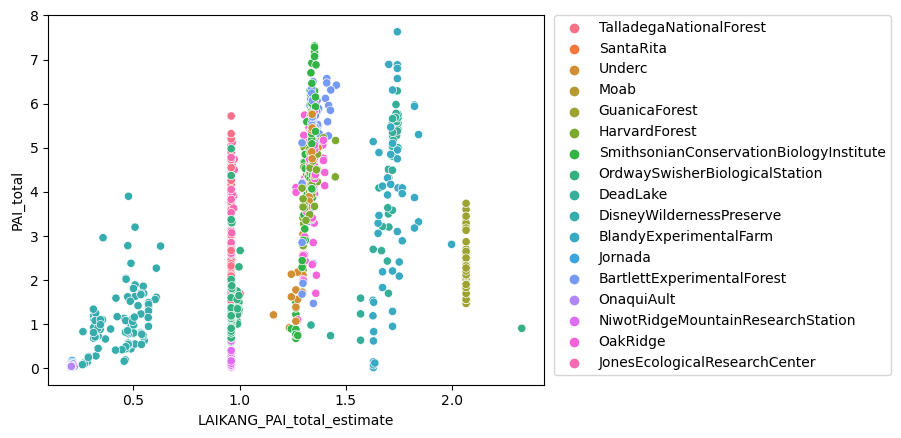

In [538]:
sns.scatterplot(samplesLAIDF_PAI2.loc[samplesLAIDF_PAI2['network']=='GBOV'],x='LAIKANG_PAI_total_estimate',y='PAI_total',hue='Site')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [134]:
# get summary stats after trimming quantiles of residuals to remove outliers due to poor matching
# we get stats for each quantile from 10 to 100%
samplesList = []

for p in range(10,110,10):
    print(p)
    df = parseSampleFile(sampleLAIFileName,'LAI')
    # samplesLAIDF = summaryStats(parseSampleFile(sampleLAIFileName,'LAI'),parseSampleFile(sampleLAIFileName,'LAI'),'LAI','PAIe_total',p,0.01).reset_index(drop=True) #.drop(['fCOVER_up','fCOVER_down','fAPAR_up','fAPAR_down','fCOVER_up_std','fCOVER_down_std','fAPAR_up_std','fAPAR_down_std'],axis=1)
#     samplesfAPARDF = summaryStats(parseSampleFile(samplefAPARFileName,'fAPAR'),parseSampleFile(sampleLAIFileName,'LAI'),'fAPAR','fAPAR_total',p,0.01).reset_index(drop=True) #.drop(['fAPAR_up','fAPAR_down','fAPAR_up_std','fAPAR_down_std'],axis=1)
#     samplesfCOVERDF = summaryStats(parseSampleFile(samplefCOVERFileName,'fCOVER'),parseSampleFile(sampleLAIFileName,'LAI'),'fCOVER','fCOVER_total',p,0.01).reset_index(drop=True)

#     samplesDF = samplesfAPARDF[['fAPAR_up','fAPAR_down','fAPAR_total','fAPAR_up_err','fAPAR_down_err','fAPAR_total_err','samplefAPAR','fAPAR_fAPAR_total_estimate','fAPAR_fAPAR_total_estimate_std','fAPAR_fAPAR_total_err_estimate_mean','fAPAR_fAPAR_total_estimate_count']] \
#                 .join(samplesfCOVERDF[['fCOVER_up','fCOVER_down','fCOVER_total','fCOVER_up_err','fCOVER_down_err','fCOVER_total_err','samplefCOVER','fCOVER_fCOVER_total_estimate','fCOVER_fCOVER_total_estimate_std','fCOVER_fCOVER_total_err_estimate_mean','fCOVER_fCOVER_total_estimate_count']])
    

#     samplesDF = samplesDF.join(samplesLAIDF[samplesLAIDF.columns.difference(samplesDF.columns)])
    
    # samplesDF = samplesLAIDF
    # samplesDF = samplesDF[samplesDF['LAI_PAIe_total_estimate_count']>0]
    # # samplesDF = samplesDF.dropna(subset='fAPAR_fAPAR_total_estimate')
    # samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_total_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_total_err'].mul(0.5) \
    #                                 .add(samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_total'].mul(samplesDF.loc[samplesDF['network'] == 'CCRS','fCOVER_total_err'].divide(samplesDF.loc[samplesDF['network'] == 'CCRS','fCOVER_total'])).mul(0.25))
    # samplesDF.loc[samplesDF['network'] == 'CCRS','LAI_total_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','LAI_total_err'].mul(0.5) \
    #                                 .add(samplesDF.loc[samplesDF['network'] == 'CCRS','LAI_total'].mul(samplesDF.loc[samplesDF['network'] == 'CCRS','fCOVER_total_err'].divide(samplesDF.loc[samplesDF['network'] == 'CCRS','fCOVER_total'])).mul(0.25))
    # samplesDF.loc[samplesDF['network'] == 'CCRS','LAIe_total_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','LAIe_total_err'].mul(0.5) \
    #                                 .add(samplesDF.loc[samplesDF['network'] == 'CCRS','LAIe_total'].mul(samplesDF.loc[samplesDF['network'] == 'CCRS','fCOVER_total_err'].divide(samplesDF.loc[samplesDF['network'] == 'CCRS','fCOVER_total'])).mul(0.25))
    # samplesDF = samplesDF.drop(samplesDF[samplesDF['Elevation'] > 3000].index)

    
    samplesList.append(samplesDF)


10


KeyError: 'bandName'

### Figure 8. COmparions of Accuracy , Precision and UNcetrainty of each method for (a) LAI ad b(FAPAR) using 3rd order polynoial fit fo residuals for all biomes.  

In [388]:
print(valDict['projects/ee-modis250/assets/validationCCRS/CCRSInSituLAI2019_MerBleuv3'][0]['sampleSurface_Reflectance'])

KeyError: 'projects/ee-modis250/assets/validationCCRS/CCRSInSituLAI2019_MerBleuv3'

In [288]:
siteDF.loc[siteDF['IGBP_class']==6,'test']=0
print(siteDF['test'])

0    0
1    1
Name: test, dtype: int64


Figure 8 . Cassidy, this should just be two panels (one LAI , onne fAPAR) where x axis is MCD15 LAI or FAPAR  and y axis is oredicted
versus MCD15 LAI or FAPAR.  Each panel should have 9 curves: 3 per method with one corresponding to accuracy, one to precision and one to uncertainty.  Accuracy is just  line fit to residuals.  Uncertaity is squrt of lie fit to squared residual  Precision is directly taken from Uncertainty^2 - Acccuracy^2.  You can use 3rd order polynomial fits


### Figure 9.  Kernel density controut plots of ratio of residual to MCD15 uncertainty for (a,b,c) LAI and (d,e,f) FAPAR for each method (columns) for validation database.


In [ ]:
Figure 9 - Cassidfy check my supplementary figures.  It should look like Fig 7 withput lines etc.

In [ ]:
### FIgure 10.  

Reading in all calibration data.

## Databases

### Samples for all biomes

https://drive.google.com/drive/folders/1jVKwxWPlH7nYnpL1yJAUD2jFkXV3A1kf?usp=share_link

In [ ]:
# Global sample using Richard sampling code
dfALL = pd.read_pickle('c:/users/rfernand/modisLandsat/code/MODISLANDSATall.pkl')

# Sample based on trimming for NAIVE (also used as a basis for FTL)
dfALLtrim = pd.read_pickle('c:/users/rfernand/modisLandsat/code/MODISLANDSATalltrim.pkl')

# Sample based on trimming for K2021
dfALLtrimKANG = pd.read_pickle('c:/users/rfernand/modisLandsat/code/MODISLANDSATalltrimKANG.pkl')




### Biome specific samples ready for use in RF predictors or for validation

https://drive.google.com/drive/folders/1jVKwxWPlH7nYnpL1yJAUD2jFkXV3A1kf?usp=share_link

In [30]:
# Validation data for LAI and FAPAR
valbiomeDictLAI = pd.read_pickle('c:/users/rfernand/modisLandsat/code/valbiomeDictLAI.pkl')
valbiomeDictFAPAR = pd.read_pickle('c:/users/rfernand/modisLandsat/code/valbiomeDictFAPAR.pkl')

# Calibration data for LAI and FAPAR
calbiomeDictLAI = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictLAI.pkl')
calbiomeDictFAPAR = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictFAPAR.pkl')

# Kang's calibration data for LAI and FAPAR
calbiomeDictLAIKANG = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictLAIKANGv2.pkl')
calbiomeDictFAPARKANG = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictFAPARKANGv2.pkl')

# FTL  calibration data for LAI and FAPAR
calbiomeDictLAIFTL= pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictLAIFTL.pkl')
calbiomeDictFAPARFTL = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictFAPARFTL.pkl')

# https://drive.google.com/drive/folders/1jVKwxWPlH7nYnpL1yJAUD2jFkXV3A1kf?usp=share_link

## Supplementary Figures

In [ ]:
# Validation data for LAI and FAPAR
valbiomeDictLAI = pd.read_pickle('c:/users/rfernand/modisLandsat/code/valbiomeDictLAI.pkl')
valbiomeDictFAPAR = pd.read_pickle('c:/users/rfernand/modisLandsat/code/valbiomeDictFAPAR.pkl')

# Calibration data for LAI and FAPAR
calbiomeDictLAI = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictLAI.pkl')
calbiomeDictFAPAR = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictFAPAR.pkl')

# Kang's calibration data for LAI and FAPAR
calbiomeDictLAIKANG = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictLAIKANG.pkl')
calbiomeDictFAPARKANG = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictFAPARKANG.pkl')

# FTL  calibration data for LAI and FAPAR
calbiomeDictLAIFTL= pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictLAIFTL.pkl')
calbiomeDictFAPARFTL = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictFAPARFTL.pkl')

# https://drive.google.com/drive/folders/1jVKwxWPlH7nYnpL1yJAUD2jFkXV3A1kf?usp=share_link

In [ ]:
method = 'NAIVE'
response= 'LAI'
df = pd.DataFrame()
# fig, axs = plt.subplots(nrows=1,ncols=1,sharey=True,figsize=(10,20))
for biome in [1,2,3,4,5,6,7,8]:
    df = pd.concat([df,valbiomeDictLAI[biome]['DF']])
    df[method+response+'residual']= df[method+response]-df[response]
    df[method+response+'residualdivstd'] = df[method+response+'residual'] / (df['stdLAI'].clip(lower=5))
    print(np.sqrt(np.average(np.power(np.array(df.loc[df[method+response]>4][method+response+'residual']),2))))

f0 = sns.displot(df,x=method+response,y=response,hue="LUT_satFlag",legend=False,col='LC_type3',kind='kde',col_wrap=4)
for ax in f0.axes:
    ax.plot([0,100],[0,100])
    ax.set_xlim([0,100])
    ax.set_ylim([0,100])    

# f1 = sns.displot(df,x=response,y=method+response+'residual',hue="LUT_satFlag",legend=False,col='LC_type3',kind='kde',col_wrap=4)
# for ax in f1.axes:
#     ax.plot([0,100],[0,0])
#     ax.set_xlim([0,100])
#     ax.set_ylim([-40,40])  
    
# f2 = sns.displot(df,x=response,y=method+response+'residualdivstd',hue="LUT_satFlag",legend=False,col='LC_type3',kind='kde',col_wrap=4)
# for ax in f2.axes:
#     ax.plot([0,100],[0,0])
#     ax.set_xlim([0,100])
#     ax.set_ylim([-10,10])  

11.223018975198846
8.913366730684956
9.694054220659341
9.885373718027097
10.092947809629198
9.72163488398668
9.700341438498311
9.577382436818702


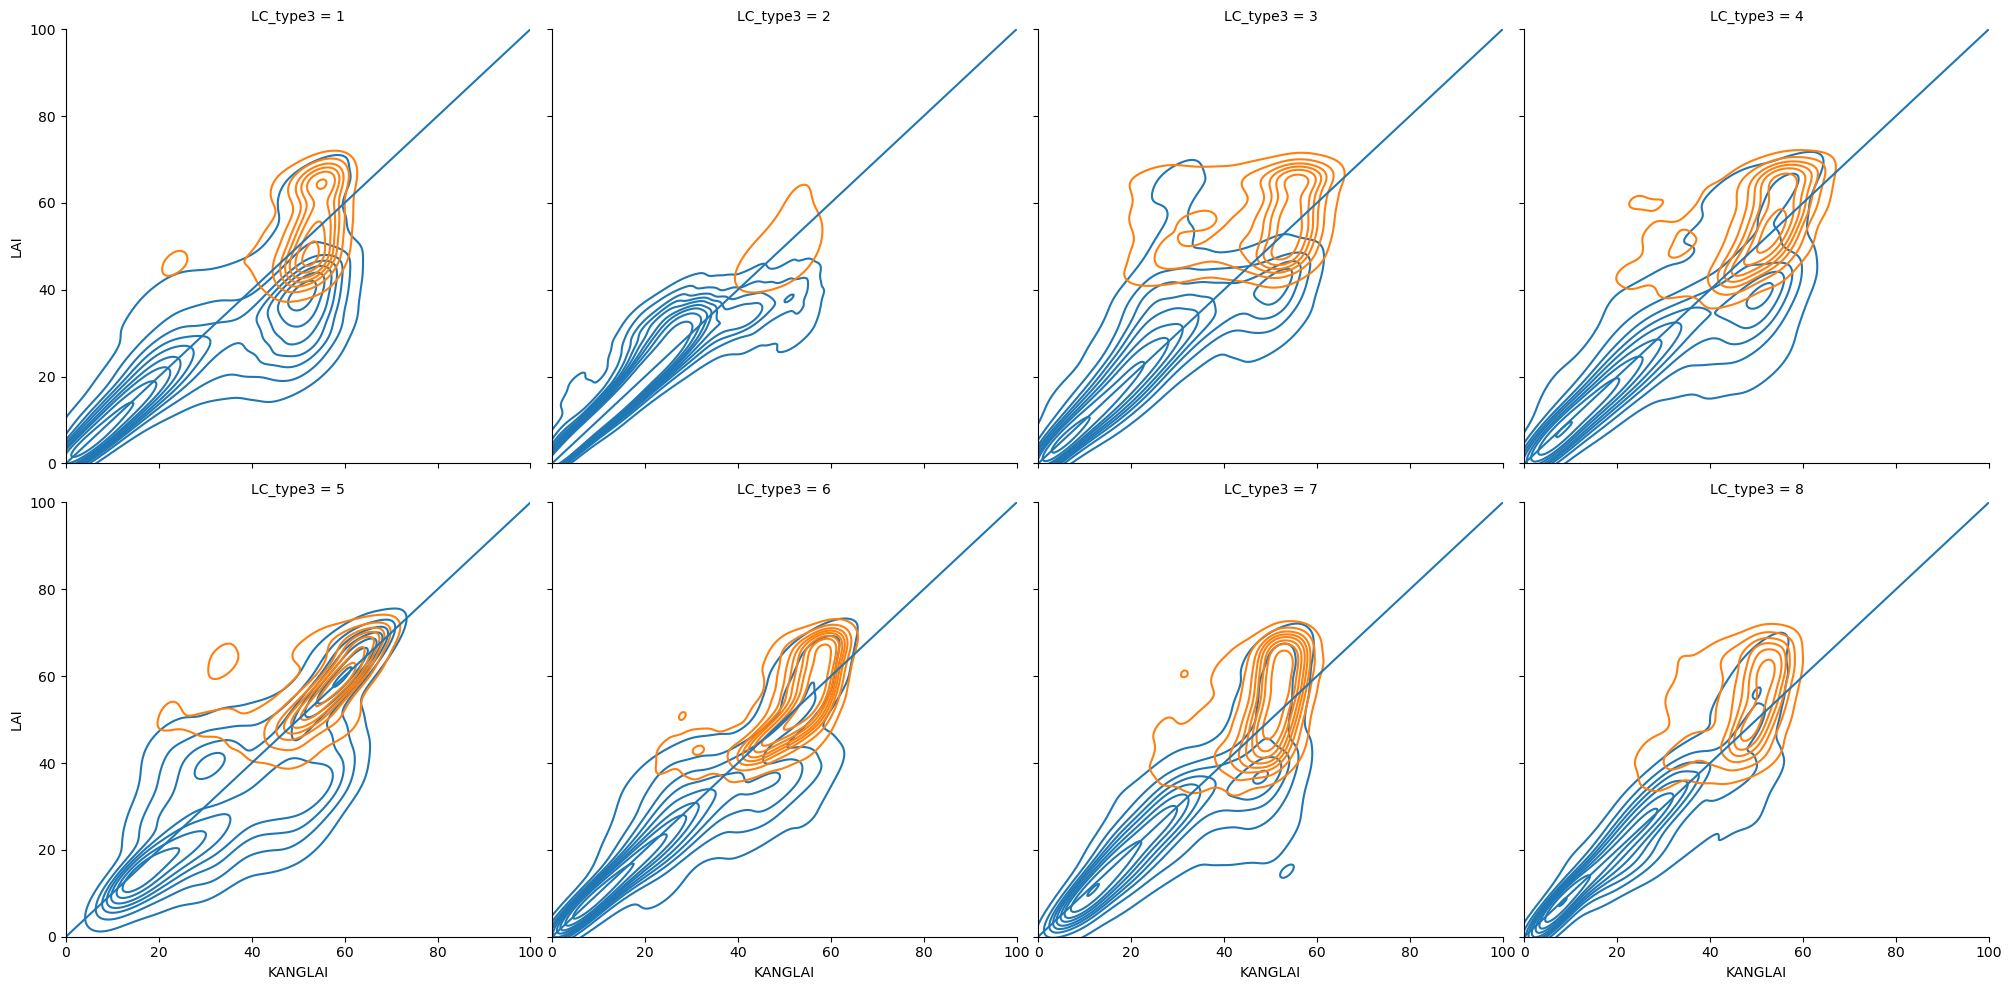

In [43]:
method = 'KANG'
response= 'LAI'
df = pd.DataFrame()
# fig, axs = plt.subplots(nrows=1,ncols=1,sharey=True,figsize=(10,20))
for biome in [1,2,3,4,5,6,7,8]:
    df = pd.concat([df,valbiomeDictLAI[biome]['DF']])
    df[method+response+'residual']= df[method+response]-df[response]
    df[method+response+'residualdivstd'] = df[method+response+'residual'] / (df['stdLAI'].clip(lower=5))
    print(np.sqrt(np.average(np.power(np.array(df.loc[df[method+response]>4][method+response+'residual']),2))))

f0 = sns.displot(df,x=method+response,y=response,hue="LUT_satFlag",legend=False,col='LC_type3',kind='kde',col_wrap=4)
for ax in f0.axes:
    ax.plot([0,100],[0,100])
    ax.set_xlim([0,100])
    ax.set_ylim([0,100])    

# f1 = sns.displot(df,x=response,y=method+response+'residual',hue="LUT_satFlag",legend=False,col='LC_type3',kind='kde',col_wrap=4)
# for ax in f1.axes:
#     ax.plot([0,100],[0,0])
#     ax.set_xlim([0,100])
#     ax.set_ylim([-40,40])  
    
# f2 = sns.displot(df,x=response,y=method+response+'residualdivstd',hue="LUT_satFlag",legend=False,col='LC_type3',kind='kde',col_wrap=4)
# for ax in f2.axes:
#     ax.plot([0,100],[0,0])
#     ax.set_xlim([0,100])
#     ax.set_ylim([-10,10])  

In [ ]:
method = 'FTL'
response= 'LAI'
# df = pd.DataFrame()
# # fig, axs = plt.subplots(nrows=1,ncols=1,sharey=True,figsize=(10,20))
# for biome in [1,2,3,4,5,6,7,8]:
#     df = pd.concat([df,valbiomeDictLAI[biome]['DF']])
#     df[method+response+'residual']= df[method+response]-df[response]

#     df[method+response+'residualdivstd'] = df[method+response+'residual'] / (df['stdLAI'].clip(lower=5))
#     print(np.sqrt(np.average(np.power(np.array(df.loc[df[method+response]>4][method+response+'residual']),2))))

# f0 = sns.displot(df,x=method+response,y=response,hue="LUT_satFlag",legend=False,col='LC_type3',kind='kde',col_wrap=4)
# for ax in f0.axes:
#     ax.plot([0,100],[0,100])
#     ax.set_xlim([0,100])
#     ax.set_ylim([0,100])    


f1 = sns.displot(df,x=response,y=method+response+'residual',hue="LUT_satFlag",legend=False,col='LC_type3',kind='kde',col_wrap=4)
for ax in f1.axes:
    ax.plot([0,100],[0,0])
    ax.set_xlim([0,100])
    ax.set_ylim([-40,40])  
    
# f2 = sns.displot(df,x=response,y=method+response+'residualdivstd',hue="LUT_satFlag",legend=False,col='LC_type3',kind='kde',col_wrap=4)
# for ax in f2.axes:
#     ax.plot([0,100],[0,0])
#     ax.set_xlim([0,100])
#     ax.set_ylim([-10,10])  

### Maps of samples

Figure S1. Spatial density of LAI sampling distributons.

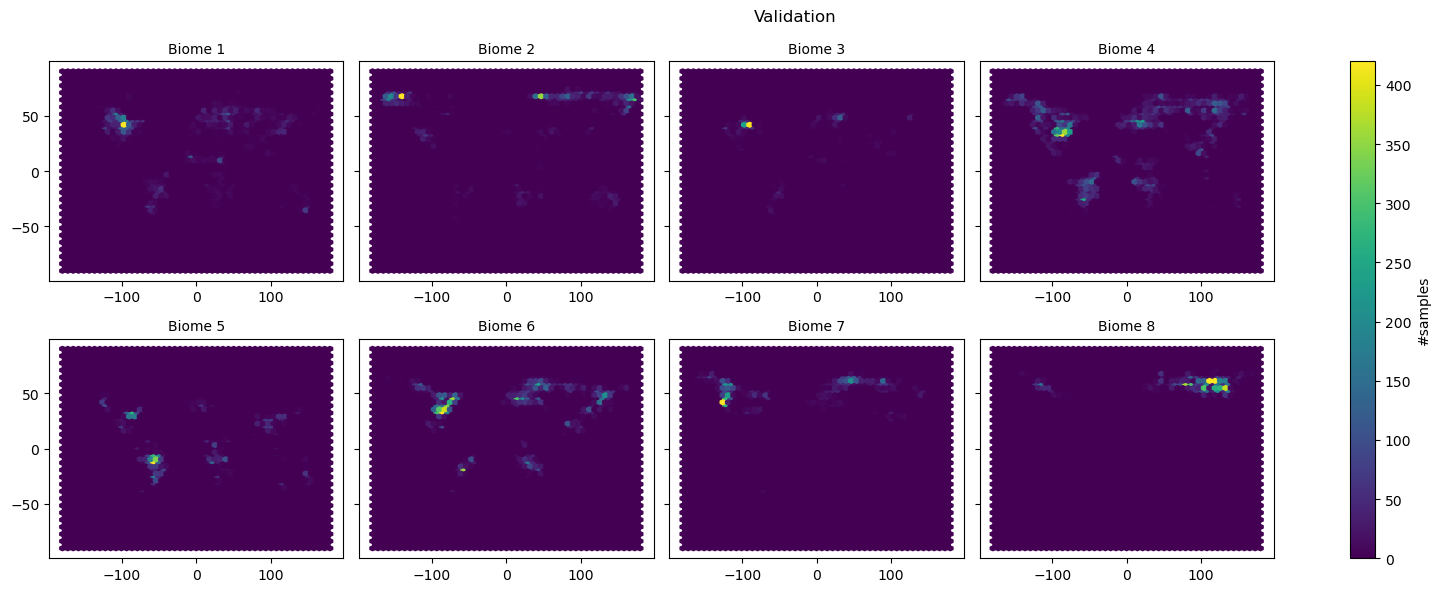

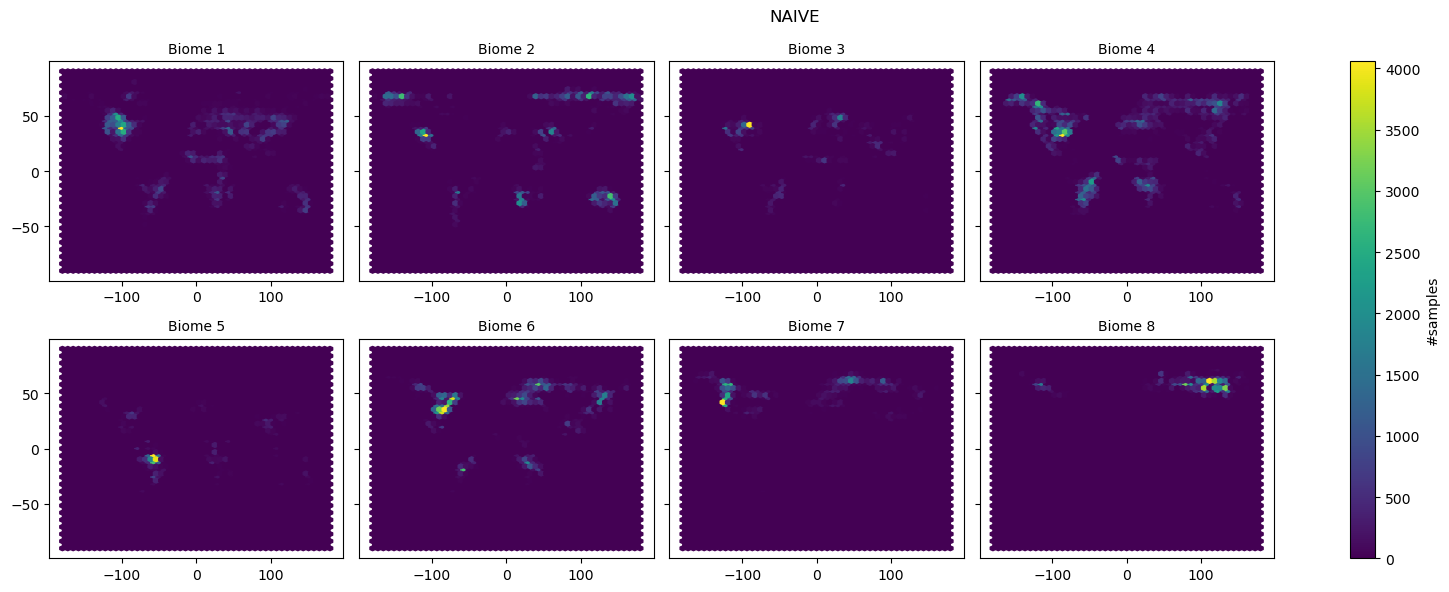

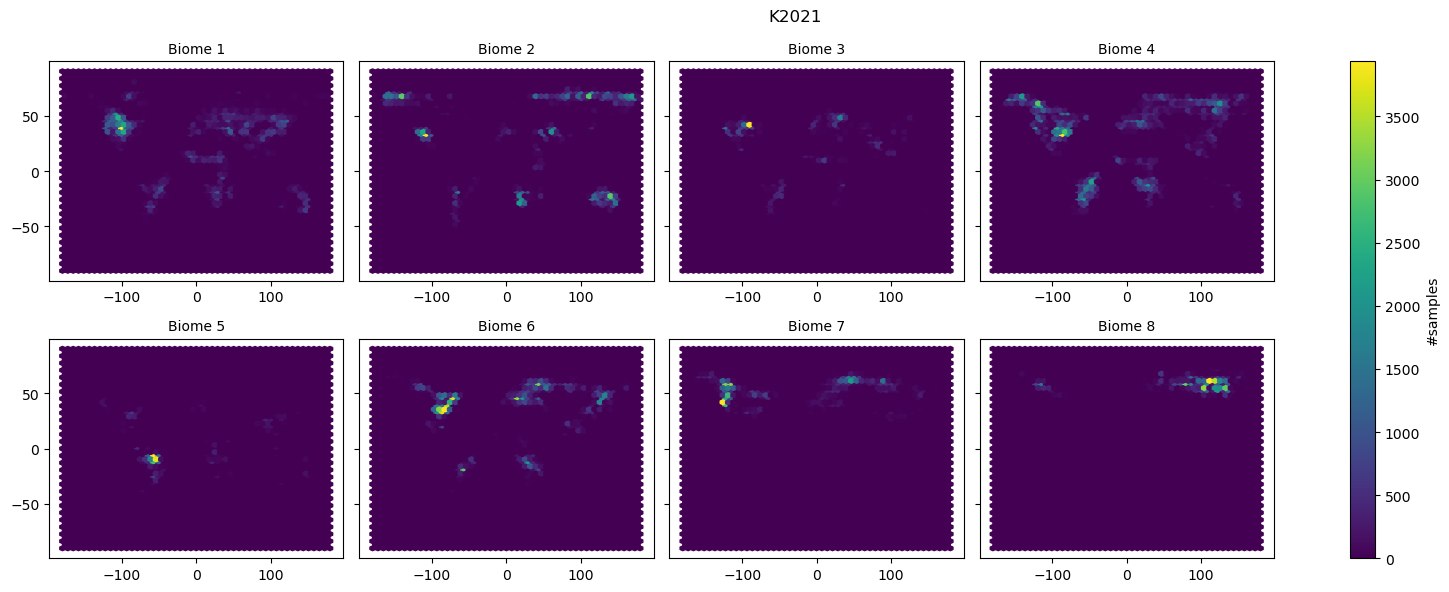

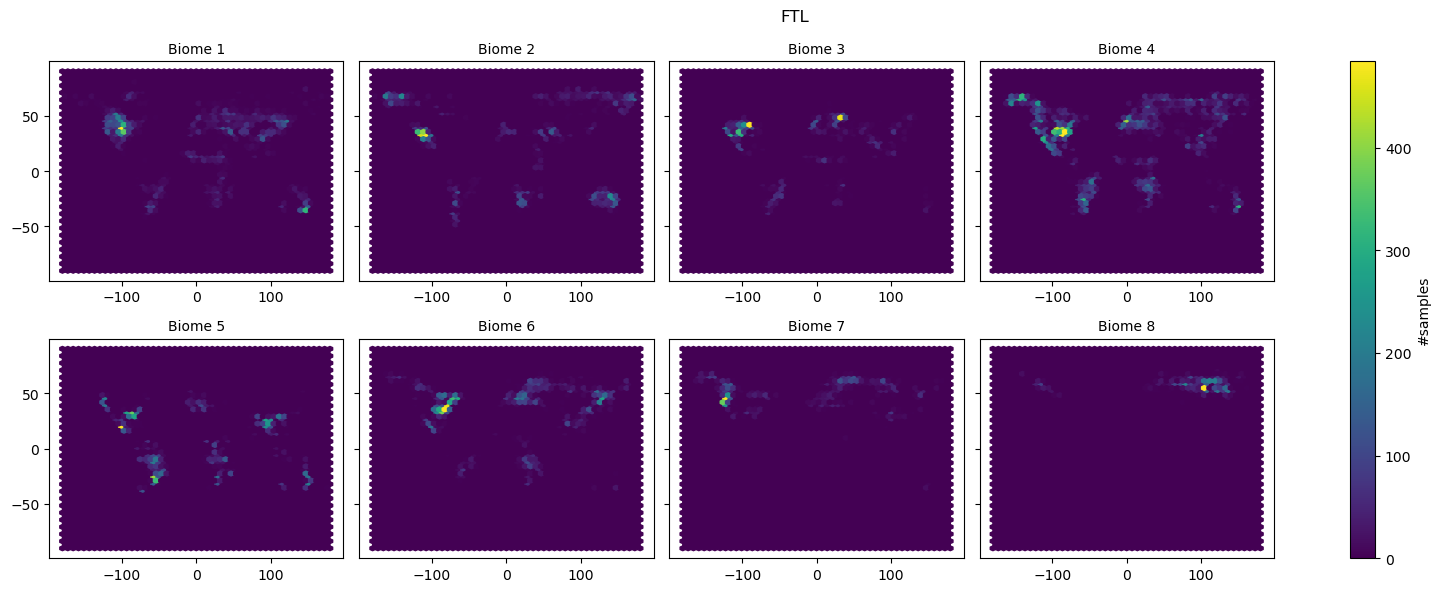

In [30]:
plotMaps(valbiomeDictLAI,'Validation')
plotMaps(calbiomeDictLAI,'NAIVE')
plotMaps(calbiomeDictLAIKANG,'K2021')
plotMaps(calbiomeDictLAIFTL,'FTL')

Figure S2. Spatial density of FAPAR sampling distributons.

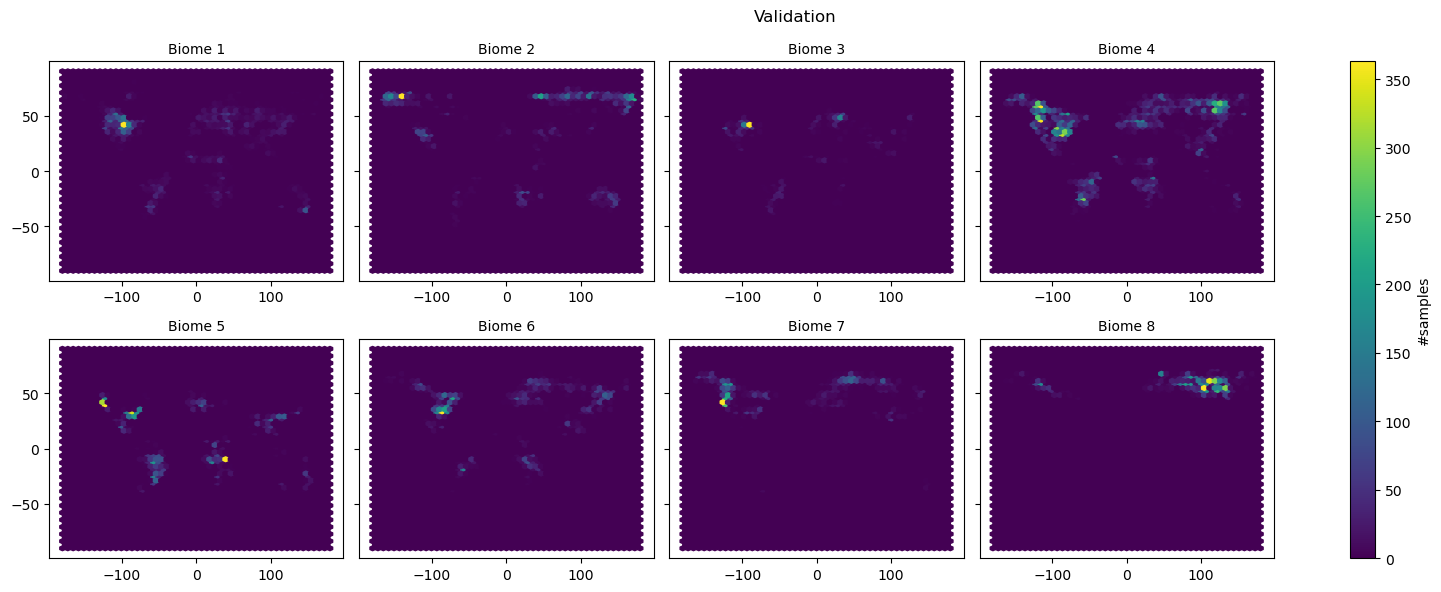

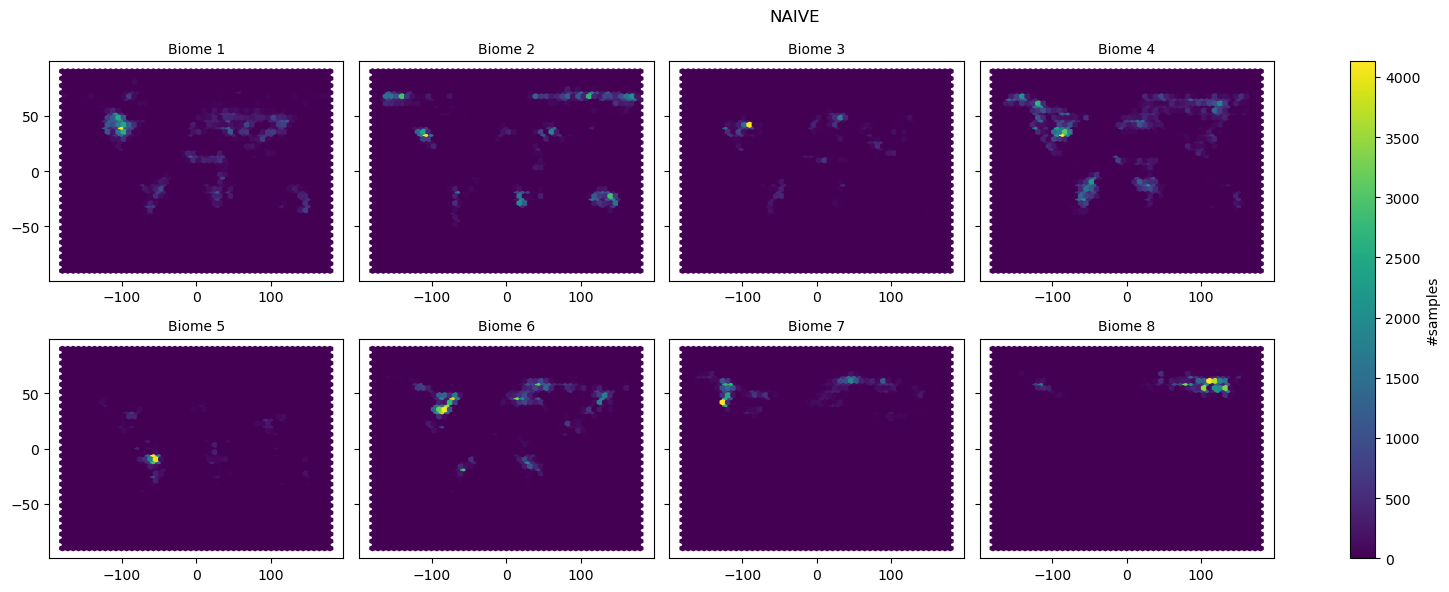

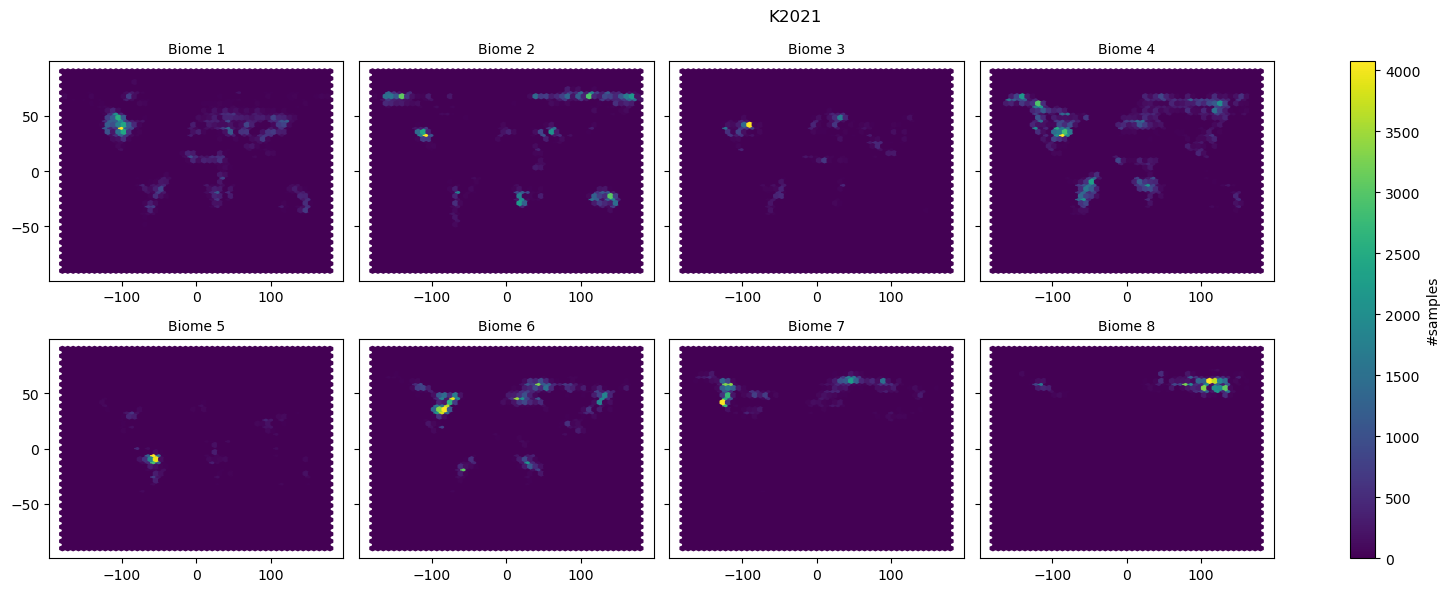

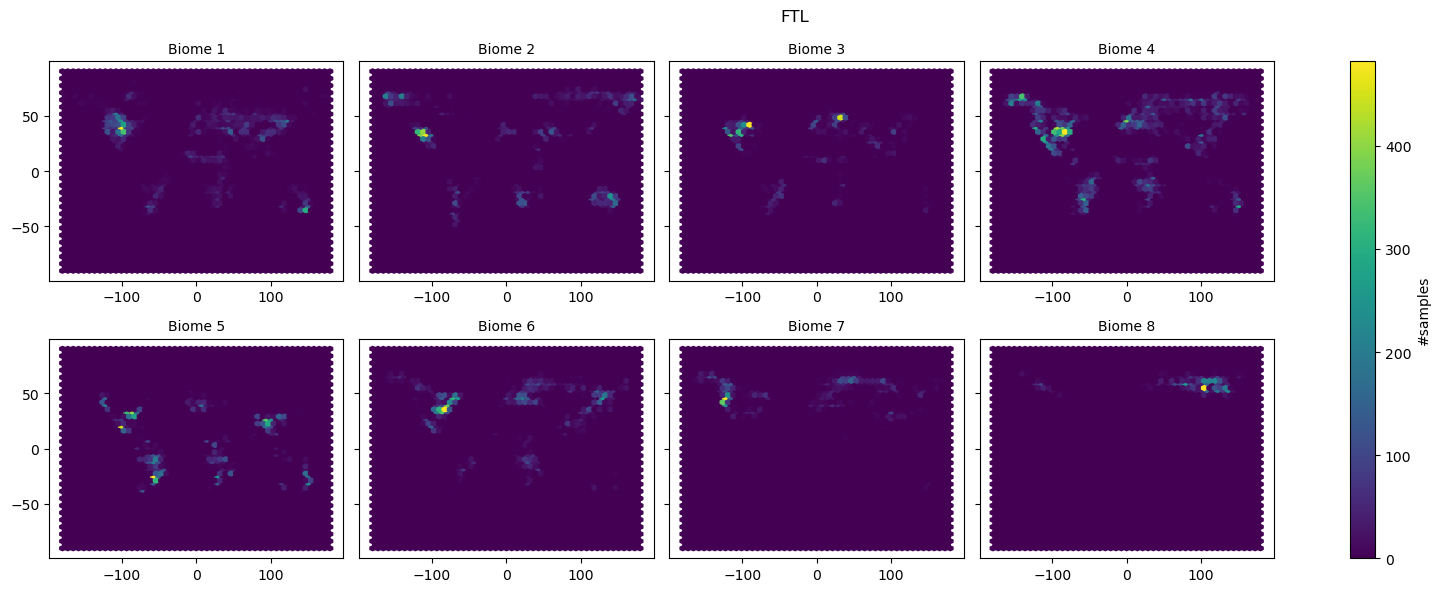

In [32]:
plotMaps(valbiomeDictFAPAR,'Validation')
plotMaps(calbiomeDictFAPAR,'NAIVE')
plotMaps(calbiomeDictFAPARKANG,'K2021')
plotMaps(calbiomeDictFAPARFTL,'FTL')

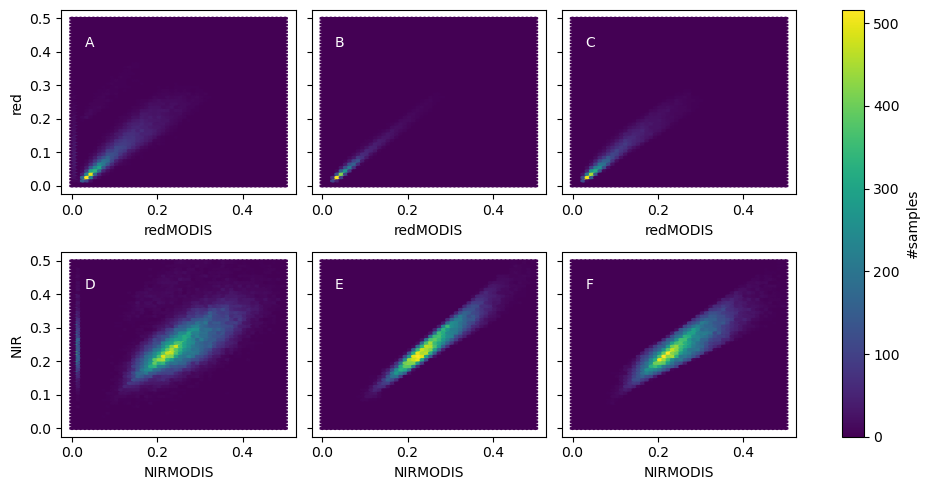

In [8]:
fig, axs = plt.subplots(nrows=2,ncols=3,sharey=True,figsize=(10,5))
dfA = dfALL.sample(100000) / 10000
axs[0,0].hexbin(dfA['redMODIS'],dfA['red'], gridsize=(50,50), extent=(0,0.5,0,0.5))
axs[0,0].set(xlabel='redMODIS', ylabel='red')
axs[1,0].hexbin(dfA['NIRMODIS'],dfA['NIR'], gridsize=(50,50), extent=(0,0.5,0,0.5))
axs[1,0].set(xlabel='NIRMODIS', ylabel='NIR')

dfT = dfALLtrim.sample(100000) / 10000
axs[0,1].hexbin(dfT['redMODIS'],dfT['red'], gridsize=(50,50), extent=(0,0.5,0,0.5))
axs[0,1].set(xlabel='redMODIS')
hb=axs[1,1].hexbin(dfT['NIRMODIS'],dfT['NIR'], gridsize=(50,50), extent=(0,0.5,0,0.5))
axs[1,1].set(xlabel='NIRMODIS')

dfK = dfALLtrimKANG.sample(100000) / 10000
axs[0,2].hexbin(dfK['redMODIS'],dfK['red'], gridsize=(50,50), extent=(0,0.5,0,0.5))
axs[0,2].set(xlabel='redMODIS')
hb=axs[1,2].hexbin(dfK['NIRMODIS'],dfK['NIR'], gridsize=(50,50), extent=(0,0.5,0,0.5))
axs[1,2].set(xlabel='NIRMODIS')

#Add colorbar
fig.tight_layout()
cb = fig.colorbar(hb, ax=axs)
cb.set_label('#samples')

#Add labels
axs[0,0].text(0.1, 0.8, 'A', size=10, color='white', transform=axs[0,0].transAxes)
axs[1,0].text(0.1, 0.8, 'D', size=10, color='white', transform=axs[1,0].transAxes)
axs[0,1].text(0.1, 0.8, 'B', size=10, color='white', transform=axs[0,1].transAxes)
axs[1,1].text(0.1, 0.8, 'E', size=10, color='white', transform=axs[1,1].transAxes)
axs[0,2].text(0.1, 0.8, 'C', size=10, color='white', transform=axs[0,2].transAxes)
axs[1,2].text(0.1, 0.8, 'F', size=10, color='white', transform=axs[1,2].transAxes)

plt.show()

Pairplots of sampled respose values by biome

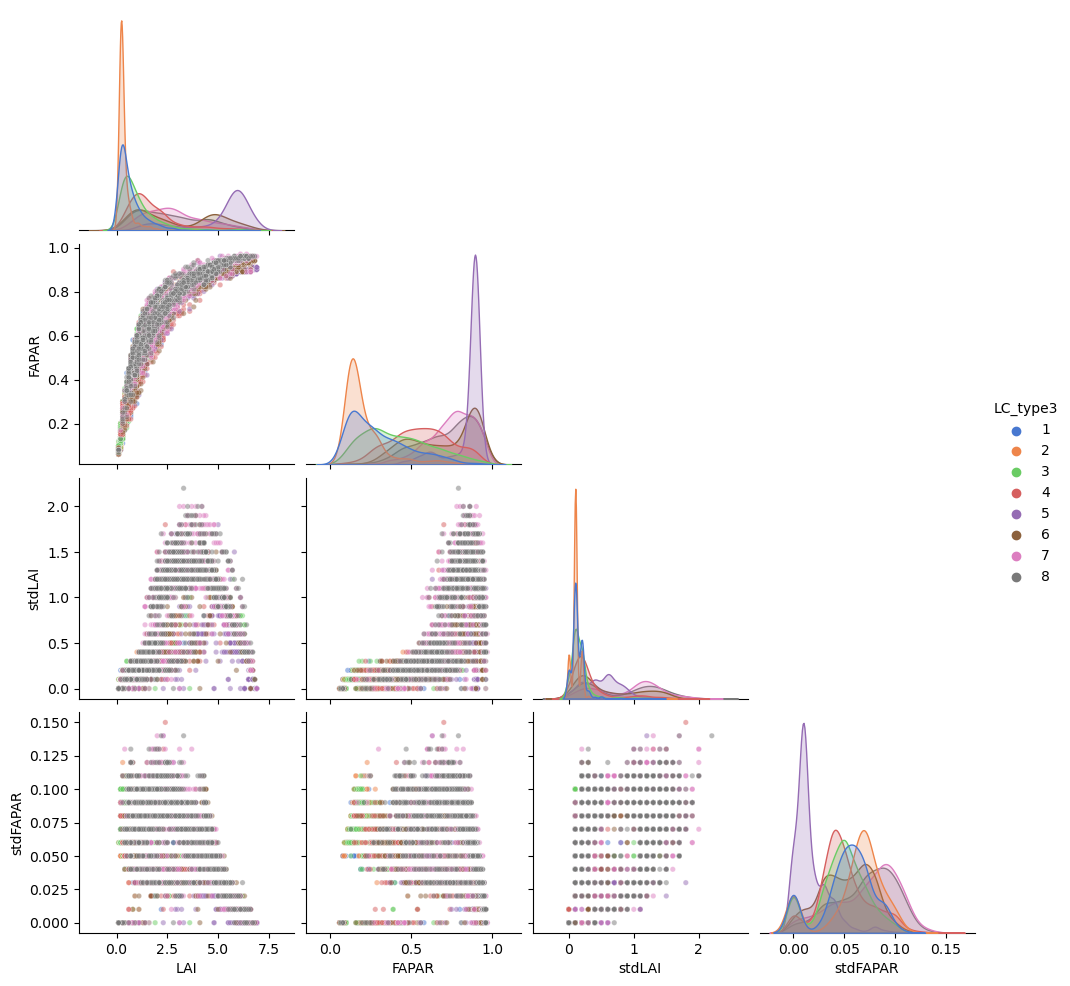

In [9]:
dfScaling = pd.DataFrame([[10., 100.,10.,100.,1]], columns=['LAI','FAPAR','stdLAI','stdFAPAR','LC_type3'])
dfPlot = dfALL.loc[dfALL['LC_type3']<9][['LAI','FAPAR','stdLAI','stdFAPAR','LC_type3']].groupby('LC_type3').sample(1000).div(dfScaling.iloc[0])
dfPlot['LC_type3'] = dfPlot['LC_type3'].astype(int)
pairplot = sns.pairplot(dfPlot,hue='LC_type3',palette='muted',plot_kws={"s": 15,'alpha':0.5},corner=True)
#pairplot.fig.savefig("Figure2.png", bbox_inches='tight') 

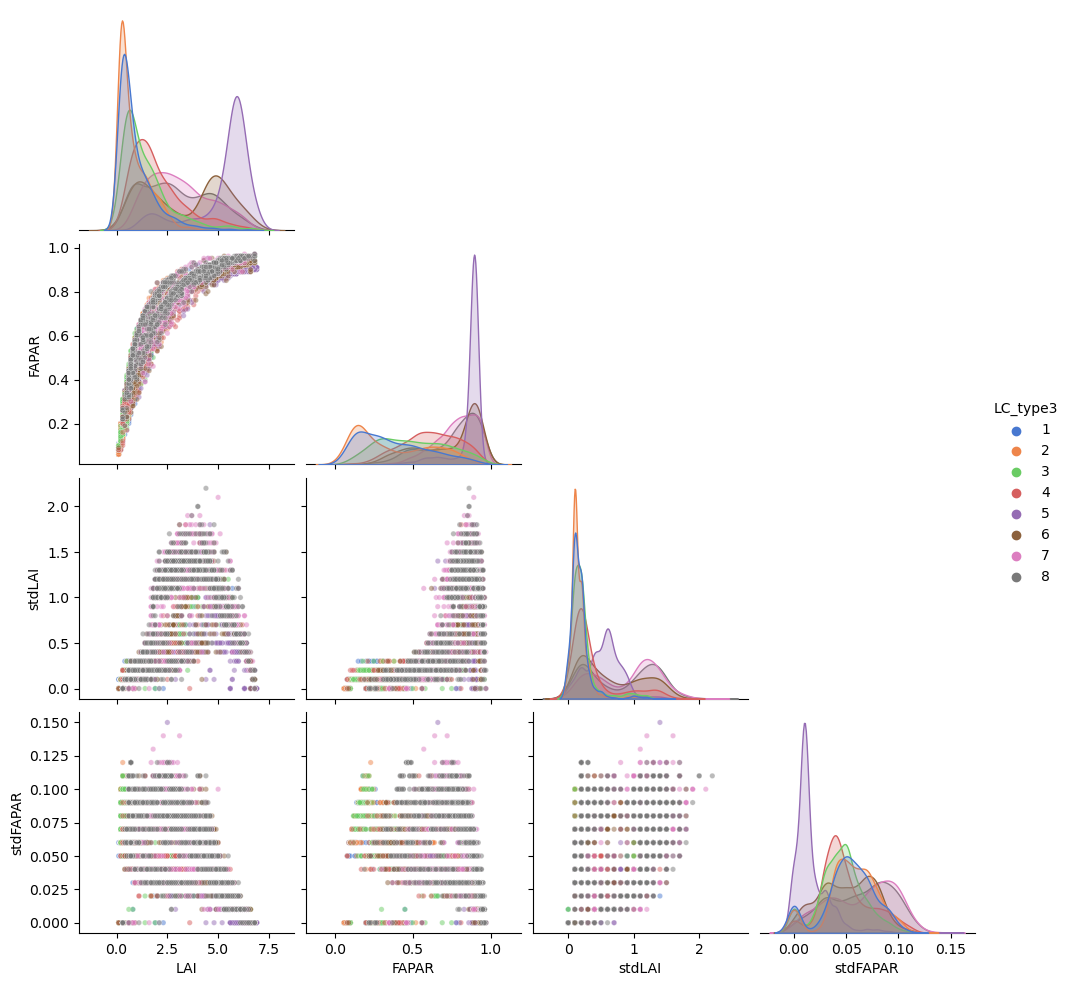

In [10]:
dfScaling = pd.DataFrame([[10., 100.,10.,100.,1]], columns=['LAI','FAPAR','stdLAI','stdFAPAR','LC_type3'])
dfPlot = dfALLtrim.loc[dfALLtrim['LC_type3']<9][['LAI','FAPAR','stdLAI','stdFAPAR','LC_type3']].groupby('LC_type3').sample(1000).div(dfScaling.iloc[0])
dfPlot['LC_type3'] = dfPlot['LC_type3'].astype(int)
pairplot = sns.pairplot(dfPlot,hue='LC_type3',palette='muted',plot_kws={"s": 15,'alpha':0.5},corner=True)
#pairplot.fig.savefig("Figure2.png", bbox_inches='tight') 

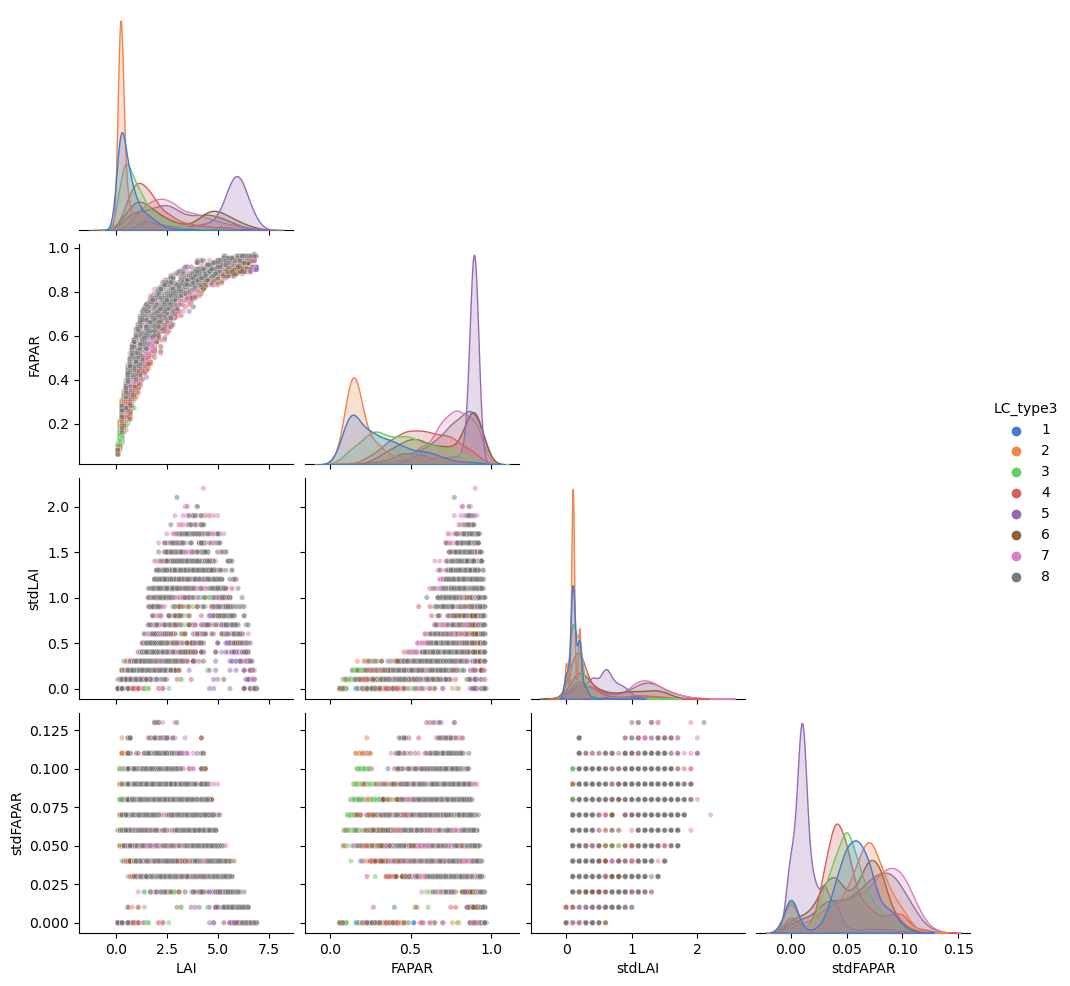

In [11]:
dfScaling = pd.DataFrame([[10., 100.,10.,100.,1]], columns=['LAI','FAPAR','stdLAI','stdFAPAR','LC_type3'])
dfPlot = dfALLtrimKANG.loc[dfALLtrimKANG['LC_type3']<9][['LAI','FAPAR','stdLAI','stdFAPAR','LC_type3']].groupby('LC_type3').sample(1000).div(dfScaling.iloc[0])
dfPlot['LC_type3'] = dfPlot['LC_type3'].astype(int)
pairplot = sns.pairplot(dfPlot,hue='LC_type3',palette='muted',plot_kws={"s": 15,'alpha':0.5},corner=True)
#pairplot.fig.savefig("Figure2.png", bbox_inches='tight') 

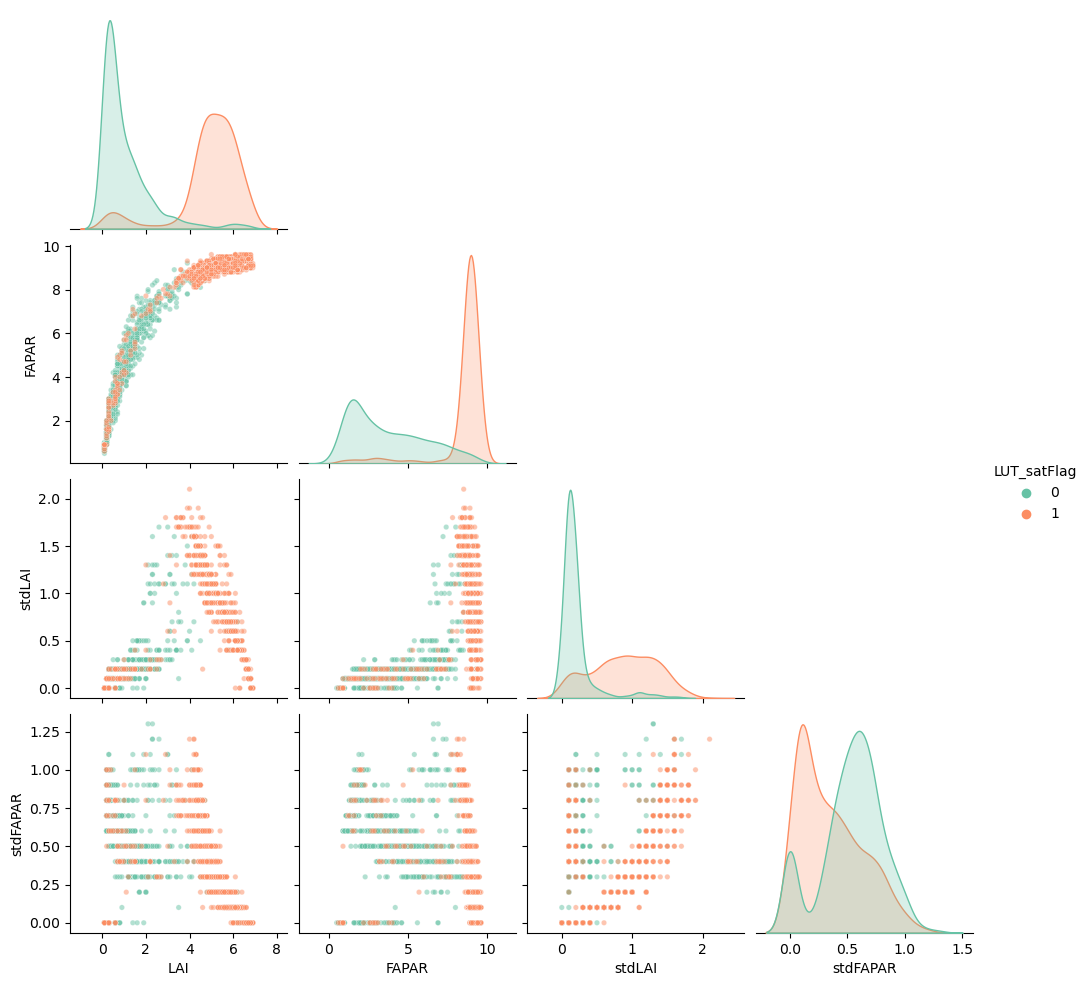

In [12]:
dfScaling = pd.DataFrame([[10., 10.,10.,10.,1]], columns=['LAI','FAPAR','stdLAI','stdFAPAR','LUT_satFlag'])
dfPlot = dfALL.loc[dfALL['LC_type3']<9][['LAI','FAPAR','stdLAI','stdFAPAR','LUT_satFlag']].groupby('LUT_satFlag').sample(1000).div(dfScaling.iloc[0])
dfPlot['LUT_satFlag'] = dfPlot['LUT_satFlag'].astype(int)
pairplot = sns.pairplot(dfPlot,hue='LUT_satFlag',palette='Set2',plot_kws={"s": 15,'alpha':0.5},corner=True)
#pairplot.fig.savefig("Figure3.png", bbox_inches='tight') 

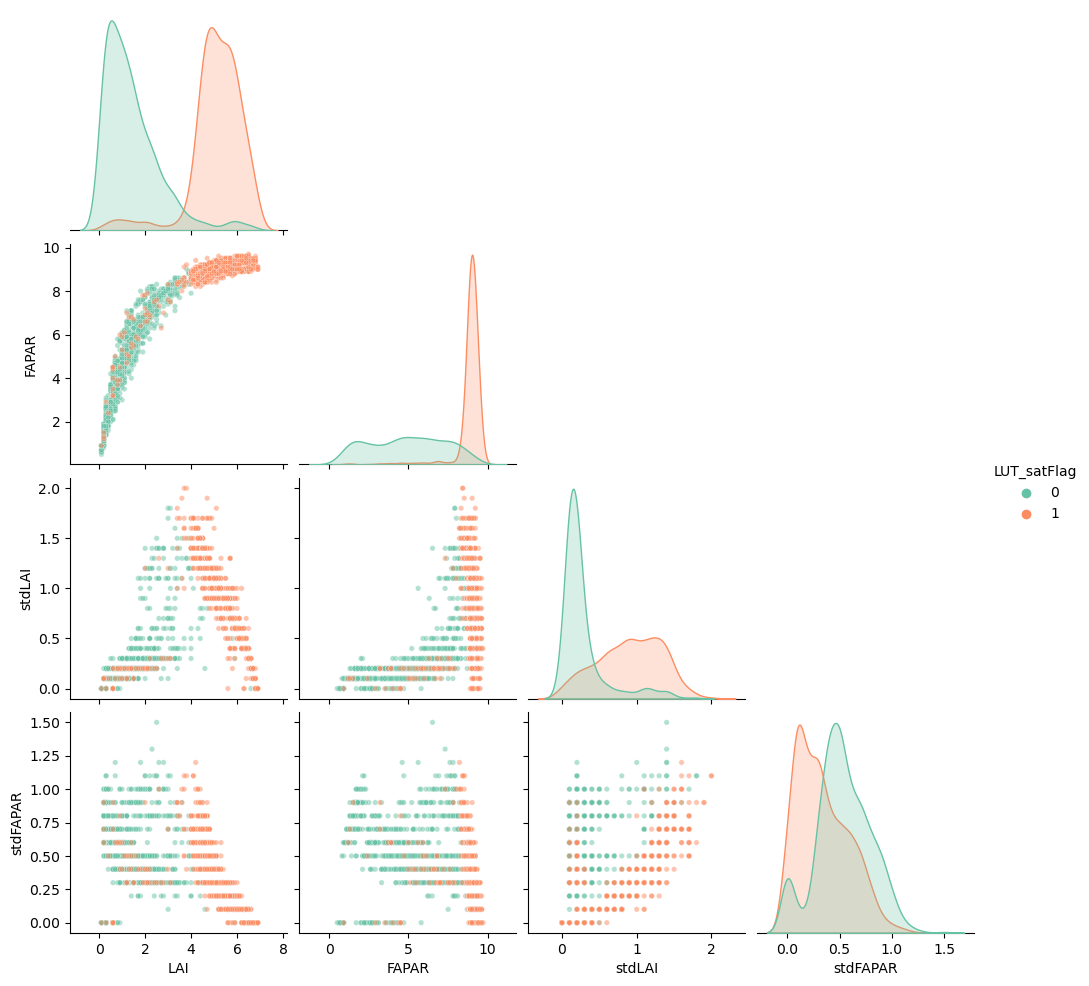

In [13]:
dfScaling = pd.DataFrame([[10., 10.,10.,10.,1]], columns=['LAI','FAPAR','stdLAI','stdFAPAR','LUT_satFlag'])
dfPlot = dfALLtrim.loc[dfALLtrim['LC_type3']<9][['LAI','FAPAR','stdLAI','stdFAPAR','LUT_satFlag']].groupby('LUT_satFlag').sample(1000).div(dfScaling.iloc[0])
dfPlot['LUT_satFlag'] = dfPlot['LUT_satFlag'].astype(int)
pairplot = sns.pairplot(dfPlot,hue='LUT_satFlag',palette='Set2',plot_kws={"s": 15,'alpha':0.5},corner=True)
#pairplot.fig.savefig("Figure3.png", bbox_inches='tight') 

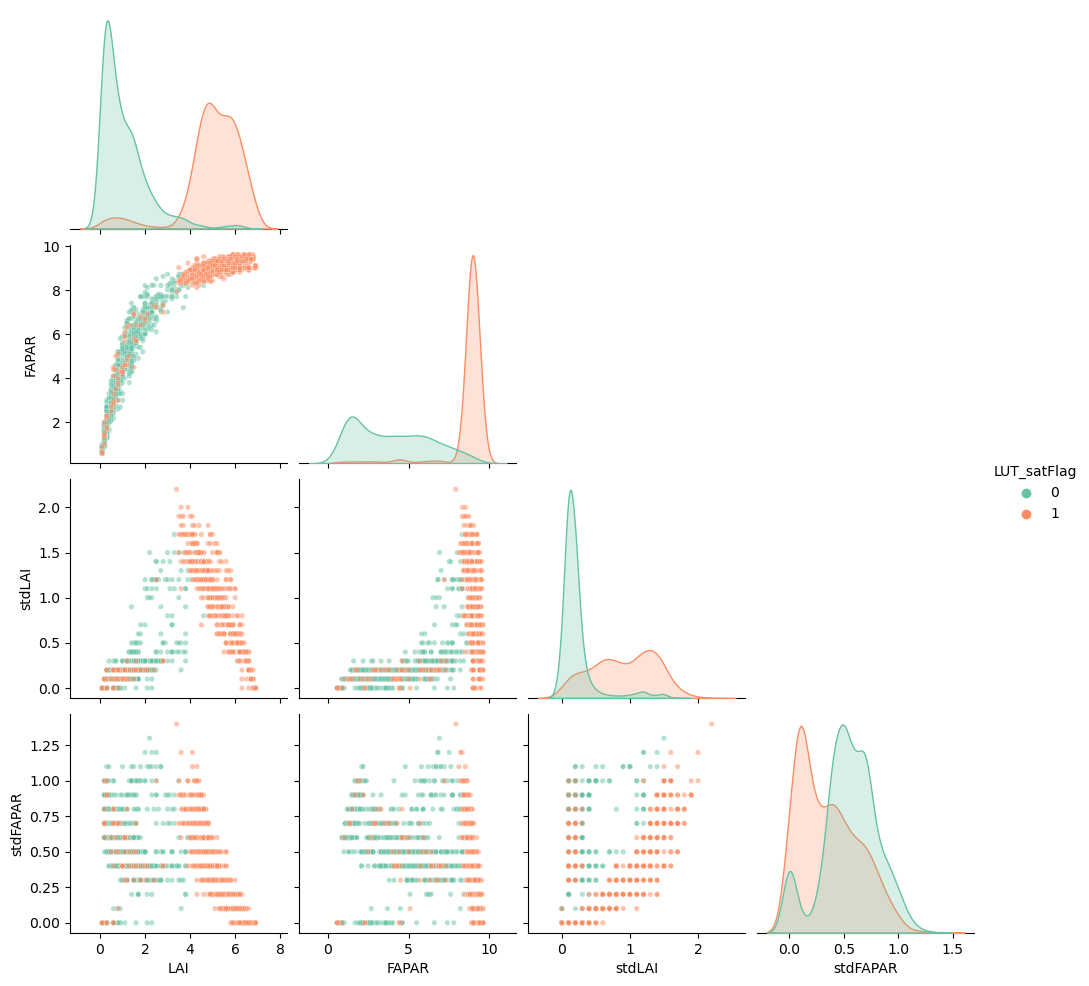

In [14]:
dfScaling = pd.DataFrame([[10., 10.,10.,10.,1]], columns=['LAI','FAPAR','stdLAI','stdFAPAR','LUT_satFlag'])
dfPlot = dfALLtrimKANG.loc[dfALLtrimKANG['LC_type3']<9][['LAI','FAPAR','stdLAI','stdFAPAR','LUT_satFlag']].groupby('LUT_satFlag').sample(1000).div(dfScaling.iloc[0])
dfPlot['LUT_satFlag'] = dfPlot['LUT_satFlag'].astype(int)
pairplot = sns.pairplot(dfPlot,hue='LUT_satFlag',palette='Set2',plot_kws={"s": 15,'alpha':0.5},corner=True)
#pairplot.fig.savefig("Figure3.png", bbox_inches='tight') 

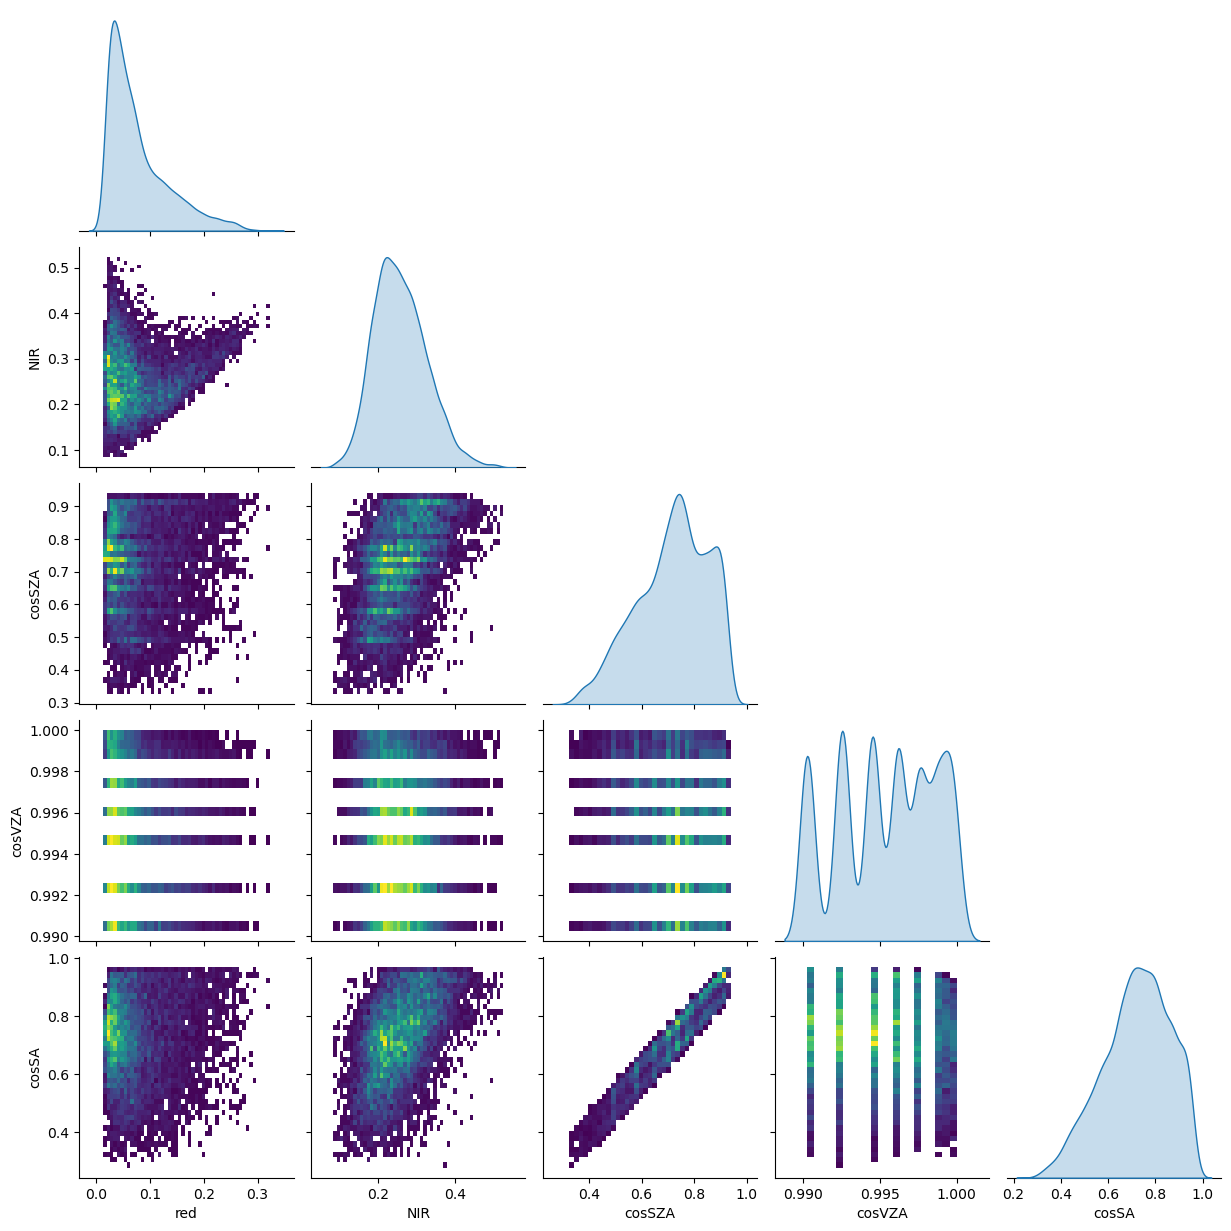

In [15]:
pairplot = sns.pairplot(dfALLtrim.loc[dfALLtrim['LC_type3']<9][['red','NIR','cosSZA','cosVZA','cosSA']].sample(10000).divide(10000),plot_kws={'cmap':'viridis'},kind='hist',diag_kind='kde',corner=True)
#pairplot.fig.savefig("Figure4.png", bbox_inches='tight') 

Graphs for dfALL

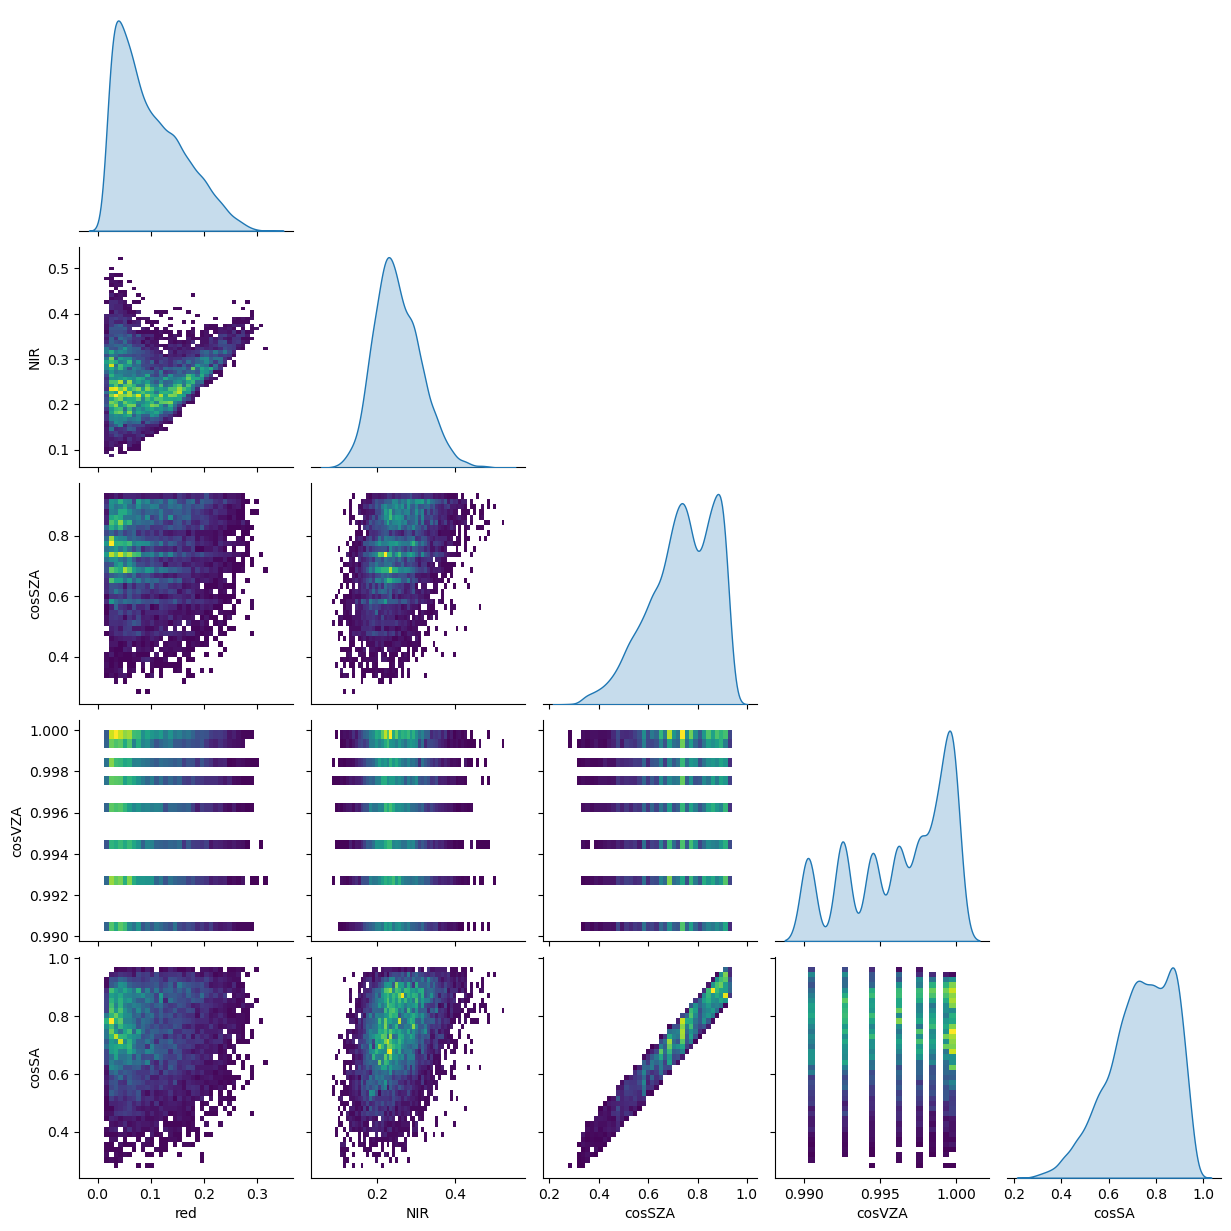

In [16]:
pairplot = sns.pairplot(dfALLtrimKANG.loc[dfALLtrimKANG['LC_type3']<9][['red','NIR','cosSZA','cosVZA','cosSA']].sample(10000).divide(10000),plot_kws={'cmap':'viridis'},kind='hist',diag_kind='kde',corner=True)
#pairplot.fig.savefig("Figure4.png", bbox_inches='tight')

## Production of Sampled Databases

### Creation of base calibration and validation datasets

In [ ]:
# Only needed to recreate dfALLTrim
# Global sample using Richard sampling code
dfALL = pd.read_pickle('c:/users/rfernand/modisLandsat/code/MODISLANDSATall.pkl')

# trim outliers for NAIVE and FTL and make additional features
dfALLtrim = makeFeatures(trimMatchUps(dfALL,10))


# save calibration database before and after trimming
pd.to_pickle(dfALLtrim,'c:/users/rfernand/modisLandsat/code/MODISLANDSATalltrim.pkl')

In [ ]:
# extract validation data from dfALLtrim using uniform sampling of response
# save in dictionary of data frames, each data frame for one LC_Type3 
# and also remove from calibration data for NAIVE and save in dictionary of data frames, each data frame for one LC_Type3 


# Sample based on trimming for NAIVE (also used as a basis for FTL)
dfALLtrim = pd.read_pickle('c:/users/rfernand/modisLandsat/code/MODISLANDSATalltrim.pkl')

# LAI
calbiomeDictLAI = {}
valbiomeDictLAI = {}
features = ['LAI']
for biome in  dfALLtrim['LC_type3'].unique():
    dfBiome = dfALLtrim.loc[dfALLtrim['LC_type3']==biome]
    valDFBiome = resampleBiome(dfBiome,features,maxSamples=10000,percentilePairwiseDist=99,metricDist='manhattan',randSeed=10)
    calDFBiome = dfBiome.drop(valDFBiome.index)
    calbiomeDictLAI.update({biome: {'DF': calDFBiome}})
    valbiomeDictLAI.update({biome: {'DF': valDFBiome}})
    print('Biome',biome,' size',dfBiome.shape,' calibration size',calDFBiome.shape,' validation size', valDFBiome.shape)

pd.to_pickle(calbiomeDictLAI,'c:/users/rfernand/modisLandsat/code/calbiomeDictLAI.pkl')
pd.to_pickle(valbiomeDictLAI,'c:/users/rfernand/modisLandsat/code/valbiomeDictLAI.pkl')
# FAPAR
calbiomeDictFAPAR = {}
valbiomeDictFAPAR = {}
features = ['FAPAR']
for biome in dfALLtrim['LC_type3'].unique():
    dfBiome = dfALLtrim.loc[dfALLtrim['LC_type3']==biome]
    valDFBiome = resampleBiome(dfBiome,features,maxSamples=10000,percentilePairwiseDist=99,metricDist='manhattan',randSeed=10)
    calDFBiome = dfBiome.drop(valDFBiome.index)
    calbiomeDictFAPAR.update({biome: {'DF': calDFBiome}})
    valbiomeDictFAPAR.update({biome: {'DF': valDFBiome}})
    print('Biome',biome,' size',dfBiome.shape,' calibration size',calDFBiome.shape,' validation size', valDFBiome.shape)
    
pd.to_pickle(calbiomeDictFAPAR,'c:/users/rfernand/modisLandsat/code/calbiomeDictFAPAR.pkl')
pd.to_pickle(valbiomeDictFAPAR,'c:/users/rfernand/modisLandsat/code/valbiomeDictFAPAR.pkl')


In [20]:
# Validation data for LAI and FAPAR
# valbiomeDictLAI = pd.read_pickle('c:/users/rfernand/modisLandsat/code/valbiomeDictLAI.pkl')
# valbiomeDictFAPAR = pd.read_pickle('c:/users/rfernand/modisLandsat/code/valbiomeDictFAPAR.pkl')

# # Calibration data for LAI and FAPAR
# calbiomeDictLAI = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictLAI.pkl')
# calbiomeDictFAPAR = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictFAPAR.pkl')

# # # Kang's calibration data for LAI and FAPAR
# calbiomeDictLAIKANG = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictLAIKANG.pkl')
# calbiomeDictFAPARKANG = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictFAPARKANG.pkl')


# FTL  calibration data for LAI and FAPAR
# not used now as we split FTL into sat and unsat
# calbiomeDictLAIFTL= pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictLAIFTL.pkl')
# calbiomeDictFAPARFTL = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictFAPARFTL.pkl')
calbiomeDictLAIFTLSat= pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictLAIFTLSat.pkl')
calbiomeDictFAPARFTLSat = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictFAPARFTLSat.pkl')
calbiomeDictLAIFTLUnSat= pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictLAIFTLUnSat.pkl')
calbiomeDictFAPARFTLUnSat = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictFAPARFTLUnsat.pkl')

# https://drive.google.com/drive/folders/1jVKwxWPlH7nYnpL1yJAUD2jFkXV3A1kf?usp=share_link


### NAIVE AND FTL

In [22]:
#old version
# calbiomeDictLAINAIVEFTL= pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictLAIFTLdf.pkl')
# calbiomeDictFAPARNAIVEFTL = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictFAPARFTLdf.pkl')
# calbiomeDictLAIFTLUnSat = {}
# calbiomeDictFAPARFTLUnSat = {}
# calbiomeDictLAIFTLSat = {}
# calbiomeDictFAPARFTLSat = {}
# for biome in  [1,2,3,4,5,6,7,8]:
#     dfBiome = calbiomeDictLAIFTL[biome]['DF']
#     calbiomeDictLAIFTLUnSat.update({biome: {'DF': dfBiome.loc[(dfBiome['LUT_satFlag']==0) | (dfBiome['LAI']<40) ]}})
#     calbiomeDictLAIFTLSat.update({biome: {'DF': dfBiome.loc[(dfBiome['LUT_satFlag']==1) | (dfBiome['LAI']>40) ]}})
#     dfBiome = calbiomeDictFAPARFTL[biome]['DF']
#     calbiomeDictFAPARFTLUnSat.update({biome: {'DF': dfBiome.loc[(dfBiome['LUT_satFlag']==0) | (dfBiome['LAI']<40) ]}})
#     calbiomeDictFAPARFTLSat.update({biome: {'DF': dfBiome.loc[(dfBiome['LUT_satFlag']==1) | (dfBiome['LAI']>40) ]}})
pd.to_pickle(calbiomeDictLAIFTLUnSat,'c:/users/rfernand/modisLandsat/code/calbiomeDictLAIFTLUnSat.pkl')
pd.to_pickle(calbiomeDictLAIFTLSat,'c:/users/rfernand/modisLandsat/code/calbiomeDictLAIFTLSat.pkl')
pd.to_pickle(calbiomeDictFAPARFTLUnSat,'c:/users/rfernand/modisLandsat/code/calbiomeDictFAPARFTLUnSat.pkl')
pd.to_pickle(calbiomeDictFAPARFTLSat,'c:/users/rfernand/modisLandsat/code/calbiomeDictFAPARFTLSat.pkl')

In [21]:
#get unsat  only subsampe new version
# calbiomeDictLAINAIVEUnSat = {}
# calbiomeDictFAPARNAIVEUnSat = {}
# for biome in  [1,2,3,4,5,6,7,8]:
#     dfBiome = calbiomeDictLAI[biome]['DF']
#     calbiomeDictLAINAIVEUnSat.update({biome: {'DF': dfBiome.loc[(dfBiome['LUT_satFlag']==0) | (dfBiome['LAI']<40) ]}})
#     dfBiome = calbiomeDictFAPAR[biome]['DF']
#     calbiomeDictFAPARNAIVEUnSat.update({biome: {'DF': dfBiome.loc[(dfBiome['LUT_satFlag']==0) | (dfBiome['LAI']<40) ]}})
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
features=  regressors
# calbiomeDictLAIFTLUnSat = resampleDict(calbiomeDictLAINAIVEUnSat,regressors,features,satFlag=-1,minSubSamples=2000,maxSamples=10000,percentileKDE=1)
# calbiomeDictLAIFTL2UnSat = resampleDict(calbiomeDictLAIFTLUnSat,regressors,features,satFlag=-1,minSubSamples=2000,maxSamples=10000,percentileKDE=50)
# calbiomeDictFAPARFTLUnSat = resampleDict(calbiomeDictFAPARNAIVEUnSat,regressors,features,satFlag=-1,minSubSamples=2000,maxSamples=10000,percentileKDE=1)
calbiomeDictFAPARFTL2UnSat = resampleDict(calbiomeDictFAPARFTLUnSat,regressors,features,satFlag=-1,minSubSamples=2000,maxSamples=10000,percentileKDE=50)
pd.to_pickle(calbiomeDictLAIFTL2UnSat,'c:/users/rfernand/modisLandsat/code/valbiomeDictLAIFTL2UnSat.pkl')
pd.to_pickle(calbiomeDictFAPARFTL2UnSat,'c:/users/rfernand/modisLandsat/code/valbiomeDictFAPARFTL2UnSat.pkl')

# pd.to_pickle(calbiomeDictLAINAIVEUnSat,'c:/users/rfernand/modisLandsat/code/calbiomeDictLAINAIVEUnSat.pkl')
# pd.to_pickle(calbiomeDictLAIFTLUnSat,'c:/users/rfernand/modisLandsat/code/valbiomeDictLAIFTLUnSat.pkl')
# pd.to_pickle(calbiomeDictFAPARNAIVEUnSat,'c:/users/rfernand/modisLandsat/code/calbiomeDictFAPARNAIVEUnSat.pkl')
# pd.to_pickle(calbiomeDictFAPARFTLUnSat,'c:/users/rfernand/modisLandsat/code/valbiomeDictFAPARFTLUnSat.pkl')


Biome 1  with  51038 samples.
Biome  1  using only  45358 of  51038  samples.
Biome 2  with  11732 samples.
Biome  2  using only  10372 of  11732  samples.
Biome 3  with  5254 samples.
Biome  3  using only  4633 of  5254  samples.
Biome 4  with  9794 samples.
Biome  4  using only  8715 of  9794  samples.
Biome 5  with  3059 samples.
Biome  5  using only  2670 of  3059  samples.
Biome 6  with  3374 samples.
Biome  6  using only  2938 of  3374  samples.
Biome 7  with  2823 samples.
Biome  7  using only  2465 of  2823  samples.
Biome 8  with  3989 samples.
Biome  8  using only  3582 of  3989  samples.


In [108]:
#get sat  only subsampe
calbiomeDictLAINAIVESat = {}
calbiomeDictFAPARNAIVESat = {}
for biome in  dfALLtrim['LC_type3'].unique():
    dfBiome = calbiomeDictLAI[biome]['DF']
    calbiomeDictLAINAIVESat.update({biome: {'DF': dfBiome.loc[(dfBiome['LUT_satFlag']==1) | (dfBiome['LAI']>40) ]}})
    dfBiome = calbiomeDictFAPAR[biome]['DF']
    calbiomeDictFAPARNAIVESat.update({biome: {'DF': dfBiome.loc[(dfBiome['LUT_satFlag']==1) | (dfBiome['LAI']>40) ]}})
# regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
# features=  regressors
# # calbiomeDictLAIFTLSat = resampleDict(calbiomeDictLAINAIVESat,regressors,features,satFlag=-1,minSubSamples=2000,maxSamples=10000,percentileKDE=1)
# calbiomeDictLAIFTL2Sat = resampleDict(calbiomeDictLAIFTLSat,regressors,features,satFlag=-1,minSubSamples=2000,maxSamples=10000,percentileKDE=50)
# # calbiomeDictFAPARFTLSat = resampleDict(calbiomeDictFAPARNAIVESat,regressors,features,satFlag=-1,minSubSamples=2000,maxSamples=10000,percentileKDE=1)
# calbiomeDictFAPARFTL2Sat = resampleDict(calbiomeDictFAPARFTLSat,regressors,features,satFlag=-1,minSubSamples=2000,maxSamples=10000,percentileKDE=50)

# # pd.to_pickle(calbiomeDictLAINAIVESat,'c:/users/rfernand/modisLandsat/code/calbiomeDictLAINAIVESat.pkl')
# # pd.to_pickle(valbiomeDictLAIFTLSat,'c:/users/rfernand/modisLandsat/code/valbiomeDictLAIFTLSat.pkl')
# pd.to_pickle(calbiomeDictLAIFTL2Sat,'c:/users/rfernand/modisLandsat/code/calbiomeDictLAIFTL2Sat.pkl')
# # pd.to_pickle(calbiomeDictFAPARNAIVESat,'c:/users/rfernand/modisLandsat/code/calbiomeDictFAPARNAIVESat.pkl')
# # pd.to_pickle(valbiomeDictFAPARFTLSat,'c:/users/rfernand/modisLandsat/code/valbiomeDictFAPARFTLSat.pkl')
# pd.to_pickle(calbiomeDictFAPARFTL2Sat,'c:/users/rfernand/modisLandsat/code/calbiomeDictFAPARFTL2Sat.pkl')


### K2021

In [ ]:
# Global sample using Richard sampling code
dfALL = pd.read_pickle('c:/users/rfernand/modisLandsat/code/MODISLANDSATall.pkl')

#trim outliers for KANG
dfALLtrimKang = makeFeatures(trimMatchUps(dfALL,60))

#save calibration database after  trimming
pd.to_pickle(dfALLtrimKANG,'c:/users/rfernand/modisLandsat/code/MODISLANDSATalltrimKANG.pkl')

In [ ]:
# Sample based on trimming for K2021
dfALLtrimKANG = pd.read_pickle('c:/users/rfernand/modisLandsat/code/MODISLANDSATalltrimKANG.pkl')


In [12]:
# Validation data for LAI and FAPAR
valbiomeDictLAI = pd.read_pickle('c:/users/rfernand/modisLandsat/code/valbiomeDictLAI.pkl')
valbiomeDictFAPAR = pd.read_pickle('c:/users/rfernand/modisLandsat/code/valbiomeDictFAPAR.pkl')

# https://drive.google.com/drive/folders/1jVKwxWPlH7nYnpL1yJAUD2jFkXV3A1kf?usp=share_link

NameError: name 'pd' is not defined

In [13]:
# subset data from dfALLKANG, screen for ND VI-LAI outliers and save in dictionary of data frames, each data frame for one LC_Type3 
# calbiomeDictLAIKANG = {}
regressors =  ['red','NIR','SWIR1','NDVI','NDWI','Lat','Lon','cosSZA','cosSA']
features = ['red','NIR','LAI']
for biome in dfALLtrimKANG['LC_type3'].unique():
    
    #subset samples for current biome
    dfBiome = dfALLtrimKANG.loc[dfALLtrimKANG['LC_type3']==biome]

    # drop validation samples
    calDFBiome = dfBiome[~dfBiome.isin(valbiomeDictLAI[biome]['DF'])].dropna()

    # trim by NDVI - LAI
    calDFBiome = trimDFNumSample(calDFBiome,'LAI','NDVI',[5,95],10000)
    
    #save to dictionary
    calbiomeDictLAIKANG.update({biome: {'DF': calDFBiome}})
    print('Biome',biome,' size',dfBiome.shape,' calibration size',calDFBiome.shape)

Resample to increase uniformity with respect to features specified
we use two passes 
calbiomeDictLAIKANG = resampleDict(calbiomeDictLAIKANG,regressors,features,satFlag=-1,minSubSamples=2000,maxSamples=10000,percentileKDE=1)
calbiomeDictLAIKANG = resampleDict(calbiomeDictLAIKANG,regressors,features,satFlag=-1,minSubSamples=2000,maxSamples=10000,percentileKDE=50)

#Balance saturated and unsaturated assuming minimum of 10000 unsat samples
for biome in  [1,2,3,4,5,6,7,8]:
    
    #subset samples for current biome
    dfBiome = calbiomeDictLAIKANG[biome]['DF']
    
    #get sat and unsat samples
    dfBiomeSat = dfBiome.loc[dfBiome['LUT_satFlag']==1]
    dfBiomeUnSat = dfBiome.loc[dfBiome['LUT_satFlag']==0]
    nSat = dfBiomeSat.shape[0]
    nUnSat = dfBiomeUnSat.shape[0]
    print('nSat',nSat)
    print('nUnSat',nUnSat)
    
    #keep all Sat samples if there are more sat than unsat
    if ( (nSat >= nUnSat ) & (nSat>40000) ) :
        calbiomeDictLAIKANG[biome]['DF'] = pd.concat([dfBiomeSat.sample(nUnSat),dfBiomeUnSat])
    elif (nSat>40000):
        calbiomeDictLAIKANG[biome]['DF'] = pd.concat([dfBiomeSat,dfBiomeUnSat.sample(np.minimum(np.maximum(nSat,40000),nUnSat))])

    # Extracting the dataframe from the calibration data for the LC_Type
    df = calbiomeDictLAIKANG[biome]['DF']

    # Fitting a Random Forest with min leaf size equal to 50
    calbiomeDictLAIKANG[biome]['sat_class'] = RandomForestClassifier(n_estimators=100,min_samples_leaf=50,max_features=5,bootstrap=True,max_depth=20,max_samples=min(df.shape[0],100000),random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000)
    calbiomeDictLAIKANG[biome]['sat_class'].fit(df[regressors], df['LUT_satFlag'])

    # Predicting LUT_satFlag with the Random Forest using the validation data
    df['predSatFlag'] = calbiomeDictLAIKANG2[biome]['sat_class'].predict(df[regressors])
    
    # Only keep data where the predicted satFlag matches the true satFlag
    calbiomeDictLAIKANG2[biome]['DF'] = df.loc[df['LUT_satFlag'] == df['predSatFlag']]
    print('biome',biome,' input size ',df.shape[0],' final size ', calbiomeDictLAIKANG[biome]['DF'].shape[0])
pd.to_pickle(calbiomeDictLAIKANG,'c:/users/rfernand/modisLandsat/code/calbiomeDictLAIKANGv4resample.pkl')
   
        

SyntaxError: invalid syntax (2061858673.py, line 20)

In [305]:
# subset data from dfALLKANG, screen for ND VI-LAI outliers and save in dictionary of data frames, each data frame for one LC_Type3 
# calbiomeDictFAPARKANG = {}
regressors =  ['red','NIR','SWIR1','NDVI','NDWI','Lat','Lon','cosSZA','cosSA']
regressors2 =  ['red','NIR','SWIR1','NDVI','NDWI','cosSZA','cosSA']
features = ['red','NIR','FAPAR']
for biome in dfALLtrimKANG['LC_type3'].unique():
    
    #subset samples for current biome
    dfBiome = dfALLtrimKANG.loc[dfALLtrimKANG['LC_type3']==biome]

    # drop validation samples
    calDFBiome = dfBiome[~dfBiome.isin(valbiomeDictFAPAR[biome]['DF'])].dropna()

    # trim by NDVI - FAPAR
    calDFBiome = trimDFNumSample(calDFBiome,'FAPAR','NDVI',[5,95],10000)
    
    #save to dictionary
    calbiomeDictFAPARKANG.update({biome: {'DF': calDFBiome}})
    print('Biome',biome,' size',dfBiome.shape,' calibration size',calDFBiome.shape)

Resample to increase uniformity with respect to features specified
we use two passes 
calbiomeDictFAPARKANG = resampleDict(calbiomeDictFAPARKANG,regressors,features,satFlag=-1,minSubSamples=2000,maxSamples=10000,percentileKDE=1)
calbiomeDictFAPARKANG = resampleDict(calbiomeDictFAPARKANG,regressors,features,satFlag=-1,minSubSamples=2000,maxSamples=10000,percentileKDE=50)

#Balance saturated and unsaturated assuming minimum of 10000 unsat samples
for biome in  [1,2,3,4,5,6,7,8]:
    
    #subset samples for current biome
    dfBiome = calbiomeDictFAPARKANG[biome]['DF']
    
    #get sat and unsat samples
    dfBiomeSat = dfBiome.loc[dfBiome['LUT_satFlag']==1]
    dfBiomeUnSat = dfBiome.loc[dfBiome['LUT_satFlag']==0]
    nSat = dfBiomeSat.shape[0]
    nUnSat = dfBiomeUnSat.shape[0]
    
    #keep all Sat samples if there are more sat than unsat
    if ( (nSat >= nUnSat ) & (nSat>40000) ) :
        calbiomeDictFAPARKANG[biome]['DF'] = pd.concat([dfBiomeSat.sample(nUnSat),dfBiomeUnSat])
    elif (nSat>40000):
        calbiomeDictFAPARKANG[biome]['DF'] = pd.concat([dfBiomeSat,dfBiomeUnSat.sample(np.minimum(np.maximum(nSat,40000),nUnSat))])

    # Extracting the dataframe from the calibration data for the LC_Type
    df = calbiomeDictFAPARKANG[biome]['DF']

    # Fitting a Random Forest with min leaf size equal to 50
    calbiomeDictFAPARKANG[biome]['sat_class2'] = RandomForestClassifier(n_estimators=100,min_samples_leaf=50,max_features=5,bootstrap=True,max_depth=20,max_samples=min(df.shape[0],100000),random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000)
    calbiomeDictFAPARKANG[biome]['sat_class2'].fit(df[regressors2], df['LUT_satFlag'])

    # Predicting LUT_satFlag with the Random Forest using the validation data
    df['predSatFlag2'] = calbiomeDictFAPARKANG[biome]['sat_class2'].predict(df[regressors2])
    
    # Only keep data where the predicted satFlag matches the true satFlag
    calbiomeDictFAPARKANG[biome]['DF'] = df.loc[df['LUT_satFlag'] == df['predSatFlag']]
    print('biome',biome,' input size ',df.shape[0],' final size ', calbiomeDictLAIKANG[biome]['DF'].shape[0])
pd.to_pickle(calbiomeDictFAPARKANG,'c:/users/rfernand/modisLandsat/code/calbiomeDictFAPARKANGv4resample.pkl')
   


In [52]:
# copy the sat classifier to the validation dictionary and apply to validation data
regressors =  ['red','NIR','SWIR1','NDVI','NDWI','Lat','Lon','cosSZA','cosSA']

for biome in  [1,2,3,4,5,6,7,8]:
    valbiomeDictLAI[biome]['sat_class'] = calbiomeDictLAIKANG[biome]['sat_class']
    valbiomeDictLAI[biome]['DF']['predSatFlag'] = valbiomeDictLAI[biome]['sat_class'].predict(valbiomeDictLAI[biome]['DF'][regressors])
    valbiomeDictFAPAR[biome]['sat_class'] = calbiomeDictFAPARKANG[biome]['sat_class']
    valbiomeDictFAPAR[biome]['DF']['predSatFlag'] = valbiomeDictFAPAR[biome]['sat_class'].predict(valbiomeDictFAPAR[biome]['DF'][regressors])    

In [219]:
pd.to_pickle(calbiomeDictLAI,'c:/users/rfernand/modisLandsat/code/calbiomeDictLAI.pkl')
pd.to_pickle(calbiomeDictFAPAR,'c:/users/rfernand/modisLandsat/code/calbiomeDictFAPAR.pkl')

In [266]:
valbiomeDictLAIFTL2df = {}
for biome in calbiomeDictLAIFTL2.keys():
    calbiomeDictLAIFTL2df.update({biome: {'DF': calbiomeDictLAIFTL2[biome]['DF']}})
pd.to_pickle(calbiomeDictLAIFTL2df,'c:/users/rfernand/modisLandsat/code/calbiomeDictLAIFTL2df.pkl')

calbiomeDictFAPARFTL2df = {}
for biome in calbiomeDictFAPARFTL2.keys():
    calbiomeDictFAPARFTL2df.update({biome: {'DF': calbiomeDictFAPARFTL2[biome]['DF']}})
pd.to_pickle(calbiomeDictFAPARFTL2df,'c:/users/rfernand/modisLandsat/code/calbiomeDictFAPARFTL2df.pkl')



NameError: name 'calbiomeDictLAIFTL2' is not defined

In [218]:
pd.to_pickle(calbiomeDictLAIKANG,'c:/users/rfernand/modisLandsat/code/calbiomeDictLAIKANGresample.pkl')
pd.to_pickle(calbiomeDictFAPARKANG,'c:/users/rfernand/modisLandsat/code/calbiomeDictFAPARKANGresample.pkl')

Calibrate RF predictors of satFLAG for each biome 

Classification accuracy based on 10 fold cross validation

In [307]:
# List of desired metrics and scoting to quantify the quality of the prediction
scores = ['accuracy','f1','precision','recall']
satFlag = 'LUT_satFlag'
# Loop through all LC_type3 in the dictionary
for LC_Type3 in calbiomeDictLAIKANG:
    
    # Only take LC_Type 1 to 8
    if LC_Type3 <= 8:
        
        # Initializing clf to the desired estimator (RandomForestClassifier)
        clf = calbiomeDictLAIKANG[LC_Type3]['sat_class']
        # clf = RandomForestClassifier(n_estimators=100,min_samples_leaf=10,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000)
        
        # Extracting the desired dataframe (subsampling to 10000 samples for faster results)
        df = calbiomeDictLAIKANG[LC_Type3]['DF'].sample(10000)
        
        # Cross validating the estimator with 10-fold cross validation
        cv_results = cross_validate(estimator=clf, X=df[regressors], y=df[satFlag], cv=10, scoring=scores)
        
        
        # print(LC_Type3, v)
        print(LC_Type3, cv_results.keys())
        for score in cv_results.keys():
            print('{0: <16} {1: <8}'.format(score, np.mean(cv_results[score])))

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\rfernand\Anaconda3\envs\modisLandsat\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\rfernand\Anaconda3\envs\modisLandsat\Lib\site-packages\sklearn\ensemble\_forest.py", line 389, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
                          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\rfernand\Anaconda3\envs\modisLandsat\Lib\site-packages\sklearn\ensemble\_forest.py", line 115, in _get_n_samples_bootstrap
    raise ValueError(msg.format(n_samples, max_samples))
ValueError: `max_samples` must be in range 1 to 9000 but got value 100000


In [ ]:
# List of desired metrics and scoting to quantify the quality of the prediction
scores = ['accuracy','f1','precision','recall']

# Loop through all LC_type3 in the dictionary
for LC_Type3 in calbiomeDictFAPARKANG:
    
    # Only take LC_Type 1 to 8
    if LC_Type3 <= 8:
        
        # Initializing clf to the desired estimator (RandomForestClassifier)
        clf = calbiomeDictFAPARKANG[LC_Type3]['sat_class']
        # clf = RandomForestClassifier(n_estimators=100,min_samples_leaf=10,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000)
        
        # Extracting the desired dataframe (subsampling to 10000 samples for faster results)
        df = calbiomeDictFAPARKANG[LC_Type3]['DF'].sample(10000)
        
        # Cross validating the estimator with 10-fold cross validation
        cv_results = cross_validate(estimator=clf, X=df[regressors], y=df[satFlag], cv=10, scoring=scores)
        
        
        # print(LC_Type3, v)
        print(LC_Type3, cv_results.keys())
        for score in cv_results.keys():
            print('{0: <16} {1: <8}'.format(score, np.mean(cv_results[score])))

## Random Forest

### Reading in calibration and validation data.

In [18]:
# Validation data for LAI and FAPAR
valbiomeDictLAI = pd.read_pickle('c:/users/rfernand/modisLandsat/code/valbiomeDictLAI.pkl')
valbiomeDictFAPAR = pd.read_pickle('c:/users/rfernand/modisLandsat/code/valbiomeDictFAPAR.pkl')

# # Calibration data for LAI and FAPAR
# calbiomeDictLAINAIVE = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictLAINAIVE.pkl')
# calbiomeDictFAPARNAIVE = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictFAPARNAIVE.pkl')
# calbiomeDictLAINAIVEUnSat = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictLAINAIVEUnSat.pkl')
# calbiomeDictFAPARNAIVEUnSat = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictFAPARNAIVEUnSat.pkl')
# calbiomeDictLAINAIVESat = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictLAINAIVESat.pkl')
# calbiomeDictFAPARNAIVESat = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictFAPARNAIVESat.pkl')


# Kang's calibration data for LAI and FAPAR
calbiomeDictLAIKANG = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictLAIKANG.pkl')
calbiomeDictFAPARKANG = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictFAPARKANG.pkl')

# # FTL  calibration data for LAI and FAPAR
# calbiomeDictLAIFTL= pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictLAIFTLdf.pkl')
# calbiomeDictFAPARFTL = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictFAPARFTLdf.pkl')

# # FTL  calibration data for LAI and FAPAR
# calbiomeDictLAIFTLUnSat= pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictLAIFTLUnSat.pkl')
# calbiomeDictFAPARFTLUnSat = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictFAPARFTLUnsat.pkl')


# # FTL  calibration data for LAI and FAPAR
# calbiomeDictLAIFTLSat= pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictLAIFTLSat.pkl')
# calbiomeDictFAPARFTLSat = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictFAPARFTLSat.pkl')


# https://drive.google.com/drive/folders/1jVKwxWPlH7nYnpL1yJAUD2jFkXV3A1kf?usp=share_link

### NAIVE RF

In [572]:
#NAIVE LAI
# method='NAIVE'
# regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
# response = 'FAPAR'
# for LC_type3 in calbiomeDictFAPARNAIVE.keys():
#     df = calbiomeDictFAPARNAIVE[LC_type3]['DF']
#     calbiomeDictFAPARNAIVE[LC_type3][method+response+'regression']  = RandomForestRegressor(n_estimators=10,min_samples_leaf=50,max_features=3,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_depth=20,max_samples=min(df.shape[0],1000000)).fit(df[regressors],np.array(df[response]).ravel())
#     calbiomeDictFAPARNAIVE[LC_type3]['DF'][method+response] = calbiomeDictFAPARNAIVE[LC_type3][method+response+'regression'].predict(df[regressors])
#     valbiomeDictFAPAR[LC_type3]['DF'][method+response] = calbiomeDictFAPARNAIVE[LC_type3][method+response+'regression'].predict(valbiomeDictFAPAR[LC_type3]['DF'][regressors])


#NAIVE LAI
method='NAIVE'
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
response = 'LAI'
for LC_type3 in calbiomeDictLAINAIVE.keys():
    print(LC_type3)
    df = calbiomeDictLAINAIVE[LC_type3]['DF']
    calbiomeDictLAINAIVE[LC_type3][method+response+'regression']  = RandomForestRegressor(n_estimators=100,min_samples_leaf=50,max_features=3,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_depth=20,max_samples=min(df.shape[0],1000000)).fit(df[regressors],np.array(df[response]).ravel())
    calbiomeDictLAINAIVE[LC_type3]['DF'][method+response] = calbiomeDictLAINAIVE[LC_type3][method+response+'regression'].predict(df[regressors])
    valbiomeDictLAI[LC_type3]['DF'][method+response] = calbiomeDictLAINAIVE[LC_type3][method+response+'regression'].predict(valbiomeDictLAI[LC_type3]['DF'][regressors])


2
1
9
4
6
7
8
3
5
10


In [574]:
print(list(valbiomeDictLAI[7]['DF']))

['year', 'month', 'day', 'path', 'row', 'Lat', 'Lon', 'input36', 'input45', 'inputMOD09', 'redMODIS', 'NIRMODIS', 'green', 'red', 'NIR', 'SWIR1', 'SensorZenith', 'SensorAzimuth', 'SolarZenith', 'SolarAzimuth', 'M_sensor_zenith', 'M_sensor_azimuth', 'M_sun_zenith', 'M_sun_azimuth', 'LC_type3', 'output', 'LAI', 'stdLAI', 'FAPAR', 'stdFAPAR', 'LUT_satFlag', 'LUT_snowFlag', 'cosSZA', 'cosVZA', 'cosSA', 'NDVI', 'NDWI', 'kde', 'FTLLAIchildNames', 'FTLLAI', 'NAIVELAI', 'KANGLAI', 'FTL0LAI', 'FTLSatLAIchildNames', 'FTLSatLAI', 'predSatFlag', 'KANGNOGEOLAI']


In [78]:
#NAIVE LAI
method='NAIVEW'
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
response = 'FAPAR'
for LC_type3 in calbiomeDictFAPARNAIVE.keys():
    df = calbiomeDictFAPARNAIVE[LC_type3]['DF']
    kdeweights = 1/(df['kde']+1)
    kdeweights = kdeweights/np.sum(kdeweights)
    calbiomeDictFAPARNAIVE[LC_type3][method+response+'regression']  = RandomForestRegressor(n_estimators=10,min_samples_leaf=100,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_depth=20,max_samples=min(df.shape[0],1000000)).fit(df[regressors],np.array(df[response]).ravel(),sample_weight=kdeweights)
    calbiomeDictFAPARNAIVE[LC_type3]['DF'][method+response] = calbiomeDictFAPARNAIVE[LC_type3][method+response+'regression'].predict(df[regressors])
    valbiomeDictFAPAR[LC_type3]['DF'][method+response] = calbiomeDictFAPARNAIVE[LC_type3][method+response+'regression'].predict(valbiomeDictFAPAR[LC_type3]['DF'][regressors])


#NAIVE LAI
method='NAIVEW'
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
response = 'LAI'
for LC_type3 in calbiomeDictLAINAIVE.keys():
    df = calbiomeDictLAINAIVE[LC_type3]['DF']
    kdeweights = 1/(df['kde']+1)
    kdeweights = kdeweights/np.sum(kdeweights)
    calbiomeDictLAINAIVE[LC_type3][method+response+'regression']  = RandomForestRegressor(n_estimators=10,min_samples_leaf=100,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_depth=20,max_samples=min(df.shape[0],1000000)).fit(df[regressors],np.array(df[response]).ravel(),sample_weight=kdeweights)
    calbiomeDictLAINAIVE[LC_type3]['DF'][method+response] = calbiomeDictLAINAIVE[LC_type3][method+response+'regression'].predict(df[regressors])
    valbiomeDictLAI[LC_type3]['DF'][method+response] = calbiomeDictLAINAIVE[LC_type3][method+response+'regression'].predict(valbiomeDictLAI[LC_type3]['DF'][regressors])


In [611]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import RobustScaler

#NN LAI
method='NN'
regressors = ['red','NIR','cosSZA','cosSA']
response = 'LAI'
for LC_type3 in calbiomeDictLAINAIVE.keys():
    print(LC_type3)
    df = calbiomeDictLAINAIVE[LC_type3]['DF']
    df.to_csv(method+response+str(LC_type3),index='False')
    # calbiomeDictLAINAIVE[LC_type3][method+response+'transformer'] =  RobustScaler().fit(df[regressors])
    # calbiomeDictLAINAIVE[LC_type3][method+response+'regression']  =  KNeighborsRegressor(n_neighbors=5,weights='distance',p=1,n_jobs=-1).fit(calbiomeDictLAINAIVE[LC_type3][method+response+'transformer'].transform(df[regressors]),np.array(df[response]).ravel())
    # # calbiomeDictLAINAIVE[LC_type3]['DF'][method+response] = calbiomeDictLAINAIVE[LC_type3][method+response+'regression'].predict(calbiomeDictLAINAIVE[LC_type3][method+response+'transformer'].transform(df[regressors]))
    # valbiomeDictLAI[LC_type3]['DF'][method+response] = calbiomeDictLAINAIVE[LC_type3][method+response+'regression'].predict(calbiomeDictLAINAIVE[LC_type3][method+response+'transformer'].transform((valbiomeDictLAI[LC_type3]['DF'][regressors])))
    
    
# #NN FAPAR
# method='NN'
# regressors = ['red','NIR','cosSZA','cosSA']
# response = 'FAPAR'
# for LC_type3 in calbiomeDictFAPARNAIVE.keys():
#     print(LC_type3)
#     df = calbiomeDictFAPARNAIVE[LC_type3]['DF']
#     calbiomeDictFAPARNAIVE[LC_type3][method+response+'transformer'] =  RobustScaler().fit(np.array(df[regressors]))
#     calbiomeDictFAPARNAIVE[LC_type3][method+response+'regression']  =  KNeighborsRegressor(n_neighbors=5,weights='distance',p=1,n_jobs=-1).fit(calbiomeDictFAPARNAIVE[LC_type3][method+response+'transformer'].transform(np.array(df[regressors])),np.array(df[response]).ravel())
#     # calbiomeDictFAPARNAIVE[LC_type3]['DF'][method+response] = calbiomeDictFAPARNAIVE[LC_type3][method+response+'regression'].predict(calbiomeDictFAPARNAIVE[LC_type3][method+response+'transformer'].transform(np.array(df[regressors])))
#     valbiomeDictFAPAR[LC_type3]['DF'][method+response] = calbiomeDictFAPARNAIVE[LC_type3][method+response+'regression'].predict(calbiomeDictFAPARNAIVE[LC_type3][method+response+'transformer'].transform((np.array(valbiomeDictFAPAR[LC_type3]['DF'][regressors]))))



2
1


KeyboardInterrupt: 

In [614]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import RobustScaler

#NN LAI
method='NNSat'
regressors = ['red','NIR','cosSZA','cosSA']
response = 'LAI'
for LC_type3 in calbiomeDictLAINAIVE.keys():
    print(LC_type3)
    df = calbiomeDictLAINAIVE[LC_type3]['DF']
    df = df.loc[(df['LUT_satFlag']==1) | (df['LAI']>40) ]
    scaler = 
    # calbiomeDictLAINAIVE[LC_type3][method+response+'transformer'] =  RobustScaler().fit(df[regressors])
    # calbiomeDictLAINAIVE[LC_type3][method+response+'regression']  =  KNeighborsRegressor(n_neighbors=2,weights='distance',p=1,n_jobs=-1).fit(calbiomeDictLAINAIVE[LC_type3][method+response+'transformer'].transform(df[regressors]),np.array(df[response]).ravel())
    # # calbiomeDictLAINAIVE[LC_type3]['DF'][method+response] = calbiomeDictLAINAIVE[LC_type3][method+response+'regression'].predict(calbiomeDictLAINAIVE[LC_type3][method+response+'transformer'].transform(df[regressors]))
    # valbiomeDictLAI[LC_type3]['DF'][method+response] = calbiomeDictLAINAIVE[LC_type3][method+response+'regression'].predict(calbiomeDictLAINAIVE[LC_type3][method+response+'transformer'].transform((valbiomeDictLAI[LC_type3]['DF'][regressors])))
    
    
# #NN FAPAR
# method='NNSat'
# regressors = ['red','NIR','cosSZA','cosSA']
# response = 'FAPAR'
# for LC_type3 in calbiomeDictFAPARNAIVE.keys():
#     print(LC_type3)
#     df = calbiomeDictFAPARNAIVE[LC_type3]['DF']
#     df = df.loc[(df['LUT_satFlag']==1) | (df['LAI']>40) ]

#     calbiomeDictFAPARNAIVE[LC_type3][method+response+'transformer'] =  RobustScaler().fit(np.array(df[regressors]))
#     calbiomeDictFAPARNAIVE[LC_type3][method+response+'regression']  =  KNeighborsRegressor(n_neighbors=2,weights='distance',p=1,n_jobs=-1).fit(calbiomeDictFAPARNAIVE[LC_type3][method+response+'transformer'].transform(np.array(df[regressors])),np.array(df[response]).ravel())
#     # calbiomeDictFAPARNAIVE[LC_type3]['DF'][method+response] = calbiomeDictFAPARNAIVE[LC_type3][method+response+'regression'].predict(calbiomeDictFAPARNAIVE[LC_type3][method+response+'transformer'].transform(np.array(df[regressors])))
#     valbiomeDictFAPAR[LC_type3]['DF'][method+response] = calbiomeDictFAPARNAIVE[LC_type3][method+response+'regression'].predict(calbiomeDictFAPARNAIVE[LC_type3][method+response+'transformer'].transform((np.array(valbiomeDictFAPAR[LC_type3]['DF'][regressors]))))



2
1
9
4
6
7
8
3
5
10


In [608]:
print(list(df))

['year', 'month', 'day', 'path', 'row', 'Lat', 'Lon', 'input36', 'input45', 'inputMOD09', 'redMODIS', 'NIRMODIS', 'green', 'red', 'NIR', 'SWIR1', 'SensorZenith', 'SensorAzimuth', 'SolarZenith', 'SolarAzimuth', 'M_sensor_zenith', 'M_sensor_azimuth', 'M_sun_zenith', 'M_sun_azimuth', 'LC_type3', 'output', 'LAI', 'stdLAI', 'FAPAR', 'stdFAPAR', 'LUT_satFlag', 'LUT_snowFlag', 'cosSZA', 'cosVZA', 'cosSA', 'NDVI', 'NDWI', 'kde', 'FTLFAPARchildNames', 'FTLFAPAR', 'NAIVEFAPAR', 'KANGFAPAR', 'FTLSatFAPARchildNames', 'FTLSatFAPAR', 'FTLUnSatFAPARchildNames', 'FTLUnSatFAPAR', 'FTL0FAPAR', 'NNFAPAR', 'NNSatFAPAR', 'NNUnSatFAPAR']


In [616]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import RobustScaler

#NN LAI
method='NNUnSat'
regressors = ['red','NIR','cosSZA','cosSA']
response = 'LAI'
for LC_type3 in calbiomeDictLAINAIVE.keys():
    print(LC_type3)
    df = calbiomeDictLAINAIVE[LC_type3]['DF']
    df.to_csv(method+response+str(LC_type3)+'.csv',index='True',index_label='Index')
    # calbiomeDictLAINAIVE[LC_type3][method+response+'transformer'] =  RobustScaler().fit(df[regressors])
    # calbiomeDictLAINAIVE[LC_type3][method+response+'regression']  =  KNeighborsRegressor(n_neighbors=5,weights='distance',p=1,n_jobs=-1).fit(calbiomeDictLAINAIVE[LC_type3][method+response+'transformer'].transform(df[regressors]),np.array(df[response]).ravel())
    # # calbiomeDictLAINAIVE[LC_type3]['DF'][method+response] = calbiomeDictLAINAIVE[LC_type3][method+response+'regression'].predict(calbiomeDictLAINAIVE[LC_type3][method+response+'transformer'].transform(df[regressors]))
    # valbiomeDictLAI[LC_type3]['DF'][method+response] = calbiomeDictLAINAIVE[LC_type3][method+response+'regression'].predict(calbiomeDictLAINAIVE[LC_type3][method+response+'transformer'].transform((valbiomeDictLAI[LC_type3]['DF'][regressors])))
    
    
# #NN FAPAR
# method='NNUnSat'
# regressors = ['red','NIR','cosSZA','cosSA']
# response = 'FAPAR'
# for LC_type3 in calbiomeDictFAPARNAIVE.keys():
#     print(LC_type3)
#     df = calbiomeDictFAPARNAIVE[LC_type3]['DF']
#     calbiomeDictFAPARNAIVE[LC_type3][method+response+'transformer'] =  RobustScaler().fit(np.array(df[regressors]))
#     calbiomeDictFAPARNAIVE[LC_type3][method+response+'regression']  =  KNeighborsRegressor(n_neighbors=5,weights='distance',p=1,n_jobs=-1).fit(calbiomeDictFAPARNAIVE[LC_type3][method+response+'transformer'].transform(np.array(df[regressors])),np.array(df[response]).ravel())
#     # calbiomeDictFAPARNAIVE[LC_type3]['DF'][method+response] = calbiomeDictFAPARNAIVE[LC_type3][method+response+'regression'].predict(calbiomeDictFAPARNAIVE[LC_type3][method+response+'transformer'].transform(np.array(df[regressors])))
#     valbiomeDictFAPAR[LC_type3]['DF'][method+response] = calbiomeDictFAPARNAIVE[LC_type3][method+response+'regression'].predict(calbiomeDictFAPARNAIVE[LC_type3][method+response+'transformer'].transform((np.array(valbiomeDictFAPAR[LC_type3]['DF'][regressors]))))



2
1
9
4
6
7
8
3
5
10


In [597]:
print( RobustScaler().fit((df[regressors])))

RobustScaler()


In [27]:
#NAIVESat LAI
method='NAIVESat'
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
response = 'FAPAR'
for LC_type3 in calbiomeDictFAPARNAIVESat.keys():
    df = calbiomeDictFAPARNAIVESat[LC_type3]['DF']
    calbiomeDictFAPARNAIVESat[LC_type3][method+response+'regression']  = RandomForestRegressor(n_estimators=10,min_samples_leaf=100,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_depth=20,max_samples=min(df.shape[0],1000000)).fit(df[regressors],np.array(df[response]).ravel())
    calbiomeDictFAPARNAIVESat[LC_type3]['DF'][method+response] = calbiomeDictFAPARNAIVESat[LC_type3][method+response+'regression'].predict(df[regressors])
    valbiomeDictFAPAR[LC_type3]['DF'][method+response] = calbiomeDictFAPARNAIVESat[LC_type3][method+response+'regression'].predict(valbiomeDictFAPAR[LC_type3]['DF'][regressors])


#NAIVESat LAI
method='NAIVESat'
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
response = 'LAI'
for LC_type3 in calbiomeDictLAINAIVESat.keys():
    df = calbiomeDictLAINAIVESat[LC_type3]['DF']
    calbiomeDictLAINAIVESat[LC_type3][method+response+'regression']  = RandomForestRegressor(n_estimators=10,min_samples_leaf=100,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_depth=20,max_samples=min(df.shape[0],1000000)).fit(df[regressors],np.array(df[response]).ravel())
    calbiomeDictLAINAIVESat[LC_type3]['DF'][method+response] = calbiomeDictLAINAIVESat[LC_type3][method+response+'regression'].predict(df[regressors])
    valbiomeDictLAI[LC_type3]['DF'][method+response] = calbiomeDictLAINAIVESat[LC_type3][method+response+'regression'].predict(valbiomeDictLAI[LC_type3]['DF'][regressors])


In [28]:
#NAIVEUnSat LAI
method='NAIVEUnSat'
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
response = 'FAPAR'
for LC_type3 in calbiomeDictFAPARNAIVEUnSat.keys():
    df = calbiomeDictFAPARNAIVEUnSat[LC_type3]['DF']
    calbiomeDictFAPARNAIVEUnSat[LC_type3][method+response+'regression']  = RandomForestRegressor(n_estimators=10,min_samples_leaf=100,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_depth=20,max_samples=min(df.shape[0],1000000)).fit(df[regressors],np.array(df[response]).ravel())
    calbiomeDictFAPARNAIVEUnSat[LC_type3]['DF'][method+response] = calbiomeDictFAPARNAIVEUnSat[LC_type3][method+response+'regression'].predict(df[regressors])
    valbiomeDictFAPAR[LC_type3]['DF'][method+response] = calbiomeDictFAPARNAIVEUnSat[LC_type3][method+response+'regression'].predict(valbiomeDictFAPAR[LC_type3]['DF'][regressors])


#NAIVEUnSat LAI
method='NAIVEUnSat'
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
response = 'LAI'
for LC_type3 in calbiomeDictLAINAIVEUnSat.keys():
    df = calbiomeDictLAINAIVEUnSat[LC_type3]['DF']
    calbiomeDictLAINAIVEUnSat[LC_type3][method+response+'regression']  = RandomForestRegressor(n_estimators=10,min_samples_leaf=100,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_depth=20,max_samples=min(df.shape[0],1000000)).fit(df[regressors],np.array(df[response]).ravel())
    calbiomeDictLAINAIVEUnSat[LC_type3]['DF'][method+response] = calbiomeDictLAINAIVEUnSat[LC_type3][method+response+'regression'].predict(df[regressors])
    valbiomeDictLAI[LC_type3]['DF'][method+response] = calbiomeDictLAINAIVEUnSat[LC_type3][method+response+'regression'].predict(valbiomeDictLAI[LC_type3]['DF'][regressors])


In [33]:
#FTL0 LAI
calbiomeDictFAPARFTL0 = {}
method='FTL0'
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
response = 'FAPAR'
for LC_type3 in [1,2,3,4,5,6,7,8]:
    print(LC_type3)
    df = calbiomeDictFAPARFTL[LC_type3]['DF']
    calbiomeDictFAPARFTL0.update({LC_type3: {'DF': df}})
    calbiomeDictFAPARFTL0[LC_type3][method+response+'regression']  = RandomForestRegressor(n_estimators=100,min_samples_leaf=10,max_features=4,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_depth=20,max_samples=min(df.shape[0],1000000)).fit(df[regressors],np.array(df[response]).ravel())
    calbiomeDictFAPARFTL0[LC_type3]['DF'][method+response] = calbiomeDictFAPARFTL0[LC_type3][method+response+'regression'].predict(df[regressors])
    valbiomeDictFAPAR[LC_type3][method+response+'regression'] = calbiomeDictFAPARFTL0[LC_type3][method+response+'regression']
    valbiomeDictFAPAR[LC_type3]['DF'][method+response] = calbiomeDictFAPARFTL0[LC_type3][method+response+'regression'].predict(valbiomeDictFAPAR[LC_type3]['DF'][regressors])


#FTL0 LAI 
calbiomeDictLAIFTL0 = {}
method='FTL0'
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
response = 'LAI'
for LC_type3 in  [1,2,3,4,5,6,7,8]:
    print(LC_type3)
    df = calbiomeDictLAIFTL[LC_type3]['DF']
    calbiomeDictLAIFTL0.update({LC_type3: {'DF': df}})
    calbiomeDictLAIFTL0[LC_type3][method+response+'regression']  = RandomForestRegressor(n_estimators=100,min_samples_leaf=10,max_features=4,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_depth=20).fit(df[regressors],np.array(df[response]).ravel())
    calbiomeDictLAIFTL0[LC_type3]['DF'][method+response] = calbiomeDictLAIFTL0[LC_type3][method+response+'regression'].predict(df[regressors])
    valbiomeDictLAI[LC_type3][method+response+'regression'] = calbiomeDictLAIFTL0[LC_type3][method+response+'regression']
    valbiomeDictLAI[LC_type3]['DF'][method+response] = calbiomeDictLAIFTL0[LC_type3][method+response+'regression'].predict(valbiomeDictLAI[LC_type3]['DF'][regressors])


1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
8


In [325]:
#FTL0 SAT fAPAR 
method='FTL0Sat'
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
response = 'FAPAR'
for LC_type3 in calbiomeDictFAPAR.keys():
    df = calbiomeDictFAPARFTL2Sat[LC_type3]['DF']
    calbiomeDictFAPARFTL[LC_type3][method+response+'regression']  = RandomForestRegressor(n_estimators=100,min_samples_leaf=10,max_features=4,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_depth=20,max_samples=min(df.shape[0],1000000)).fit(df[regressors],np.array(df[response]).ravel())
    df = calbiomeDictFAPARFTL[LC_type3]['DF']
    calbiomeDictFAPARFTL[LC_type3]['DF'][method+response] = calbiomeDictFAPARFTL[LC_type3][method+response+'regression'].predict(df[regressors])
    valbiomeDictFAPAR[LC_type3][method+response+'regression'] = calbiomeDictFAPARFTL[LC_type3][method+response+'regression']
    valbiomeDictFAPAR[LC_type3]['DF'][method+response] = calbiomeDictFAPARFTL[LC_type3][method+response+'regression'].predict(valbiomeDictFAPAR[LC_type3]['DF'][regressors])


#FTL0 SAT LAI
method='FTL0Sat'
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
response = 'LAI'
for LC_type3 in calbiomeDictLAI.keys():
    df = calbiomeDictLAIFTL2Sat[LC_type3]['DF']
    calbiomeDictLAIFTL[LC_type3][method+response+'regression']  = RandomForestRegressor(n_estimators=100,min_samples_leaf=10,max_features=4,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_depth=20,max_samples=min(df.shape[0],1000000)).fit(df[regressors],np.array(df[response]).ravel())
    df = calbiomeDictLAIFTL[LC_type3]['DF']
    calbiomeDictLAIFTL[LC_type3]['DF'][method+response] = calbiomeDictLAIFTL[LC_type3][method+response+'regression'].predict(df[regressors])
    valbiomeDictLAI[LC_type3][method+response+'regression'] = calbiomeDictLAIFTL[LC_type3][method+response+'regression']
    valbiomeDictLAI[LC_type3]['DF'][method+response] = calbiomeDictLAIFTL[LC_type3][method+response+'regression'].predict(valbiomeDictFAPAR[LC_type3]['DF'][regressors])


ValueError: Length of values (6439) does not match length of index (6724)

In [ ]:
#FTL0 LAI
method='FTL0UnSat'
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
response = 'FAPAR'
for LC_type3 in calbiomeDictFAPAR.keys():
    df = calbiomeDictFAPARFTLUnSat[LC_type3]['DF']
    calbiomeDictFAPARFTL[LC_type3][method+response+'regression']  = RandomForestRegressor(n_estimators=10,min_samples_leaf=100,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_depth=20,max_samples=min(df.shape[0],1000000)).fit(df[regressors],np.array(df[response]).ravel())
    df = calbiomeDictFAPARFTL[LC_type3]['DF']
    calbiomeDictFAPARFTL[LC_type3]['DF'][method+response] = calbiomeDictFAPARFTL[LC_type3][method+response+'regression'].predict(df[regressors])
    valbiomeDictFAPAR[LC_type3][method+response+'regression'] = calbiomeDictFAPARFTL[LC_type3][method+response+'regression']
    valbiomeDictFAPAR[LC_type3]['DF'][method+response] = calbiomeDictFAPARFTL[LC_type3][method+response+'regression'].predict(valbiomeDictFAPAR[LC_type3]['DF'][regressors])


#NAIVE LAI
method='FTL0UnSat'
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
response = 'LAI'
for LC_type3 in calbiomeDictLAI.keys():
    df = calbiomeDictLAIFTLUnSat[LC_type3]['DF']
    calbiomeDictLAIFTL[LC_type3][method+response+'regression']  = RandomForestRegressor(n_estimators=100,min_samples_leaf=50,max_features=4,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_depth=20,max_samples=min(df.shape[0],1000000)).fit(df[regressors],np.array(df[response]).ravel())
    df = calbiomeDictLAIFTL[LC_type3]['DF']
    calbiomeDictLAIFTL[LC_type3]['DF'][method+response] = calbiomeDictLAIFTL[LC_type3][method+response+'regression'].predict(df[regressors])
    valbiomeDictLAI[LC_type3][method+response+'regression'] = calbiomeDictLAIFTL[LC_type3][method+response+'regression']
    valbiomeDictLAI[LC_type3]['DF'][method+response] = calbiomeDictLAIFTL[LC_type3][method+response+'regression'].predict(valbiomeDictFAPAR[LC_type3]['DF'][regressors])


In [51]:
pd.to_pickle(calbiomeDictLAI,'c:/users/rfernand/modisLandsat/code/calbiomeDictLAI.pkl')
pd.to_pickle(calbiomeDictFAPAR,'c:/users/rfernand/modisLandsat/code/calbiomeDictFAPAR.pkl')

### K2021

In [ ]:
#K2021 FAPAR
# method='KANG'
# regressors =  ['red','NIR','SWIR1','NDVI','NDWI','Lat','Lon','cosSZA','cosSA']
# response = 'FAPAR'
# for biome in calbiomeDictFAPARKANG.keys():
#     print(biome)
#     df = calbiomeDictFAPARKANG[biome]['DF']
#     calbiomeDictFAPARKANG[biome][method+response+'regression']  = RandomForestRegressor(n_estimators=100,min_samples_leaf=50,max_features=3,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_depth=20,max_samples=min(df.shape[0],1000000)).fit(df[regressors],np.array(df[response]).ravel())
#     calbiomeDictFAPARKANG[biome]['DF'][method+response] = calbiomeDictFAPARKANG[biome][method+response+'regression'].predict(df[regressors])
#     valbiomeDictFAPAR[biome][method+response+'regression'] = calbiomeDictFAPARKANG[biome][method+response+'regression']
#     valbiomeDictFAPAR[biome]['DF'][method+response] = calbiomeDictFAPARKANG[biome][method+response+'regression'].predict(valbiomeDictFAPAR[biome]['DF'][regressors])
    

# K2021 LAI
method='KANG'
regressors =  ['red','NIR','SWIR1','NDVI','NDWI','Lat','Lon','cosSZA','cosSA']
response = 'LAI'
for biome in calbiomeDictLAIKANG.keys():
    print(biome)
    df = calbiomeDictLAIKANG[biome]['DF']
    calbiomeDictLAIKANG[biome][method+response+'regression']  = RandomForestRegressor(n_estimators=100,min_samples_leaf=50,max_features=3,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_depth=20).fit(df[regressors],np.array(df[response]).ravel())
    calbiomeDictLAIKANG[biome]['DF'][method+response] = calbiomeDictLAIKANG[biome][method+response+'regression'].predict(df[regressors])
    valbiomeDictLAI[biome][method+response+'regression'] = calbiomeDictLAIKANG[biome][method+response+'regression']
    valbiomeDictLAI[biome]['DF'][method+response] = calbiomeDictLAIKANG[biome][method+response+'regression'].predict(valbiomeDictLAI[biome]['DF'][regressors])


In [562]:
#K2021 FAPAR
# method='KANGNOGEO'
# regressors =  ['red','NIR','SWIR1','NDVI','NDWI','Lat','Lon','cosSZA','cosSA']
# response = 'FAPAR'
# for biome in calbiomeDictFAPARKANG.keys():
#     print(biome)
#     df = calbiomeDictFAPARKANG[biome]['DF']
#     calbiomeDictFAPARKANG[biome][method+response+'regression']  = RandomForestRegressor(n_estimators=100,min_samples_leaf=50,max_features=3,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_depth=20,max_samples=min(df.shape[0],1000000)).fit(df[regressors],np.array(df[response]).ravel())
#     calbiomeDictFAPARKANG[biome]['DF'][method+response] = calbiomeDictFAPARKANG[biome][method+response+'regression'].predict(df[regressors])
#     valbiomeDictFAPAR[biome][method+response+'regression'] = calbiomeDictFAPARKANG[biome][method+response+'regression']
#     valbiomeDictFAPAR[biome]['DF'][method+response] = calbiomeDictFAPARKANG[biome][method+response+'regression'].predict(valbiomeDictFAPAR[biome]['DF'][regressors])
    

# K2021 LAI
method='KANGNOGEO'
regressors =  ['red','NIR','SWIR1','NDVI','NDWI','cosSZA','cosSA']
response = 'LAI'
for biome in calbiomeDictLAIKANG.keys():
    print(biome)
    df = calbiomeDictLAIKANG[biome]['DF']
    calbiomeDictLAIKANG[biome][method+response+'regression']  = RandomForestRegressor(n_estimators=100,min_samples_leaf=50,max_features=3,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_depth=20).fit(df[regressors],np.array(df[response]).ravel())
    calbiomeDictLAIKANG[biome]['DF'][method+response] = calbiomeDictLAIKANG[biome][method+response+'regression'].predict(df[regressors])
    valbiomeDictLAI[biome][method+response+'regression'] = calbiomeDictLAIKANG[biome][method+response+'regression']
    valbiomeDictLAI[biome]['DF'][method+response] = calbiomeDictLAIKANG[biome][method+response+'regression'].predict(valbiomeDictLAI[biome]['DF'][regressors])

6
4
7
9
2
1
8
3
5
10


In [568]:
print(valbiomeDictLAI[7].keys())

dict_keys(['DF', 'KANGLAIregression', 'KANGNOGEOLAIregression'])


In [ ]:
calbiomeDictLAIKANG = pd.read_pickle('c:/users/rfernand/modisLandsat/code/calbiomeDictLAIKANGdf.pkl')


In [543]:
print(calbiomeDictLAIKANG[7].keys())

dict_keys(['DF', 'KANGLAIregression', 'KANGNOGEOLAIregression'])


In [52]:
pd.to_pickle(calbiomeDictLAIKANG,'c:/users/rfernand/modisLandsat/code/calbiomeDictLAIKANG.pkl')
pd.to_pickle(calbiomeDictFAPARKANG,'c:/users/rfernand/modisLandsat/code/calbiomeDictFAPARKANG.pkl')

In [27]:
# FTL LAI
method = 'FTL'
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
response = ['LAI']

# Stuff for GEE
#Specify scaling and index for Domain, currently we only allow one digit per regressor
# Number of digits per regressor
domainIndex = [1,1,1,1,1]
# Sxaling per regressor
domainScaling = [ 10/10000, 10/10000,10/10000,10/10000,10/10000]
# Offset per regressor
domainOffset = [ 0,0,0,0,0]
#GEE regressor names
regressorsGEENames =  [ 'SR_B4', 'SR_B5','cosSZA','cosVZA','cosSA'] 

calbiomeDictLAIFTL= hierarchicalRF(calbiomeDictLAIFTL,calbiomeDictLAINAIVE,regressors,regressorsGEENames, response, domainScaling,domainOffset, maxDepthParent=20,maxDepthChild=10,minSamplesSplit=2,\
                             maxleafnodesParent=999,  minSamplesLeafParent=10,maxleafnodesChild= 999, minSamplesLeafChild=1,maxFeaturesChild=4,maxFeaturesParent=5,nTrees = 100)


# calbiomeDictLAIFTL=  predictClassifier(calbiomeDictLAIFTL,calbiomeDictLAIFTL, 'FTL', regressors, ['LAI'])
valbiomeDictLAI=  predictClassifier(valbiomeDictLAI,calbiomeDictLAIFTL, 'FTL', regressors, ['LAI'])


biome: 1
Total size  (2358489, 6)
Parent size  (50839, 6)
number children: 911
biome: 2
Total size  (484803, 6)
Parent size  (12307, 6)
number children: 571
biome: 3
Total size  (260190, 6)
Parent size  (5322, 6)
number children: 337
biome: 4
Total size  (1767953, 6)
Parent size  (10138, 6)
number children: 633
biome: 5
Total size  (215478, 6)
Parent size  (4363, 6)
number children: 317
biome: 6
Total size  (541659, 6)
Parent size  (4251, 6)
number children: 305
biome: 7
Total size  (376649, 6)
Parent size  (3273, 6)
number children: 240
biome: 8
Total size  (60520, 6)
Parent size  (4469, 6)
number children: 316
biome: 2
biome: 1
biome: 9
biome: 4
biome: 6
biome: 7
biome: 8
biome: 3
biome: 5
biome: 10


In [28]:
# FTL FAPAR
method = 'FTL'
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
response = ['FAPAR']

# Stuff for GEE
#Specify scaling and index for Domain, currently we only allow one digit per regressor
# Number of digits per regressor
domainIndex = [1,1,1,1,1]
# Sxaling per regressor
domainScaling = [ 10/10000, 10/10000,10/10000,10/10000,10/10000]
# Offset per regressor
domainOffset = [ 0,0,0,0,0]
#GEE regressor names
regressorsGEENames =  [ 'SR_B4', 'SR_B5','cosSZA','cosVZA','cosSA'] 


calbiomeDictFAPARFTL= hierarchicalRF(calbiomeDictFAPARFTL,calbiomeDictFAPARNAIVE,regressors,regressorsGEENames, response, domainScaling,domainOffset, maxDepthParent=20,maxDepthChild=10,minSamplesSplit=2,\
                             maxleafnodesParent=999,  minSamplesLeafParent=10,maxleafnodesChild= 999, minSamplesLeafChild=1,maxFeaturesChild=4,maxFeaturesParent=5,nTrees = 100)

# calbiomeDictFAPARFTL= hierarchicalRF(calbiomeDictFAPARFTL,calbiomeDictFAPAR,regressorsNames,regressorsGEENames, response, domainScaling,domainOffset, maxDepth=10, minSamplesSplit=11,\
#                              maxleafnodesParent=999,  minSamplesLeafParent=10,maxleafnodesChild= 999, minSamplesLeafChild=10,maxFeatures=5,nTrees = 100)
# calbiomeDictFAPARFTL=  predictClassifier(calbiomeDictFAPARFTL,calbiomeDictFAPARFTL, 'FTL', regressors, ['FAPAR'])
valbiomeDictFAPAR=  predictClassifier(valbiomeDictFAPAR,calbiomeDictFAPARFTL, 'FTL', regressors, ['FAPAR'])


biome: 1
Total size  (2358491, 6)
Parent size  (52030, 6)
number children: 965
biome: 2
Total size  (484803, 6)
Parent size  (11815, 6)
number children: 788
biome: 3
Total size  (260189, 6)
Parent size  (5322, 6)
number children: 394
biome: 4
Total size  (1767949, 6)
Parent size  (10323, 6)
number children: 704
biome: 5
Total size  (215478, 6)
Parent size  (4232, 6)
number children: 297
biome: 6
Total size  (541660, 6)
Parent size  (4230, 6)
number children: 322
biome: 7
Total size  (376649, 6)
Parent size  (3409, 6)
number children: 253
biome: 8
Total size  (60805, 6)
Parent size  (4747, 6)
number children: 343
biome: 2
biome: 1
biome: 9
biome: 4
biome: 6
biome: 7
biome: 8
biome: 3
biome: 5
biome: 10


In [19]:
# FTLUnSat LAI
method = 'FTLUnSat'
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
response = ['LAI']

# Stuff for GEE
#Specify scaling and index for Domain, currently we only allow one digit per regressor
# Number of digits per regressor
domainIndex = [1,1,1,1,1]
# Sxaling per regressor
domainScaling = [ 10/10000, 10/10000,10/10000,10/10000,10/10000]
# Offset per regressor
domainOffset = [ 0,0,0,0,0]
#GEE regressor names
regressorsGEENames =  [ 'SR_B4', 'SR_B5','cosSZA','cosVZA','cosSA'] 


calbiomeDictLAIFTLUnSat= hierarchicalRF(calbiomeDictLAIFTLUnSat,calbiomeDictLAINAIVEUnSat,regressors,regressorsGEENames, response, domainScaling,domainOffset, maxDepthParent=20,maxDepthChild=10,minSamplesSplit=2,\
                             maxleafnodesParent=999,  minSamplesLeafParent=10,maxleafnodesChild= 999, minSamplesLeafChild=1,maxFeaturesChild=4,maxFeaturesParent=5,nTrees = 100)

# calbiomeDictLAIFTLUnSat=  predictClassifier(calbiomeDictLAIFTLUnSat,calbiomeDictLAIFTL2UnSat, 'FTLUnSat', regressors, ['LAI'])
valbiomeDictLAI=  predictClassifier(valbiomeDictLAI,calbiomeDictLAIFTLUnSat, 'FTLUnSat', regressors, ['LAI'])


biome: 1
Total size  (2336483, 6)
Parent size  (49964, 6)
number children: 892
biome: 2
Total size  (483980, 6)
Parent size  (12210, 6)
number children: 565
biome: 3
Total size  (254274, 6)
Parent size  (5257, 6)
number children: 334
biome: 4
Total size  (1653896, 6)
Parent size  (9612, 6)
number children: 598
biome: 5
Total size  (124098, 6)
Parent size  (3156, 6)
number children: 229
biome: 6
Total size  (321168, 6)
Parent size  (3393, 6)
number children: 240
biome: 7
Total size  (295816, 6)
Parent size  (2699, 6)
number children: 194
biome: 8
Total size  (45854, 6)
Parent size  (3779, 6)
number children: 258
biome: 2
biome: 1
biome: 9
biome: 4
biome: 6
biome: 7
biome: 8
biome: 3
biome: 5
biome: 10


In [20]:
# FTLSat LAI
method = 'FTLSat'
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
response = ['LAI']

# Stuff for GEE
#Specify scaling and index for Domain, currently we only allow one digit per regressor
# Number of digits per regressor
domainIndex = [1,1,1,1,1]
# Sxaling per regressor
domainScaling = [ 10/10000, 10/10000,10/10000,10/10000,10/10000]
# Offset per regressor
domainOffset = [ 0,0,0,0,0]
#GEE regressor names
regressorsGEENames =  [ 'SR_B4', 'SR_B5','cosSZA','cosVZA','cosSA'] 


calbiomeDictLAIFTLSat= hierarchicalRF(calbiomeDictLAIFTLSat,calbiomeDictLAINAIVESat,regressors,regressorsGEENames, response, domainScaling,domainOffset, maxDepthParent=20,maxDepthChild=20,minSamplesSplit=2,\
                             maxleafnodesParent=999,  minSamplesLeafParent=10,maxleafnodesChild= 999, minSamplesLeafChild=1,maxFeaturesChild=4,maxFeaturesParent=5,nTrees = 100)

# calbiomeDictLAIFTLSat=  predictClassifier(calbiomeDictLAIFTLSat,calbiomeDictLAIFTLSat, 'FTLSat', regressors, ['LAI'])
valbiomeDictLAI=  predictClassifier(valbiomeDictLAI,calbiomeDictLAIFTLSat, 'FTLSat', regressors, ['LAI'])


biome: 1
Total size  (2336483, 6)
Parent size  (1707, 6)
number children: 121
biome: 2
Total size  (483980, 6)
Parent size  (194, 6)
number children: 17
biome: 3
Total size  (254274, 6)
Parent size  (131, 6)
number children: 10
biome: 4
Total size  (1653896, 6)
Parent size  (826, 6)
number children: 62
biome: 5
Total size  (124098, 6)
Parent size  (2211, 6)
number children: 152
biome: 6
Total size  (321168, 6)
Parent size  (1103, 6)
number children: 89
biome: 7
Total size  (295816, 6)
Parent size  (730, 6)
number children: 56
biome: 8
Total size  (45854, 6)
Parent size  (892, 6)
number children: 69
biome: 2
biome: 1
biome: 9
biome: 4
biome: 6
biome: 7
biome: 8
biome: 3
biome: 5
biome: 10


In [21]:
# FTLSat FAPAR
method = 'FTLSat'
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
response = ['FAPAR']

# Stuff for GEE
#Specify scaling and index for Domain, currently we only allow one digit per regressor
# Number of digits per regressor
domainIndex = [1,1,1,1,1]
# Sxaling per regressor
domainScaling = [ 10/10000, 10/10000,10/10000,10/10000,10/10000]
# Offset per regressor
domainOffset = [ 0,0,0,0,0]
#GEE regressor names
regressorsGEENames =  [ 'SR_B4', 'SR_B5','cosSZA','cosVZA','cosSA'] 


calbiomeDictFAPARFTLSat= hierarchicalRF(calbiomeDictFAPARFTLSat,calbiomeDictFAPARNAIVESat,regressors,regressorsGEENames, response, domainScaling,domainOffset, maxDepthParent=20,maxDepthChild=10,minSamplesSplit=2,\
                             maxleafnodesParent=999,  minSamplesLeafParent=10,maxleafnodesChild= 999, minSamplesLeafChild=1,maxFeaturesChild=4,maxFeaturesParent=5,nTrees = 100)

# calbiomeDictFAPARFTL= hierarchicalRF(calbiomeDictFAPARFTL,calbiomeDictFAPAR,regressorsNames,regressorsGEENames, response, domainScaling,domainOffset, maxDepth=10, minSamplesSplit=11,\
#                              maxleafnodesParent=999,  minSamplesLeafParent=10,maxleafnodesChild= 999, minSamplesLeafChild=10,maxFeatures=5,nTrees = 100)
# calbiomeDictFAPARFTLSat=  predictClassifier(calbiomeDictFAPARFTLSat,calbiomeDictFAPARFTLSat, 'FTLSat', regressors, ['FAPAR'])
valbiomeDictFAPAR=  predictClassifier(valbiomeDictFAPAR,calbiomeDictFAPARFTLSat, 'FTLSat', regressors, ['FAPAR'])


biome: 1
Total size  (2335470, 6)
Parent size  (1836, 6)
number children: 126
biome: 2
Total size  (483914, 6)
Parent size  (160, 6)
number children: 12
biome: 3
Total size  (252584, 6)
Parent size  (142, 6)
number children: 13
biome: 4
Total size  (1652536, 6)
Parent size  (872, 6)
number children: 61
biome: 5
Total size  (123745, 6)
Parent size  (2180, 6)
number children: 127
biome: 6
Total size  (319801, 6)
Parent size  (1067, 6)
number children: 78
biome: 7
Total size  (293728, 6)
Parent size  (746, 6)
number children: 55
biome: 8
Total size  (44833, 6)
Parent size  (1013, 6)
number children: 73
biome: 2
biome: 1
biome: 9
biome: 4
biome: 6
biome: 7
biome: 8
biome: 3
biome: 5
biome: 10


In [23]:
# FTLUnSat FAPAR
method = 'FTLUnSat'
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
response = ['FAPAR']

# Stuff for GEE
#Specify scaling and index for Domain, currently we only allow one digit per regressor
# Number of digits per regressor
domainIndex = [1,1,1,1,1]
# Sxaling per regressor
domainScaling = [ 10/10000, 10/10000,10/10000,10/10000,10/10000]
# Offset per regressor
domainOffset = [ 0,0,0,0,0]
#GEE regressor names
regressorsGEENames =  [ 'SR_B4', 'SR_B5','cosSZA','cosVZA','cosSA'] 


# calbiomeDictFAPARFTLUnSat= hierarchicalRF(calbiomeDictFAPARFTLUnSat,calbiomeDictFAPARNAIVEUnSat,regressors,regressorsGEENames, response, domainScaling,domainOffset, maxDepthParent=20,maxDepthChild=10,minSamplesSplit=2,\
#                              maxleafnodesParent=999,  minSamplesLeafParent=10,maxleafnodesChild= 999, minSamplesLeafChild=1,maxFeaturesChild=4,maxFeaturesParent=5,nTrees = 100)

# calbiomeDictFAPARFTL= hierarchicalRF(calbiomeDictFAPARFTL,calbiomeDictFAPAR,regressorsNames,regressorsGEENames, response, domainScaling,domainOffset, maxDepth=10, minSamplesSplit=11,\
#                              maxleafnodesParent=999,  minSamplesLeafParent=10,maxleafnodesChild= 999, minSamplesLeafChild=10,maxFeatures=5,nTrees = 100)
# calbiomeDictFAPARFTLUnSat=  predictClassifier(calbiomeDictFAPARFTLUnSat,calbiomeDictFAPARFTLUnSat, 'FTLUnSat', regressors, ['FAPAR'])
valbiomeDictFAPAR=  predictClassifier(valbiomeDictFAPAR,calbiomeDictFAPARFTLUnSat, 'FTLUnSat', regressors, ['FAPAR'])


biome: 2
biome: 1
biome: 9
biome: 4
biome: 6
biome: 7
biome: 8
biome: 3
biome: 5
biome: 10


In [29]:
pd.to_pickle(calbiomeDictLAIFTL,'c:/users/rfernand/modisLandsat/code/calbiomeDictLAIFTLUns.pkl')
pd.to_pickle(calbiomeDictFAPARFTL,'c:/users/rfernand/modisLandsat/code/calbiomeDictFAPARFTL.pkl')

KeyboardInterrupt: 

In [25]:
pd.to_pickle(calbiomeDictLAIFTLUnSat,'c:/users/rfernand/modisLandsat/code/calbiomeDictLAIFTLUnSat.pkl')
pd.to_pickle(calbiomeDictFAPARFTLUnSat,'c:/users/rfernand/modisLandsat/code/calbiomeDictFAPARFTLUnSat.pkl')
pd.to_pickle(calbiomeDictLAIFTLSat,'c:/users/rfernand/modisLandsat/code/calbiomeDictLAIFTLSat.pkl')
pd.to_pickle(calbiomeDictFAPARFTLSat,'c:/users/rfernand/modisLandsat/code/calbiomeDictFAPARFTLSat.pkl')


In [587]:
pd.to_pickle(valbiomeDictLAI,'c:/users/rfernand/modisLandsat/code/valbiomeDictLAI.pkl')
pd.to_pickle(valbiomeDictFAPAR,'c:/users/rfernand/modisLandsat/code/valbiomeDictFAPAR.pkl')

### NAIVE FAPAR

Fitting a Random Forests for FAPAR using the NAIVE method

In [44]:
# Empty arrays used later to concatenate dataframes of all LC_Types
dfsFAPAR = []

# Looping through each LC_Type
for LC_Type3 in calbiomeDictFAPAR:
    # Only fit Random Forests for LC_Types 1-8
    if LC_Type3 <= 8:
        
        # Extracting the dataframe from the calibration and validation data for the LC_Type
        # Only 10000 samples are used from the calibration data
        dfcal = calbiomeDictFAPAR[LC_Type3]['DF'].sample(10000)
        dfval = valbiomeDictFAPAR[LC_Type3]['DF']
        
        # Fitting a Random Forest with min leaf size equal to 50
        calbiomeDictFAPAR[LC_Type3]['regr50'] = RandomForestRegressor(min_samples_leaf = 50)
        calbiomeDictFAPAR[LC_Type3]['regr50'].fit(dfcal[regressors], dfcal[FAPAR])
        
        # Fitting a Random Forest with min leaf size equal to 10
        calbiomeDictFAPAR[LC_Type3]['regr10'] = RandomForestRegressor(min_samples_leaf = 10)
        calbiomeDictFAPAR[LC_Type3]['regr10'].fit(dfcal[regressors], dfcal[FAPAR])
        
        trueFAPAR = dfval[FAPAR]
        
        # Predicting FAPAR with the Random Forest using the validation data
        predFAPAR50 = calbiomeDictFAPAR[LC_Type3]['regr50'].predict(dfval[regressors])
        predFAPAR10 = calbiomeDictFAPAR[LC_Type3]['regr10'].predict(dfval[regressors])
        
        # Determining the number of leaf nodes in each Random Forest
        n50 = 0
        for tree in calbiomeDictFAPAR[LC_Type3]['regr50'].estimators_:
            n50 += tree.get_n_leaves()
        n10 = 0
        for tree in calbiomeDictFAPAR[LC_Type3]['regr10'].estimators_:
            n10 += tree.get_n_leaves()
        
        # Inserting the new statistics as a dataframe into the dictionary
        valbiomeDictFAPAR[LC_Type3]['dfNAIVE50FAPAR'] = pd.DataFrame(data={
            'FAPAR': trueFAPAR,
            'Predicted FAPAR': predFAPAR50,
            'LC_Type3': LC_Type3,
            'R2': calbiomeDictFAPAR[LC_Type3]['regr50'].score(dfval[regressors], trueFAPAR),
            'RMSE': metrics.mean_squared_error(predFAPAR50, trueFAPAR, squared=False),
            'Nodes': n50})
        
        valbiomeDictFAPAR[LC_Type3]['dfNAIVE10FAPAR'] = pd.DataFrame(data={
            'FAPAR': trueFAPAR,
            'Predicted FAPAR': predFAPAR10,
            'LC_Type3': LC_Type3,
            'R2': calbiomeDictFAPAR[LC_Type3]['regr10'].score(dfval[regressors], trueFAPAR),
            'RMSE': metrics.mean_squared_error(predFAPAR10, trueFAPAR, squared=False),
            'Nodes': n10})
        
        # Merge two methods before sampling
        df = valbiomeDictFAPAR[LC_Type3]['dfNAIVE50FAPAR'].join(valbiomeDictFAPAR[LC_Type3]['dfNAIVE10FAPAR'], lsuffix='_50', rsuffix='_10')
        
        # Appending the dataframes to an array used to concatenate later
        dfsFAPAR.append(df.sample(1000))
        
# Concatenating the dataframes with the predicted LAI values for all LC_Types
dfcalbiomeFAPAR = pd.concat(dfsFAPAR)

In [46]:
for LC_Type3 in valbiomeDictFAPAR:
    if LC_Type3 <= 8:
        print(LC_Type3, valbiomeDictFAPAR[LC_Type3]['dfNAIVE50FAPAR']['Nodes'].unique()[0], valbiomeDictFAPAR[LC_Type3]['dfNAIVE10FAPAR']['Nodes'].unique()[0])

6 9662 49491
4 9723 49484
7 9808 49586
2 9646 49445
1 9649 49573
8 9700 49663
3 9705 49480
5 9728 50107


R^2 and RMSE values for FAPAR Random Forest with min 50 leaf samples

In [26]:
for LC_Type3 in valbiomeDictFAPAR:
    if LC_Type3 <= 8:
        df = valbiomeDictFAPAR[LC_Type3]['dfNAIVE50FAPAR'][['R2', 'RMSE']]
        print(LC_Type3, df['R2'].unique()[0], df['RMSE'].unique()[0])

6 0.9162044456294989 5.4806029331582184
4 0.8170035382596892 7.543143444917641
7 0.6781280190053853 7.384184414837324
2 0.9741274685873995 3.7218762370990293
1 0.9406624368049086 5.2860709836389494
8 0.8608078638134479 6.269032655774966
3 0.9138724403862905 6.330239566409008
5 0.7195697809599197 5.020209440524842


R^2 and RMSE values for FAPAR Random Forest with min 10 leaf samples

In [27]:
for LC_Type3 in valbiomeDictFAPAR:
    if LC_Type3 <= 8:
        df = valbiomeDictFAPAR[LC_Type3]['dfNAIVE10FAPAR'][['R2', 'RMSE']]
        print(LC_Type3, df['R2'].unique()[0], df['RMSE'].unique()[0])

6 0.924869299075525 5.189512589180524
4 0.8376913996301987 7.103980924737075
7 0.70952735450413 7.014772131630042
2 0.977108767134908 3.500878654286819
1 0.9443528664067223 5.1190519432804935
8 0.8849549996715423 5.699372688779582
3 0.922400286783464 6.008680796694217
5 0.7709171751909851 4.537385672184148


Scatterplotting True FAPAR vs Predicted FAPAR with the NAIVE Method

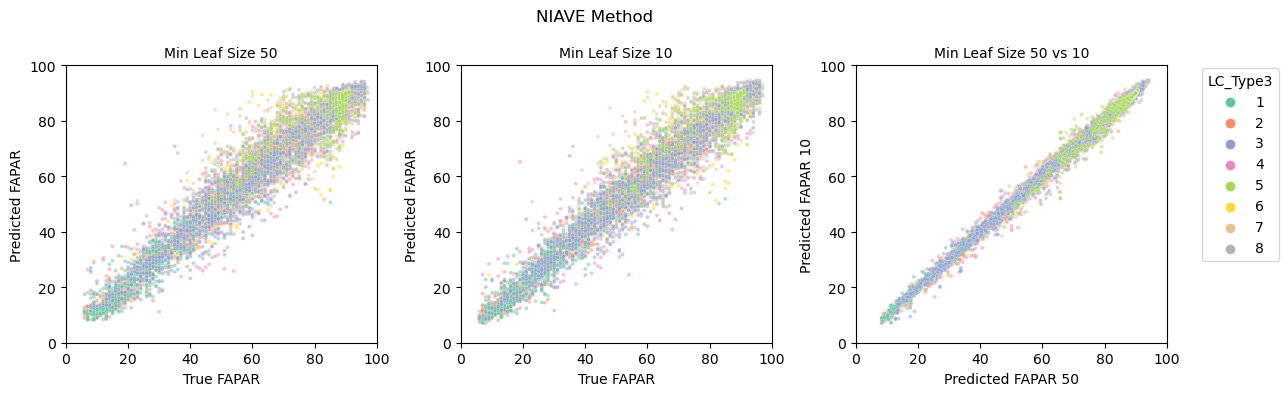

In [28]:
fig, axs = plt.subplots(1,3, figsize=(12, 4))
sns.scatterplot(dfcalbiomeFAPAR, x='FAPAR_50', y='Predicted FAPAR_50', ax=axs[0], hue='LC_Type3_50', palette='Set2', s=8, alpha=0.5, legend=0)
sns.scatterplot(dfcalbiomeFAPAR, x='FAPAR_10', y='Predicted FAPAR_10', ax=axs[1], hue='LC_Type3_50', palette='Set2', s=8, alpha=0.5)
sns.scatterplot(dfcalbiomeFAPAR, x='Predicted FAPAR_50', y='Predicted FAPAR_10', ax=axs[2], hue='LC_Type3_50', palette='Set2', s=8, alpha=0.5, legend=0)

fig.suptitle('NIAVE Method')
axs[0].set_title('Min Leaf Size 50', size=10)
axs[0].set(xlabel='True FAPAR', ylabel='Predicted FAPAR')
axs[0].set_xlim(0, 100)
axs[0].set_ylim(0, 100)

axs[1].set_title('Min Leaf Size 10', size=10)
axs[1].set(xlabel='True FAPAR', ylabel='Predicted FAPAR')
axs[1].set_xlim(0, 100)
axs[1].set_ylim(0, 100)

axs[2].set_title('Min Leaf Size 50 vs 10', size=10)
axs[2].set(xlabel='Predicted FAPAR 50', ylabel='Predicted FAPAR 10')
axs[2].set_xlim(0, 100)
axs[2].set_ylim(0, 100)

fig.tight_layout()

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", bbox_to_anchor=(1,0.85), title = "LC_Type3")
axs[1].get_legend().set_visible(False)

plt.show()

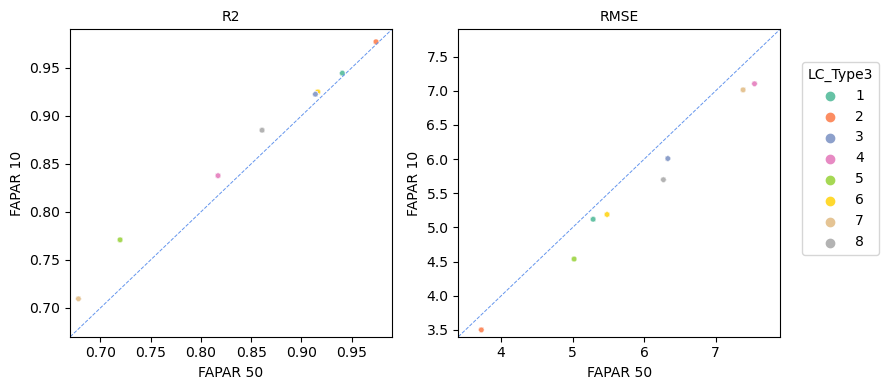

In [29]:
fig, axs = plt.subplots(1,2, figsize=(8, 4))
sns.scatterplot(dfcalbiomeFAPAR, x='R2_50', y='R2_10', ax=axs[0], hue='LC_Type3_50', palette='Set2', s=15, alpha=1, legend=0)
sns.scatterplot(dfcalbiomeFAPAR, x='RMSE_50', y='RMSE_10', ax=axs[1], hue='LC_Type3_50', palette='Set2', s=15, alpha=1)

axs[0].set_title('R2', size=10)
axs[0].set(xlabel='FAPAR 50', ylabel='FAPAR 10')
axs[0].set_xlim(0.67, 0.99)
axs[0].set_ylim(0.67, 0.99)
axs[0].axline((0,0), slope=1, c='cornflowerblue', lw=0.7, ls='--')

axs[1].set_title('RMSE', size=10)
axs[1].set(xlabel='FAPAR 50', ylabel='FAPAR 10')
axs[1].set_xlim(3.4, 7.9)
axs[1].set_ylim(3.4, 7.9)
axs[1].axline((0,0), slope=1, c='cornflowerblue', lw=0.7, ls='--')

fig.tight_layout()

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", bbox_to_anchor=(1,0.85), title = "LC_Type3")
axs[1].get_legend().set_visible(False)

plt.show()

### KANG LAI

Fitting a Random Forests for LAI using the KANG method

In [89]:
# Empty arrays used later to concatenate dataframes of all LC_Types
dfsLAI = []

# Looping through each LC_Type
for LC_Type3 in calbiomeDictLAIKANG:
    
    # Only fit Random Forests for LC_Types 1-8
    if LC_Type3 <= 8:
        
        # Extracting the dataframe from the calibration and validation data for the LC_Type
        # Only 10000 samples are used from the calibration data
        dfcal = calbiomeDictLAIKANG[LC_Type3]['DF'].sample(10000)
        dfval = valbiomeDictLAI[LC_Type3]['DF']
        
        # Fitting a Random Forest with min leaf size equal to 50
        calbiomeDictLAIKANG[LC_Type3]['regr50'] = RandomForestRegressor(min_samples_leaf = 50)
        calbiomeDictLAIKANG[LC_Type3]['regr50'].fit(dfcal[regressors], dfcal[LAI])
        
        # Fitting a Random Forest with min leaf size equal to 10
        calbiomeDictLAIKANG[LC_Type3]['regr10'] = RandomForestRegressor(min_samples_leaf = 10)
        calbiomeDictLAIKANG[LC_Type3]['regr10'].fit(dfcal[regressors], dfcal[LAI])
        
        trueLAI = dfval[LAI]
        
        # Predicting LAI with the Random Forest using the validation data
        predLAI50 = calbiomeDictLAIKANG[LC_Type3]['regr50'].predict(dfval[regressors])
        predLAI10 = calbiomeDictLAIKANG[LC_Type3]['regr10'].predict(dfval[regressors])
        
        # Determining the number of leaf nodes in each Random Forest
        n50 = 0
        for tree in calbiomeDictLAIKANG[LC_Type3]['regr50'].estimators_:
            n50 += tree.get_n_leaves()
        n10 = 0
        for tree in calbiomeDictLAIKANG[LC_Type3]['regr10'].estimators_:
            n10 += tree.get_n_leaves()
        
        # Inserting the new statistics as a dataframe into the dictionary
        valbiomeDictLAI[LC_Type3]['dfKANG50LAI'] = pd.DataFrame(data={
            'LAI': trueLAI,
            'Predicted LAI': predLAI50,
            'LC_Type3': LC_Type3,
            'R2': calbiomeDictLAIKANG[LC_Type3]['regr50'].score(dfval[regressors], trueLAI),
            'RMSE': metrics.mean_squared_error(predLAI50, trueLAI, squared=False),
            'Nodes': n50})
        
        valbiomeDictLAI[LC_Type3]['dfKANG10LAI'] = pd.DataFrame(data={
            'LAI': trueLAI,
            'Predicted LAI': predLAI10,
            'LC_Type3': LC_Type3,
            'R2': calbiomeDictLAIKANG[LC_Type3]['regr10'].score(dfval[regressors], trueLAI),
            'RMSE': metrics.mean_squared_error(predLAI10, trueLAI, squared=False),
            'Nodes': n10})
        
        # Merge two methods before sampling
        df = valbiomeDictLAI[LC_Type3]['dfKANG50LAI'].join(valbiomeDictLAI[LC_Type3]['dfKANG10LAI'], lsuffix='_50', rsuffix='_10')
        
        # Appending the dataframes to an array used to concatenate later
        dfsLAI.append(df.sample(1000))
        
# Concatenating the dataframes with the predicted LAI values for all LC_Types
dfcalbiomeLAIKANG = pd.concat(dfsLAI)

In [90]:
for LC_Type3 in valbiomeDictLAI:
    if LC_Type3 <= 8:
        print(LC_Type3, valbiomeDictLAI[LC_Type3]['dfKANG50LAI']['Nodes'].unique()[0], valbiomeDictLAI[LC_Type3]['dfKANG10LAI']['Nodes'].unique()[0])

6 9676 49518
4 9643 49414
7 9659 49419
2 9575 45976
1 9670 44636
8 9624 49436
3 9669 49309
5 9633 49489


R^2 and RMSE values for LAI Random Forest with min 50 leaf samples

In [91]:
for LC_Type3 in valbiomeDictLAI:
    if LC_Type3 <= 8:
        df = valbiomeDictLAI[LC_Type3]['dfKANG50LAI'][['R2', 'RMSE']]
        print(LC_Type3, df['R2'].unique()[0], df['RMSE'].unique()[0])

6 0.8587248709154578 7.289891254422329
4 0.7270650029739328 10.48540828872365
7 0.7183881293566321 9.552911628101885
2 0.8211643612774998 5.210842439637992
1 0.7351349288335409 9.828435811385225
8 0.7874663996041207 8.800140303932384
3 0.7013939718207727 10.902801715553663
5 0.6704823598839905 9.200221917120938


R^2 and RMSE values for LAI Random Forest with min 10 leaf samples

In [92]:
for LC_Type3 in valbiomeDictLAI:
    if LC_Type3 <= 8:
        df = valbiomeDictLAI[LC_Type3]['dfKANG10LAI'][['R2', 'RMSE']]
        print(LC_Type3, df['R2'].unique()[0], df['RMSE'].unique()[0])

6 0.8754147397550573 6.845757727648511
4 0.7596295387866177 9.840026796930797
7 0.7460115441036563 9.072297231791616
2 0.8515264382727953 4.7479427098420635
1 0.7662425344322105 9.233254485691806
8 0.8236717214728553 8.015613728259746
3 0.7393132890465223 10.187046175554062
5 0.800324440941893 7.1617873753587435


Scatterplotting True LAI vs Predicted LAI

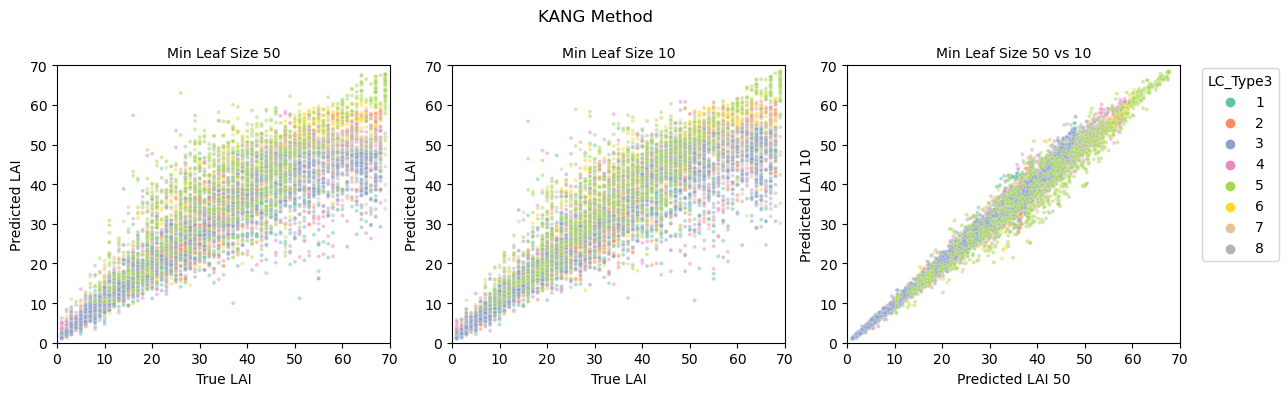

In [93]:
fig, axs = plt.subplots(1,3, figsize=(12, 4))
sns.scatterplot(dfcalbiomeLAIKANG, x='LAI_50', y='Predicted LAI_50', ax=axs[0], hue='LC_Type3_50', palette='Set2', s=8, alpha=0.5, legend=0)
sns.scatterplot(dfcalbiomeLAIKANG, x='LAI_10', y='Predicted LAI_10', ax=axs[1], hue='LC_Type3_50', palette='Set2', s=8, alpha=0.5)
sns.scatterplot(dfcalbiomeLAIKANG, x='Predicted LAI_50', y='Predicted LAI_10', ax=axs[2], hue='LC_Type3_50', palette='Set2', s=8, alpha=0.5, legend=0)

fig.suptitle('KANG Method')
axs[0].set_title('Min Leaf Size 50', size=10)
axs[0].set(xlabel='True LAI', ylabel='Predicted LAI')
axs[0].set_xlim(0, 70)
axs[0].set_ylim(0, 70)

axs[1].set_title('Min Leaf Size 10', size=10)
axs[1].set(xlabel='True LAI', ylabel='Predicted LAI')
axs[1].set_xlim(0, 70)
axs[1].set_ylim(0, 70)

axs[2].set_title('Min Leaf Size 50 vs 10', size=10)
axs[2].set(xlabel='Predicted LAI 50', ylabel='Predicted LAI 10')
axs[2].set_xlim(0, 70)
axs[2].set_ylim(0, 70)

fig.tight_layout()

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", bbox_to_anchor=(1,0.85), title = "LC_Type3")
axs[1].get_legend().set_visible(False)

plt.show()

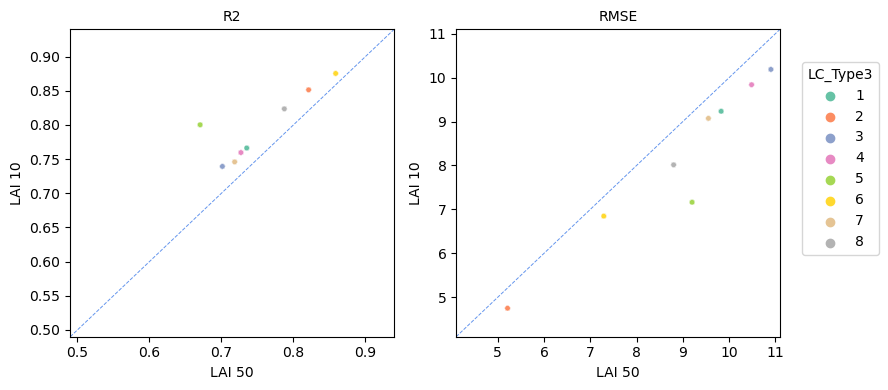

In [95]:
fig, axs = plt.subplots(1,2, figsize=(8, 4))
sns.scatterplot(dfcalbiomeLAIKANG, x='R2_50', y='R2_10', ax=axs[0], hue='LC_Type3_50', palette='Set2', s=15, alpha=1, legend=0)
sns.scatterplot(dfcalbiomeLAIKANG, x='RMSE_50', y='RMSE_10', ax=axs[1], hue='LC_Type3_50', palette='Set2', s=15, alpha=1)

axs[0].set_title('R2', size=10)
axs[0].set(xlabel='LAI 50', ylabel='LAI 10')
axs[0].set_xlim(0.49, 0.94)
axs[0].set_ylim(0.49, 0.94)
axs[0].axline((0,0), slope=1, c='cornflowerblue', lw=0.7, ls='--')

axs[1].set_title('RMSE', size=10)
axs[1].set(xlabel='LAI 50', ylabel='LAI 10')
axs[1].set_xlim(4.1, 11.1)
axs[1].set_ylim(4.1, 11.1)
axs[1].axline((0,0), slope=1, c='cornflowerblue', lw=0.7, ls='--')

fig.tight_layout()

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", bbox_to_anchor=(1,0.85), title = "LC_Type3")
axs[1].get_legend().set_visible(False)

plt.show()

### KANG FAPAR

Fitting a Random Forests for FAPAR using the KANG method

In [96]:
# Empty arrays used later to concatenate dataframes of all LC_Types
dfsFAPAR = []

# Looping through each LC_Type
for LC_Type3 in calbiomeDictFAPARKANG:
    
    # Only fit Random Forests for LC_Types 1-8
    if LC_Type3 <= 8:
        
        # Extracting the dataframe from the calibration and validation data for the LC_Type
        # Only 10000 samples are used from the calibration data
        dfcal = calbiomeDictFAPARKANG[LC_Type3]['DF'].sample(10000)
        dfval = valbiomeDictFAPAR[LC_Type3]['DF']
        
        # Fitting a Random Forest with min leaf size equal to 50
        calbiomeDictFAPARKANG[LC_Type3]['regr50'] = RandomForestRegressor(min_samples_leaf = 50)
        calbiomeDictFAPARKANG[LC_Type3]['regr50'].fit(dfcal[regressors], dfcal[FAPAR])
        
        # Fitting a Random Forest with min leaf size equal to 10
        calbiomeDictFAPARKANG[LC_Type3]['regr10'] = RandomForestRegressor(min_samples_leaf = 10)
        calbiomeDictFAPARKANG[LC_Type3]['regr10'].fit(dfcal[regressors], dfcal[FAPAR])
        
        trueFAPAR = dfval[FAPAR]
        
        # Predicting FAPAR with the Random Forest using the validation data 
        predFAPAR50 = calbiomeDictFAPARKANG[LC_Type3]['regr50'].predict(dfval[regressors])
        predFAPAR10 = calbiomeDictFAPARKANG[LC_Type3]['regr10'].predict(dfval[regressors])
        
        # Determining the number of leaf nodes in each Random Forest
        n50 = 0
        for tree in calbiomeDictFAPARKANG[LC_Type3]['regr50'].estimators_:
            n50 += tree.get_n_leaves()
        n10 = 0
        for tree in calbiomeDictFAPARKANG[LC_Type3]['regr10'].estimators_:
            n10 += tree.get_n_leaves()
        
        # Inserting the new statistics as a dataframe into the dictionary
        valbiomeDictFAPAR[LC_Type3]['dfKANG50FAPAR'] = pd.DataFrame(data={
            'FAPAR': trueFAPAR,
            'Predicted FAPAR': predFAPAR50,
            'LC_Type3': LC_Type3,
            'R2': calbiomeDictFAPARKANG[LC_Type3]['regr50'].score(dfval[regressors], trueFAPAR),
            'RMSE': metrics.mean_squared_error(predFAPAR50, trueFAPAR, squared=False),
            'Nodes': n50})
        
        valbiomeDictFAPAR[LC_Type3]['dfKANG10FAPAR'] = pd.DataFrame(data={
            'FAPAR': trueFAPAR,
            'Predicted FAPAR': predFAPAR10,
            'LC_Type3': LC_Type3,
            'R2': calbiomeDictFAPARKANG[LC_Type3]['regr10'].score(dfval[regressors], trueFAPAR),
            'RMSE': metrics.mean_squared_error(predFAPAR10, trueFAPAR, squared=False),
            'Nodes': n10})
        
        # Merge two methods before sampling
        df = valbiomeDictFAPAR[LC_Type3]['dfKANG50FAPAR'].join(valbiomeDictFAPAR[LC_Type3]['dfKANG10FAPAR'], lsuffix='_50', rsuffix='_10')
        
        # Appending the dataframes to an array used to concatenate later
        dfsFAPAR.append(df.sample(1000))
        
# Concatenating the dataframes with the predicted LAI values for all LC_Types
dfcalbiomeFAPARKANG = pd.concat(dfsFAPAR)

In [97]:
for LC_Type3 in valbiomeDictFAPAR:
    if LC_Type3 <= 8:
        print(LC_Type3, valbiomeDictFAPAR[LC_Type3]['dfKANG50FAPAR']['Nodes'].unique()[0], valbiomeDictFAPAR[LC_Type3]['dfKANG10FAPAR']['Nodes'].unique()[0])

6 9644 49514
4 9694 49398
7 9724 49453
2 9668 49571
1 9674 49470
8 9736 49538
3 9669 49470
5 9767 50028


R^2 and RMSE values for FAPAR Random Forest with min 50 leaf samples

In [98]:
for LC_Type3 in valbiomeDictFAPAR:
    if LC_Type3 <= 8:
        df = valbiomeDictFAPAR[LC_Type3]['dfKANG50FAPAR'][['R2', 'RMSE']]
        print(LC_Type3, df['R2'].unique()[0], df['RMSE'].unique()[0])

6 0.8895961634153909 8.01619807306172
4 0.8511560094699371 8.782935309439322
7 0.6812708412565895 9.651201848006236
2 0.9615494860313998 4.602952657415126
1 0.9514127754453227 6.318406649538214
8 0.8278043646438789 8.398438546446755
3 0.9465498751084456 6.339752066672066
5 0.5791910083679311 8.589678341115318


R^2 and RMSE values for FAPAR Random Forest with min 10 leaf samples

In [99]:
for LC_Type3 in valbiomeDictFAPAR:
    if LC_Type3 <= 8:
        df = valbiomeDictFAPAR[LC_Type3]['dfKANG10FAPAR'][['R2', 'RMSE']]
        print(LC_Type3, df['R2'].unique()[0], df['RMSE'].unique()[0])

6 0.909337981532143 7.2642210084073815
4 0.8726922792867869 8.12271850355119
7 0.7371242270393 8.76487610998797
2 0.9657013275808521 4.347344819062169
1 0.9532631297843388 6.196926436278395
8 0.8758775467213797 7.130379657958731
3 0.9540623543681169 5.877359803345082
5 0.6806895315426265 7.482400907345284


Scatterplotting True FAPAR vs Predicted FAPAR

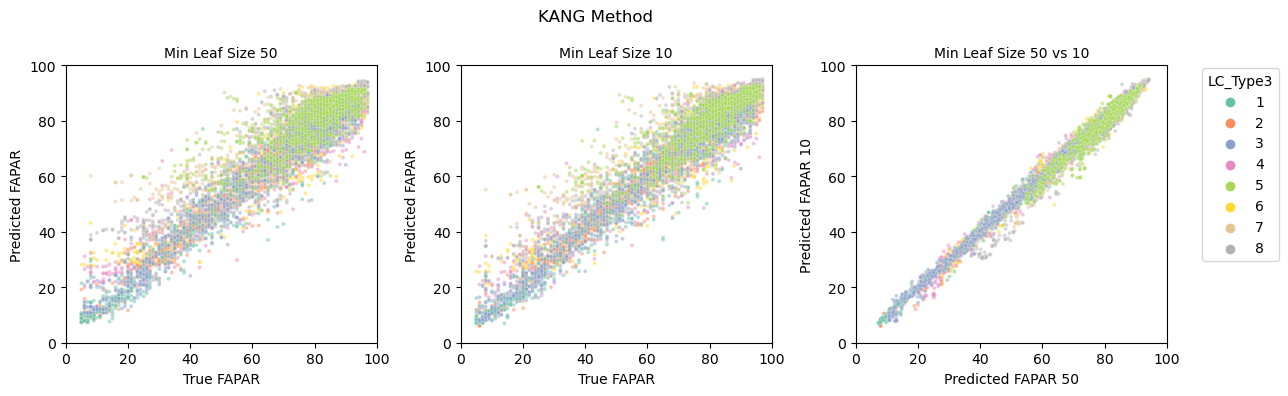

In [100]:
fig, axs = plt.subplots(1,3, figsize=(12, 4))
sns.scatterplot(dfcalbiomeFAPARKANG, x='FAPAR_50', y='Predicted FAPAR_50', ax=axs[0], hue='LC_Type3_50', palette='Set2', s=8, alpha=0.5, legend=0)
sns.scatterplot(dfcalbiomeFAPARKANG, x='FAPAR_10', y='Predicted FAPAR_10', ax=axs[1], hue='LC_Type3_50', palette='Set2', s=8, alpha=0.5)
sns.scatterplot(dfcalbiomeFAPARKANG, x='Predicted FAPAR_50', y='Predicted FAPAR_10', ax=axs[2], hue='LC_Type3_50', palette='Set2', s=8, alpha=0.5, legend=0)

fig.suptitle('KANG Method')
axs[0].set_title('Min Leaf Size 50', size=10)
axs[0].set(xlabel='True FAPAR', ylabel='Predicted FAPAR')
axs[0].set_xlim(0, 100)
axs[0].set_ylim(0, 100)

axs[1].set_title('Min Leaf Size 10', size=10)
axs[1].set(xlabel='True FAPAR', ylabel='Predicted FAPAR')
axs[1].set_xlim(0, 100)
axs[1].set_ylim(0, 100)

axs[2].set_title('Min Leaf Size 50 vs 10', size=10)
axs[2].set(xlabel='Predicted FAPAR 50', ylabel='Predicted FAPAR 10')
axs[2].set_xlim(0, 100)
axs[2].set_ylim(0, 100)

fig.tight_layout()

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", bbox_to_anchor=(1,0.85), title = "LC_Type3")
axs[1].get_legend().set_visible(False)

plt.show()

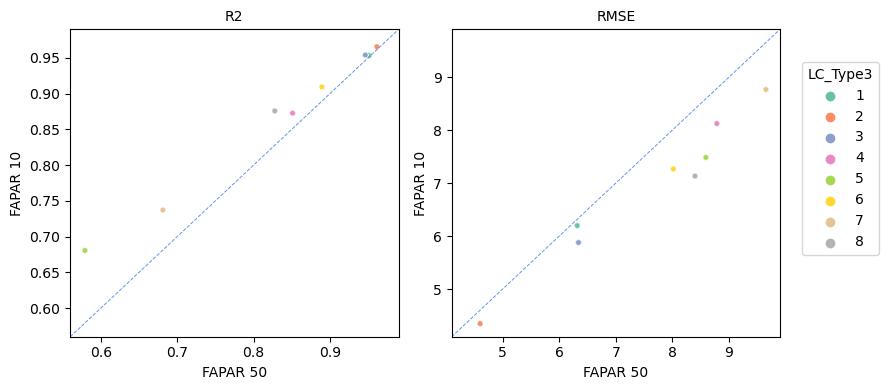

In [102]:
fig, axs = plt.subplots(1,2, figsize=(8, 4))
sns.scatterplot(dfcalbiomeFAPARKANG, x='R2_50', y='R2_10', ax=axs[0], hue='LC_Type3_50', palette='Set2', s=15, alpha=1, legend=0)
sns.scatterplot(dfcalbiomeFAPARKANG, x='RMSE_50', y='RMSE_10', ax=axs[1], hue='LC_Type3_50', palette='Set2', s=15, alpha=1)

axs[0].set_title('R2', size=10)
axs[0].set(xlabel='FAPAR 50', ylabel='FAPAR 10')
axs[0].set_xlim(0.56, 0.99)
axs[0].set_ylim(0.56, 0.99)
axs[0].axline((0,0), slope=1, c='cornflowerblue', lw=0.7, ls='--')

axs[1].set_title('RMSE', size=10)
axs[1].set(xlabel='FAPAR 50', ylabel='FAPAR 10')
axs[1].set_xlim(4.1, 9.9)
axs[1].set_ylim(4.1, 9.9)
axs[1].axline((0,0), slope=1, c='cornflowerblue', lw=0.7, ls='--')

fig.tight_layout()

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", bbox_to_anchor=(1,0.85), title = "LC_Type3")
axs[1].get_legend().set_visible(False)

plt.show()

## North America

### Random Forests

Reading in calibration and validation data dictionaries

In [ ]:
# Validation data for LAI and FAPAR
valbiomeDictLAI = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/valbiomeDictLAI.pkl')
valbiomeDictFAPAR = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/valbiomeDictFAPAR.pkl')

# Calibration data for LAI and FAPAR
calbiomeDictLAI = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/calbiomeDictLAI.pkl')
calbiomeDictFAPAR = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/calbiomeDictFAPAR.pkl')

# Kang's calibration data for LAI and FAPAR
calbiomeDictLAIKANG = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/calbiomeDictLAIKANG.pkl')
calbiomeDictFAPARKANG = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/calbiomeDictFAPARKANG.pkl')

# Calibration data for LAI and FAPAR
calbiomeDictLAIFTL = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/calbiomeDictLAIFTL.pkl')
calbiomeDictFAPARFTL = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/calbiomeDictFAPARFTL.pkl')

# https://drive.google.com/drive/folders/1jVKwxWPlH7nYnpL1yJAUD2jFkXV3A1kf?usp=share_link

Making copies of dictionaries to subsample North American samples

In [ ]:
# Copy of validation data for LAI and FAPAR
NAvalbiomeDictLAI = copy.deepcopy(valbiomeDictLAI)
NAvalbiomeDictFAPAR = copy.deepcopy(valbiomeDictFAPAR)

# copy of calibration data for LAI and FAPAR
NAcalbiomeDictLAI = copy.deepcopy(calbiomeDictLAI)
NAcalbiomeDictFAPAR = copy.deepcopy(calbiomeDictFAPAR)

Subsampling data to North America only

In [ ]:
for LC_Type3 in valbiomeDictLAI:
    # Validation data for LAI and FAPAR in North America
    df = NAvalbiomeDictLAI[LC_Type3]['DF']
    NAvalbiomeDictLAI[LC_Type3]['DF'] = df.loc[(df['Lat'] >= 7) & (df['Lat'] <= 85) & (df['Lon'] >= -180) & (df['Lon'] <= -20)]
    
    df = NAvalbiomeDictFAPAR[LC_Type3]['DF']
    NAvalbiomeDictFAPAR[LC_Type3]['DF'] = df.loc[(df['Lat'] >= 7) & (df['Lat'] <= 85) & (df['Lon'] >= -180) & (df['Lon'] <= -20)]

    # Calibration data for LAI and FAPAR in North America
    df = NAcalbiomeDictLAI[LC_Type3]['DF']
    NAcalbiomeDictLAI[LC_Type3]['DF'] = df.loc[(df['Lat'] >= 7) & (df['Lat'] <= 85) & (df['Lon'] >= -180) & (df['Lon'] <= -20)]
    
    df = NAcalbiomeDictFAPAR[LC_Type3]['DF']
    NAcalbiomeDictFAPAR[LC_Type3]['DF'] = df.loc[(df['Lat'] >= 7) & (df['Lat'] <= 85) & (df['Lon'] >= -180) & (df['Lon'] <= -20)]

Fitting a Random Forest on the global calibration data using the NAIVE method

In [ ]:
# NAIVE LAI
method='NAIVE'
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
response = 'LAI'
valbiomeDFLAI = pd.DataFrame()
for LC_type3 in calbiomeDictLAI.keys():
    df = calbiomeDictLAI[LC_type3]['DF']
    calbiomeDictLAI[LC_type3][method+response+'regression']  = RandomForestRegressor(n_estimators=100,min_samples_leaf=10,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000).fit(df[regressors],np.array(df[response]).ravel())
    calbiomeDictLAI[LC_type3]['DF'][method+response] = calbiomeDictLAI[LC_type3][method+response+'regression'].predict(df[regressors])
    valbiomeDictLAI[LC_type3][method+response+'regression'] = calbiomeDictLAI[LC_type3][method+response+'regression']
    valbiomeDictLAI[LC_type3]['DF'][method+response] = valbiomeDictLAI[LC_type3][method+response+'regression'].predict(valbiomeDictLAI[LC_type3]['DF'][regressors])
    valbiomeDFLAI = pd.concat([valbiomeDFLAI,valbiomeDictLAI[LC_type3]['DF']])
sns.scatterplot(valbiomeDFLAI.sample(10000),y=response,x=method+response,hue='LC_type3',s=8,alpha=0.5,palette='muted')

Fitting a Random Forest on the North America calibration data using the NAIVE method

In [ ]:
# NAIVE LAI
method='NA_NAIVE'
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
response = 'LAI'
NAvalbiomeDFLAI = pd.DataFrame()
for LC_type3 in NAcalbiomeDictLAI.keys():
    df = NAcalbiomeDictLAI[LC_type3]['DF']
    NAcalbiomeDictLAI[LC_type3][method+response+'regression']  = RandomForestRegressor(n_estimators=100,min_samples_leaf=10,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000).fit(df[regressors],np.array(df[response]).ravel())
    NAcalbiomeDictLAI[LC_type3]['DF'][method+response] = NAcalbiomeDictLAI[LC_type3][method+response+'regression'].predict(df[regressors])
    NAvalbiomeDictLAI[LC_type3][method+response+'regression'] = NAcalbiomeDictLAI[LC_type3][method+response+'regression']
    NAvalbiomeDictLAI[LC_type3]['DF'][method+response] = NAvalbiomeDictLAI[LC_type3][method+response+'regression'].predict(NAvalbiomeDictLAI[LC_type3]['DF'][regressors])
    NAvalbiomeDFLAI = pd.concat([NAvalbiomeDFLAI,NAvalbiomeDictLAI[LC_type3]['DF']])
sns.scatterplot(NAvalbiomeDFLAI.sample(10000),y=response,x=method+response,hue='LC_type3',s=8,alpha=0.5,palette='muted')

### Results

Number of samples in each biome for the North American and global calibration dataset

In [ ]:
for LC_Type3 in NAcalbiomeDictLAI:
    print('{0: <3} {1: <8} {2}'.format(LC_Type3, len(NAcalbiomeDictLAI[LC_Type3]['DF']), len(calbiomeDictLAI[LC_Type3]['DF'])))

Number of leaf nodes for each biome for the fitted Random Forests

In [ ]:
for LC_Type3 in NAvalbiomeDictLAI:
    if LC_Type3 <= 8:
        NAnodes = 0
        nodes = 0
        for tree in NAvalbiomeDictLAI[LC_Type3]['NA_NAIVELAIregression'].estimators_:
            NAnodes += tree.get_n_leaves()
        for tree in valbiomeDictLAI[LC_Type3]['NAIVELAIregression'].estimators_:
            nodes += tree.get_n_leaves()
        print('{0: <2} {1: <8} {2}'.format(LC_Type3, NAnodes, nodes))

Calculate the R^2 for the NAIVE method fitted with the North America and Global calibration dataset

In [ ]:
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
dfR2 = pd.DataFrame()
for LC_Type3 in NAvalbiomeDictLAI:
    if LC_Type3 <= 8:
        R2_NA = NAcalbiomeDictLAI[LC_Type3]['NA_NAIVELAIregression'].score(NAcalbiomeDictLAI[LC_Type3]['DF'][regressors], NAcalbiomeDictLAI[LC_Type3]['DF']['LAI'])
        R2 = calbiomeDictLAI[LC_Type3]['NAIVELAIregression'].score(calbiomeDictLAI[LC_Type3]['DF'][regressors], calbiomeDictLAI[LC_Type3]['DF']['LAI'])
        d = {'LC_Type3': [LC_Type3], 'R2_Global':[R2], 'R2_NA': [R2_NA]}
        df = pd.DataFrame(data=d)
        dfR2 = pd.concat([dfR2, df])
        print('{0: <4} {1: <20} {2}'.format(LC_Type3, R2_NA, R2))

Calculate the RMSE for the NAIVE method fitted with the North America and Global calibration dataset

In [ ]:
dfRMSE = pd.DataFrame()
for LC_Type3 in NAvalbiomeDictLAI:
    if LC_Type3 <= 8:
        RMSE_NA = metrics.mean_squared_error(NAcalbiomeDictLAI[LC_Type3]['DF']['NA_NAIVELAI'], NAcalbiomeDictLAI[LC_Type3]['DF']['LAI'], squared=False)
        RMSE = metrics.mean_squared_error(calbiomeDictLAI[LC_Type3]['DF']['NAIVELAI'], calbiomeDictLAI[LC_Type3]['DF']['LAI'], squared=False)
        d = {'LC_Type3': [LC_Type3], 'RMSE_Global':[RMSE], 'RMSE_NA': [RMSE_NA]}
        df = pd.DataFrame(data=d)
        dfRMSE = pd.concat([dfRMSE, df])
        print('{0: <4} {1: <20} {2}'.format(LC_Type3, RMSE_NA, RMSE))

Scatterplot of the R^2 and RMSE comparing the two datasets

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(8, 4))
sns.scatterplot(dfR2, x='R2_Global', y='R2_NA', ax=axs[0], hue='LC_Type3', palette='Set2', s=15, alpha=1, legend=0)
sns.scatterplot(dfRMSE, x='RMSE_Global', y='RMSE_NA', ax=axs[1], hue='LC_Type3', palette='Set2', s=15, alpha=1)

axs[0].set_title('R2', size=10)
axs[0].set(xlabel='Global', ylabel='North America')
axs[0].set_xlim(0.76, 0.99)
axs[0].set_ylim(0.76, 0.99)
axs[0].axline((0,0), slope=1, c='cornflowerblue', lw=0.7, ls='--')

axs[1].set_title('RMSE', size=10)
axs[1].set(xlabel='Global', ylabel='North America')
axs[1].set_xlim(1.1, 6.9)
axs[1].set_ylim(1.1, 6.9)
axs[1].axline((0,0), slope=1, c='cornflowerblue', lw=0.7, ls='--')

fig.tight_layout()

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", bbox_to_anchor=(1,0.85), title = "LC_Type3")
axs[1].get_legend().set_visible(False)

plt.show()

Scatterplot of both datasets comparing the predicted LAI and true LAI

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(8, 4))
sns.scatterplot(valbiomeDFLAI.sample(10000), x='LAI', y='NAIVELAI', ax=axs[0], hue='LC_type3', palette='Set2', s=8, alpha=0.5, legend=0)
sns.scatterplot(NAvalbiomeDFLAI.sample(10000), x='LAI', y='NA_NAIVELAI', ax=axs[1], hue='LC_type3', palette='Set2', s=8, alpha=0.5)

fig.suptitle('NAIVE Method')
axs[0].set_title('Global', size=10)
axs[0].set(xlabel='True LAI', ylabel='Predicted LAI')
axs[0].set_xlim(0, 70)
axs[0].set_ylim(0, 70)

axs[1].set_title('North America', size=10)
axs[1].set(xlabel='True LAI', ylabel='Predicted LAI')
axs[1].set_xlim(0, 70)
axs[1].set_ylim(0, 70)

fig.tight_layout()

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", bbox_to_anchor=(1,0.85), title = "LC_Type3")
axs[1].get_legend().set_visible(False)

plt.show()

## LUT_satFlag Filter

In [210]:
# Kang's calibration data for LAI and FAPAR
calbiomeDictLAIKANG = pd.read_pickle('G:/cassidy/MODISLANDSAT/calbiomeDictLAIKANG.pkl')
calbiomeDictFAPARKANG = pd.read_pickle('G:/cassidy/MODISLANDSAT/calbiomeDictFAPARKANG.pkl')

# https://drive.google.com/drive/folders/1jVKwxWPlH7nYnpL1yJAUD2jFkXV3A1kf?usp=share_link

In [211]:
# Regressors used in fitting the Random Forests
regressors = ['Lat','Lon','red','green','NIR','SWIR1','NDVI','NDWI','cosSZA','cosSA']

# Responses in the Random Forests
satFlag = 'LUT_satFlag'

Concatenate all biome types into one dataframe

In [212]:
dfs = []
for LC_Type3 in calbiomeDictLAIKANG:
    if LC_Type3 <= 8:
        dfs.append(calbiomeDictLAIKANG[LC_Type3]['DF'])
dfKANGLAI = pd.concat(dfs)

Fitting a Random Forest Classifier to predict LUT_satFlag

In [213]:
# Empty arrays used later to concatenate dataframes of all LC_Types
dfs = []

# Looping through each LC_Type
for LC_Type3 in calbiomeDictLAIKANG:
    
    # Only fit Random Forests for LC_Types 1-8
    if LC_Type3 <= 8:
        
        # Extracting the dataframe from the calibration data for the LC_Type
        # Only 10000 samples are used from the calibration data
        dfcal = calbiomeDictLAIKANG[LC_Type3]['DF'].sample(10000)
        dfval = calbiomeDictLAIKANG[LC_Type3]['DF']
        
        # Fitting a Random Forest with min leaf size equal to 10
        calbiomeDictLAIKANG[LC_Type3]['sat_class'] = RandomForestClassifier(n_estimators=100,min_samples_leaf=10,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000)
        calbiomeDictLAIKANG[LC_Type3]['sat_class'].fit(dfcal[regressors], dfcal[satFlag])
        
        # Predicting LUT_satFlag with the Random Forest using the validation data
        predSatFlag = calbiomeDictLAIKANG[LC_Type3]['sat_class'].predict(dfval[regressors])
        
        # Inserting the new statistics as a column into the dataframe
        calbiomeDictLAIKANG[LC_Type3]['DF']['predSatFlag'] = predSatFlag

Filter out all data where the predicted LUT_satFlag and true LUT_satFlag differ

In [214]:
for LC_Type3 in calbiomeDictLAIKANG:
    if LC_Type3 <= 8:
        df = calbiomeDictLAIKANG[LC_Type3]['DF']
        
        # Only keep data where the predicted satFlag matches the true satFlag
        calbiomeDictLAIKANG[LC_Type3]['DF'] = df.loc[df['LUT_satFlag'] == df['predSatFlag']]

In [215]:
# Prints dataframe for biome 1 where predicted LUT_satFlag and true LUT_satFlag differ to check filtering worked
df = calbiomeDictLAIKANG[1]['DF']
df.loc[(df['LUT_satFlag'] != df['predSatFlag']) & (df['LUT_satFlag'] == 0)]

Empty DataFrame
Columns: [year, month, day, path, row, Lat, Lon, input36, input45, inputMOD09, redMODIS, NIRMODIS, green, red, NIR, SWIR1, SensorZenith, SensorAzimuth, SolarZenith, SolarAzimuth, M_sensor_zenith, M_sensor_azimuth, M_sun_zenith, M_sun_azimuth, LC_type3, output, LAI, stdLAI, FAPAR, stdFAPAR, LUT_satFlag, LUT_snowFlag, cosSZA, cosVZA, cosSA, NDVI, NDWI, kde, predSatFlag]
Index: []

[0 rows x 39 columns]

Number of samples in each biome type after filtering

In [216]:
for LC_Type3 in calbiomeDictLAIKANG:
    print('{0: <3} {1: <8}'.format(LC_Type3, len(calbiomeDictLAIKANG[LC_Type3]['DF'])))

6   428077  
4   1525431 
7   287518  
9   18743   
2   448124  
1   2170150 
8   50130   
3   231392  
5   176187  
10  2087    


Saturation classification accuracy based on 10-fold cross-validation

6 dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_f1', 'test_precision', 'test_recall'])
fit_time         4.523362398147583
score_time       0.12764806747436525
test_accuracy    0.9782  
test_f1          0.9748827765701327
test_precision   0.9675914053768485
test_recall      0.9823460853612473
4 dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_f1', 'test_precision', 'test_recall'])
fit_time         0.33437845706939695
score_time       0.11965720653533936
test_accuracy    0.9921  
test_f1          0.81886589035136
test_precision   0.8976312725353646
test_recall      0.7603260869565218
7 dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_f1', 'test_precision', 'test_recall'])
fit_time         0.32887897491455076
score_time       0.1146615982055664
test_accuracy    0.9693999999999999
test_f1          0.9013436614558866
test_precision   0.9195260452459724
test_recall      0.8844399331263435


C:\Users\casli\Anaconda3\envs\cassidy\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\casli\Anaconda3\envs\cassidy\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\casli\Anaconda3\envs\cassidy\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\casli\Anaconda3\envs\cassidy\lib\site-packages\sklearn

2 dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_f1', 'test_precision', 'test_recall'])
fit_time         0.31321532726287843
score_time       0.12353203296661378
test_accuracy    1.0     
test_f1          0.0     
test_precision   0.0     
test_recall      0.0     


C:\Users\casli\Anaconda3\envs\cassidy\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\casli\Anaconda3\envs\cassidy\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\casli\Anaconda3\envs\cassidy\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\casli\Anaconda3\envs\cassidy\lib\site-packages\sklearn\metrics\_classi

1 dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_f1', 'test_precision', 'test_recall'])
fit_time         0.3296877384185791
score_time       0.1304492712020874
test_accuracy    0.999   
test_f1          0.0     
test_precision   0.0     
test_recall      0.0     
8 dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_f1', 'test_precision', 'test_recall'])
fit_time         0.3273958444595337
score_time       0.10634889602661132
test_accuracy    0.9671  
test_f1          0.9270254942600321
test_precision   0.922812775598663
test_recall      0.931390873015873
3 dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_f1', 'test_precision', 'test_recall'])
fit_time         0.31469550132751467
score_time       0.11622653007507325
test_accuracy    0.9967999999999998
test_f1          0.6684887334887335
test_precision   0.8564285714285715
test_recall      0.5766666666666665
5 dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_f1', 'test_precision', 'test_recall'